## **Library Imports**

In [ ]:
import pandas as pd
import numpy as np
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import log_loss, classification_report, accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

from bs4 import BeautifulSoup
from html import unescape

from collections import Counter, defaultdict

from IPython.display import Markdown, display
from matplotlib import pyplot as plt
import seaborn as sns
from itertools import cycle

import time
import inspect
from os import path
import sys  
if 'contractions' not in sys.modules:
  !{sys.executable} -m pip install contractions

import contractions

import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag


import torch
import torch.nn as nn





[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Data Preprocessing and Statistics**

Functions for neccessary **text cleaning** including URL and HTML removal, contraction normalization, lowercasing and further noisy input elimination (such as emojis, symbols etc...). An extra preprocessing stage (such as stopword removal, length filtering, lemmatization etc...) can also be applied

In [ ]:
def removeHTML(text):
  soup = BeautifulSoup(text)
  soup = BeautifulSoup(unescape(soup.get_text()), 'lxml')
  return soup.get_text()

def fixContractions(tweet):
  expanded_words = []    
  for word in tweet.split():
    expanded_words.append(contractions.fix(word).lower())
  return expanded_words

def get_pos(tag):
  if tag.startswith('J'):
    return wordnet.ADJ
  elif tag.startswith('V'):
    return wordnet.VERB
  elif tag.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN

def normalization(tweet, lemmatizer):
  tagged_tweet = pos_tag(tweet.split())
  clean_tweet = ' '.join([lemmatizer.lemmatize(word, get_pos(tag)) for word, tag in tagged_tweet])
  return clean_tweet

def extra_preprocessing(df, column):
  lemmatizer = WordNetLemmatizer()
  #stemmer = PorterStemmer()
  stop_words = set(stopwords.words('english'))
  # Some words that might be useful for sentiment recognition
  special_word_set = set(['no', 'we', 'i', 'you', 'not'])
  # Lemmatization
  df[column] = df[column].apply(lambda tweet: normalization(tweet, lemmatizer))
  # Stopword removal and length filtering
  df[column] = df[column].apply(lambda tweet: ' '.join([w for w in tweet.split() if (len(w) > 2 and w not in stop_words) or w in special_word_set]))

# All the neccessary cleaning for the data
def preprocessing(df, column, simple_preprocessing = True):
  # Lowercasing all characters in order to treat all words in a same way
  df[column] = df[column].str.lower()
  # Removal of tweet mentions (names appeared in mentions are not so important)
  #df['tweet'] = df['tweet'].str.replace(r'@\S+', '')
  # Retweet removal
  df[column] = df[column].str.replace(r'\s+rt|^rt', '')
  # URL and HTML tag cleaning (some links dont make any sense and are not so important)
  df[column] = df[column].str.replace(r'http\S+|www.\S+', '')
  df[column] = df[column].apply(removeHTML)
  # Contraction fixing
  df[column] = df[column].apply(lambda tweet: ' '.join(fixContractions(tweet)))
  # Non letter character removal
  df[column] = df[column].str.replace(r'-|–|\[|\]|_', '').str.replace(r'[^a-zA-z]+', ' ')
  # Whitespace removal
  df[column] = df[column].str.replace(r'\s+', ' ')
  if not simple_preprocessing:
    extra_preprocessing(df, column)
  # Empty tweet removal
  df = df[df[column] != '']

**Dataset loading** and **preprocessing** using the above fuctions 

In [ ]:
#LOAD TEST SET AS ./vaccine_validation_set.csv OR GIVE THE RIGHT PATH

# Reading the two csv files with pandas
training_set = pd.read_csv('./vaccine_train_set.csv', encoding = 'utf-8')
validation_set = pd.read_csv('./vaccine_validation_set.csv', encoding = 'utf-8')
print('\nBefore cleaning:')
print(training_set.head(10))
print(validation_set.head(10))


preprocessing(training_set, 'tweet', simple_preprocessing = False)
preprocessing(validation_set, 'tweet', simple_preprocessing = False)

print('\nAfter cleaning:')
print(training_set.head(10))
print(validation_set.head(10))


Before cleaning:
   Unnamed: 0                                              tweet  label
0           0  Sip N Shop Come thru right now #Marjais #Popul...      0
1           1  I don't know about you but My family and I wil...      1
2           2  @MSignorile Immunizations should be mandatory....      2
3           3  President Obama spoke in favor of vaccination ...      0
4           4  "@myfoxla: Arizona monitoring hundreds for mea...      0
5           5  Why did I get my whooping cough vaccine the sa...      2
6           6  Prosecutor Ken Ervin: I want to know how reckl...      0
7           7  "@UberFacts: On average, people who complain l...      0
8           8  The legacy of @JennyMcCarthy will be she took ...      2
9           9  “@UberFacts: On average, people who complain l...      0
   Unnamed: 0                                              tweet  label
0           0  @user They had a massive surge in with covid d...      1
1           1  Required vaccines for school: P

Visualization of the results extracted from the **statistical analysis** for the tweets

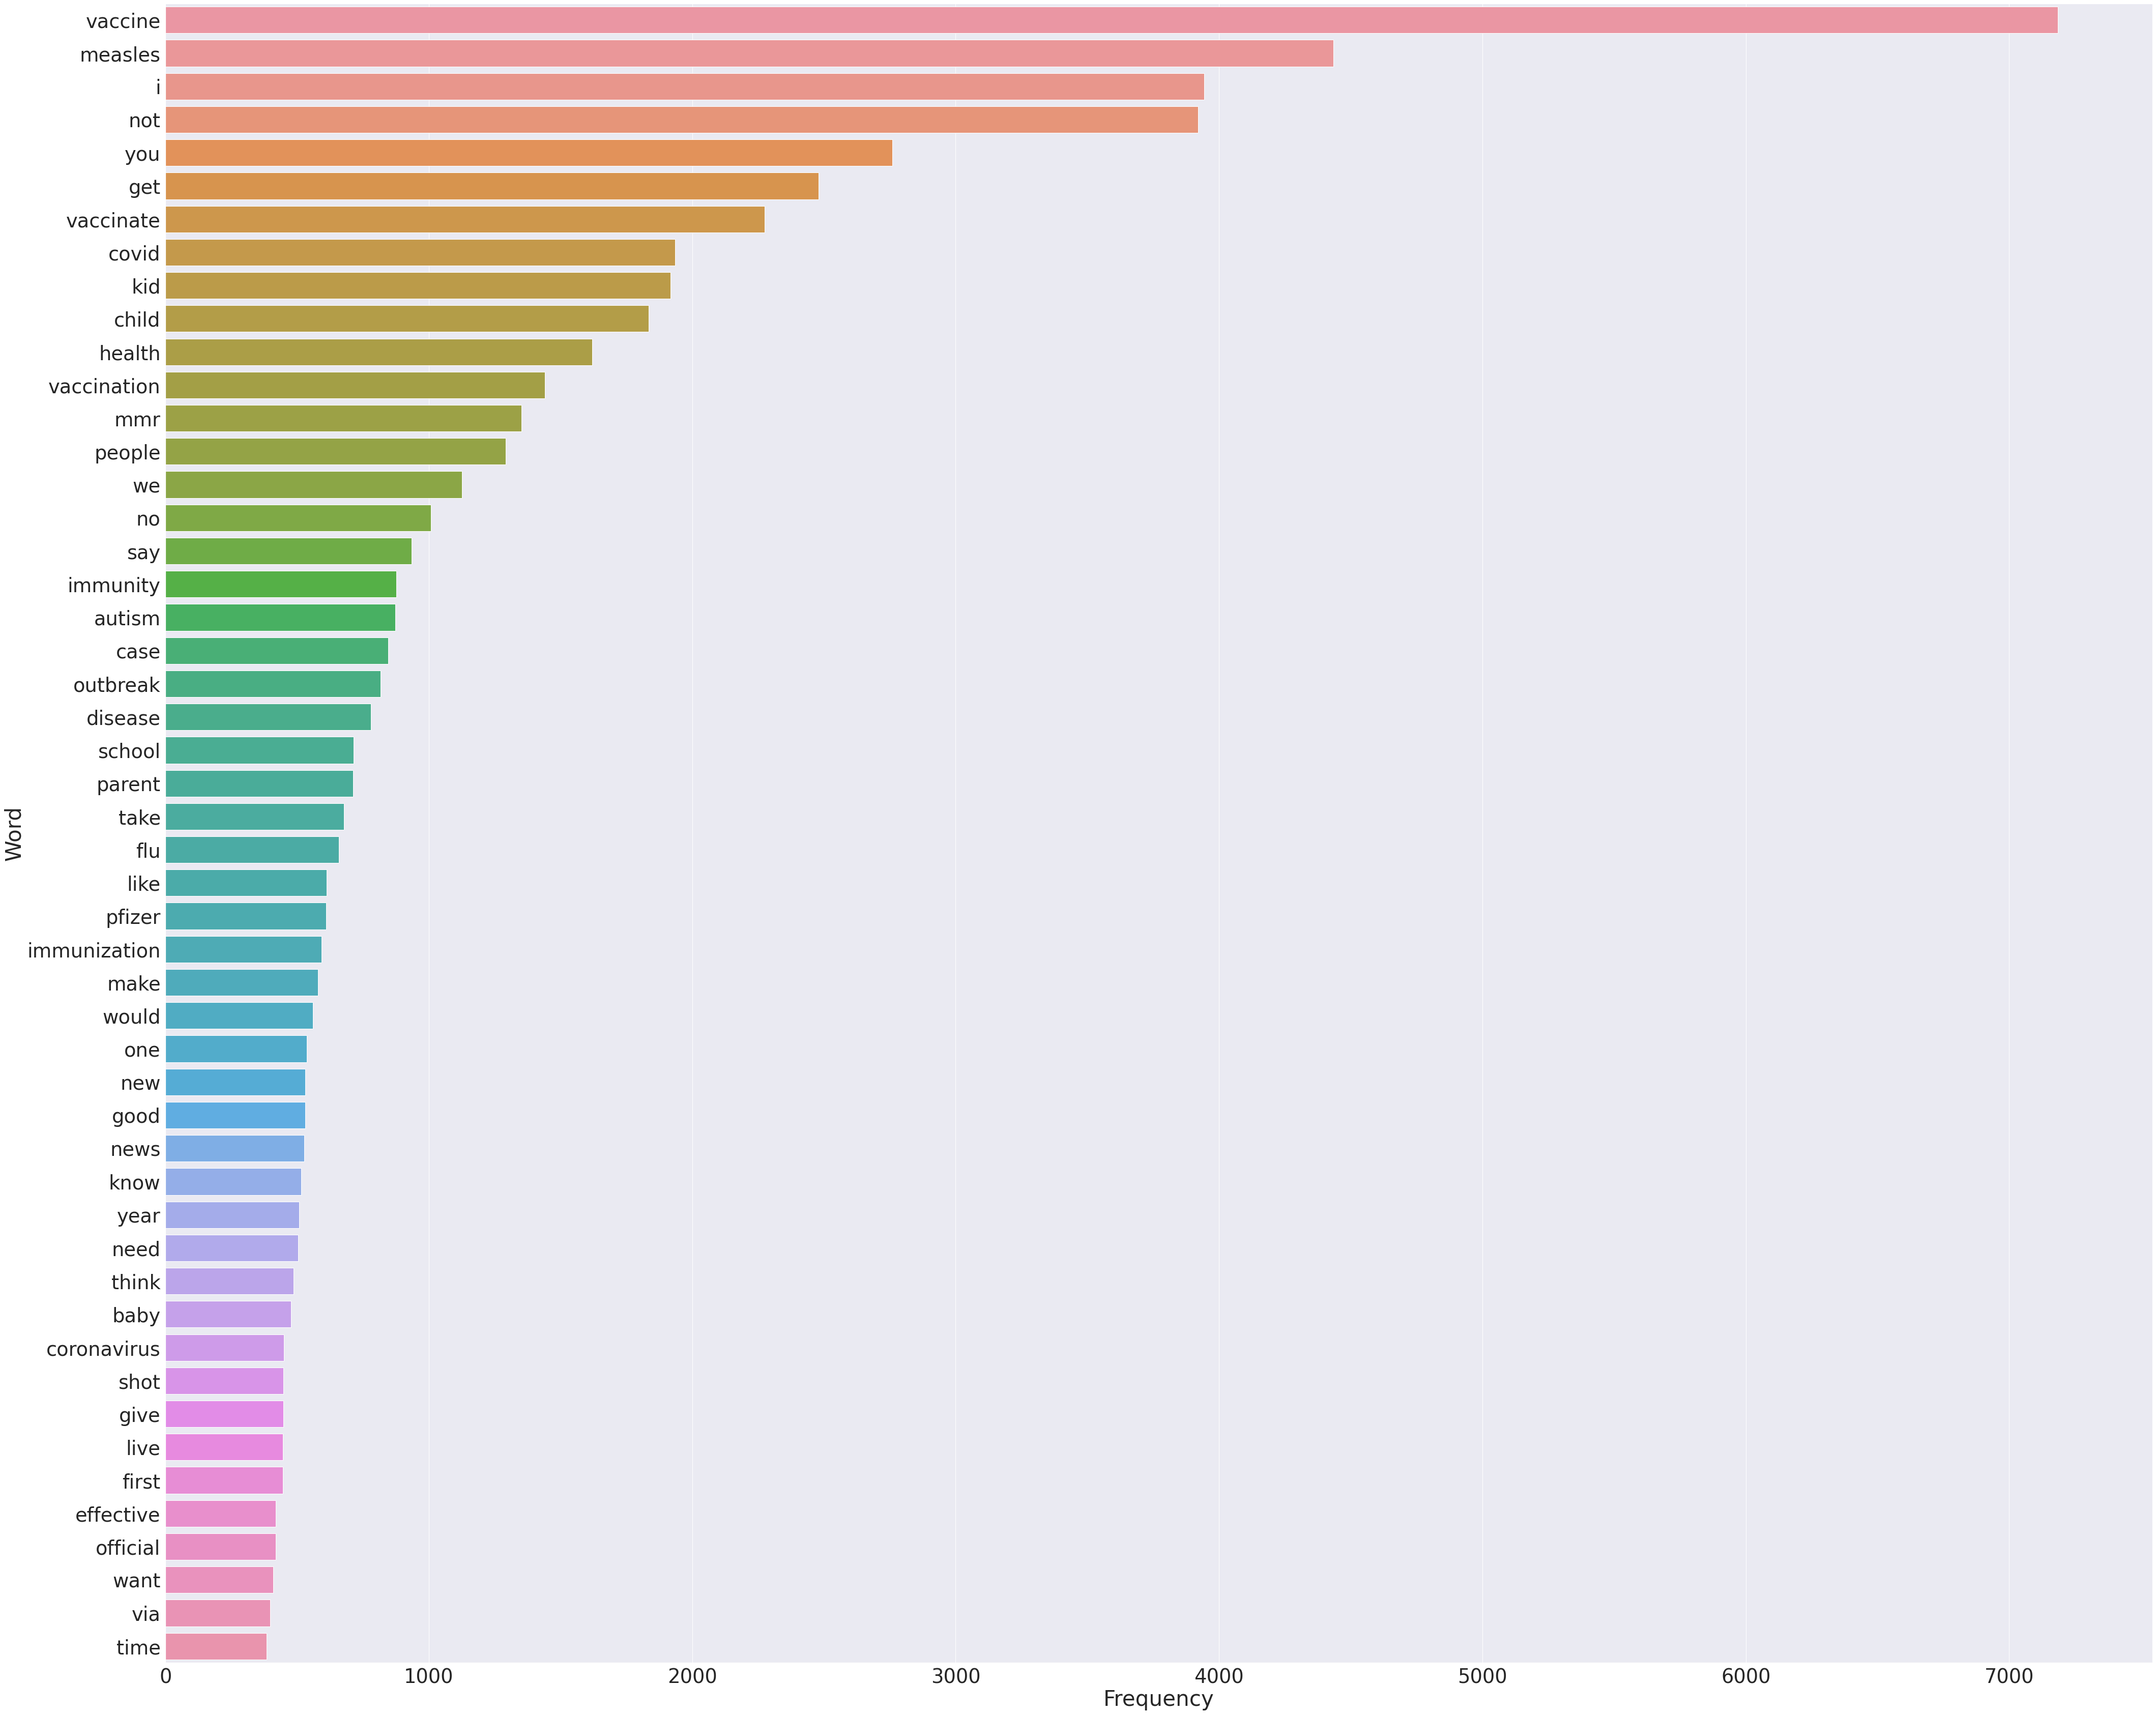

Training set size is 15976
Average length of tweets in traning set 77.385641
Neutral tweets are 46.68252378567852%
Antivax tweets are 12.975713570355532%
Provax tweets are 40.34176264396595%


In [ ]:
# Visualization of the most common words and some other stats (for better insights)
def tweetStatistics(tweets):
  all_words = []
  tweet_lens = []
  for tweet in tweets:
    tweet_lens.append(len(tweet))
    for word in tweet.split():
      all_words.append(word)
  # Using pandas to merge the word column and the frequency column for seaborn barplot
  word_freq = pd.DataFrame(Counter(all_words).items(), columns = ['Word','Frequency']).sort_values(by = 'Frequency', ascending = False)
  figure = plt.figure()
  figure.set_figwidth(70)
  figure.set_figheight(60)
  sns.set(font_scale = 3.5)
  bar = sns.barplot(x = 'Frequency', y = 'Word', data = word_freq.head(50))
  plt.show()
  sns.set(font_scale = 1)

  return len(tweet_lens), sum(tweet_lens) / len(tweet_lens)

training_size, avg_tweet_len = tweetStatistics(training_set['tweet'].tolist())
print('Training set size is %d' % training_size)
print('Average length of tweets in traning set %f' % avg_tweet_len)
stats = training_set.groupby(['label']).count()
for stat, name in zip(stats['tweet'].tolist(), ['Neutral', 'Antivax', 'Provax']):
  print(name + ' tweets are ' + str(stat / training_size * 100) + '%')


## **Training a Recurrent Neural Net**

Using **GPU** will make the neural network run **much faster** than using the **CPU**. GPU is more effiecient for neural networks like RNNs because a lot of their work can be processed **in parallel**. So if GPU is available then GPU is selected against the CPU which is the default

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running on GPU/Cuda' if torch.cuda.is_available() else 'Running on CPU')

Running on GPU/Cuda


Useful functions for  **perfomance visualization**. These functions are used for plotting **confusion matrices**, **learning curves** (loss vs epochs)  and **roc curves**

In [ ]:
def plotConfusionMatrix(matrix, title, ax, targets = None):
    sns.heatmap(matrix, annot = True, cmap = 'Blues', fmt = "d", ax = ax)
    ax.set_title(title + '\n');
    if targets is None:
      ax.xaxis.set_ticklabels(['False', 'True'])
      ax.yaxis.set_ticklabels(['False', 'True'])
    else:
      ax.xaxis.set_ticklabels(targets)
      ax.yaxis.set_ticklabels(targets)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 10, labelbottom = False, bottom = False, top = False, labeltop = True)

def plotConfusionMatrices(targets, class_confusion_matrices, glob_confusion_matrix = None):
    if glob_confusion_matrix is not None:
      fig, axes = plt.subplots(1, len(targets) + 1)
    else:
      fig, axes = plt.subplots(1, len(targets))

    fig.set_figheight(4)
    fig.set_figwidth(20)
    i = 0
    for matrix, target in zip(class_confusion_matrices, targets):
      plotConfusionMatrix(matrix, 'Confusion Matrix for ' + target, axes[i])
      i += 1
      print()

    if glob_confusion_matrix is not None:
      plotConfusionMatrix(glob_confusion_matrix, 'Global Confusion Matrix', axes[-1], targets)
    
    plt.tight_layout()
    plt.show()


def plotLearningCurves(x_axis, y_axis, x_label, y_label, curve_ids, ax, legend_loc = 'lower right', x_best = None, y_best = None):
  if x_best is not None and y_best is not None:
    ax.annotate('Early Stopping Checkpoint ' + str(x_best), xy = (x_best, y_best), arrowprops = dict(facecolor = 'black', shrink = 0.05))
  for y, id in zip(y_axis, curve_ids):
    ax.plot(x_axis, y, label = id, linewidth = 4)
  ax.set_title('Learning Curves')
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  ax.legend(loc = legend_loc)
 

def plotRocCurves(fpr, tpr, roc_auc, n_classes, lw = 2):
  fig = plt.figure()
  plt.plot(
      fpr['micro'],
      tpr['micro'],
      label = 'micro-average ROC curve (area = {0:0.2f})'.format(roc_auc['micro']),
      color = 'deeppink',
      linestyle = ':',
      linewidth = 4,
  )

  plt.plot(
      fpr['macro'],
      tpr['macro'],
      label = 'macro-average ROC curve (area = {0:0.2f})'.format(roc_auc['macro']),
      color = 'navy',
      linestyle = ':',
      linewidth = 4,
  )

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(
          fpr[i],
          tpr[i],
          color = color,
          lw = lw,
          label = 'ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]),
      )

  plt.plot([0, 1], [0, 1], 'k--', lw = lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic Curves')
  plt.legend(loc = 'lower right')
  fig.set_figheight(10)
  fig.set_figwidth(10)
  plt.show()



Declaration of the different **RNN types** that are going to be used. Also some scheldulers are declared, in order to adjust the learning rate properly and help the training process to avoid big steps, like **Exponential** schelduler, **One Cycle** schelduler **Performance** schelduler etc...

In [ ]:
# RNN architectures by their cell type
rnn_types = {
  'Vanilla': nn.RNN,
  'LSTM': nn.LSTM,
  'GRU': nn.GRU
}

# Popular learning rate scheldulers
scheldulers = {
  'Exponential': lambda optimizer, step: torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.1 ** (epoch / step)), # Initial lr* 0.1^(t/step)
  'Power': lambda optimizer, step: torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 1 / (1 + epoch / step)), # Initial lr/ (1 + t/step)
  'Piecewise': lambda optimizer, milestones:  torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = milestones, gamma = 0.1), # lr for 1 <= epoch < m1, lr*0.1 for m1 <= epoch < m2 ...
  'Performance': lambda optimizer, patience, factor : torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = patience, factor = factor),
  'OneCycle': lambda optimizer, steps_per_epoch, epochs, max_lr : torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = max_lr, anneal_strategy = 'linear', steps_per_epoch = steps_per_epoch, epochs = epochs)
}

Some **useful tools** that are going to be used by the model. The first one is the **attention mechanism** that supports two attention models (dot product and multiplicative/general attention) according to a query and some context. Also a masking functionality is supported when the sequence lengths are given (to mask the padding). The second tool is a **custom dataset** in order to manage any representation of the tweets and their labels so the data loader can use them to create the batches. The third one is also related to the data loader and its usage is to **pad** a batch to the same (**fixed**) length

In [ ]:
class Attention(nn.Module):
    def __init__(self, d1, d2, attention_type = 'ATTENTION_DOT'):
        super().__init__()
        
        if attention_type == 'ATTENTION_GENERAL':
            self.weights = nn.Linear(d2, d1, bias = False)
        elif attention_type == 'ATTENTION_DOT':
          if d1 != d2:
            raise Exception('Dimensions d1 and d2 must be equal')
        else:
          raise Exception('Unknown attention type ' + attention_type)

        self.attention_type = attention_type

        self.d1 = d1
        self.d2 = d2

        self.softmax = self.softmax = nn.Softmax(dim = 2)
        
        self.tanh = nn.Tanh()

        # Sum of the two dimensions because of the concatenation
        self.projection = nn.Linear(d1 + d2, d1)

    def forward(self, query, context, global_context = None, seq_lengths = None):
        ''' 
            Args:
                  query: tensor (batch_size, 1 , d1) A query that is going to attend a context
                  context: tensor (batch_size, seq_len, d2) A context that is going to be attended by a query
                  global_context: tensor (batch_size, d1) The context that the attention is going to be added to
                  seq_lengths: tensor (batch_size) The actual lengths

            Returns:
                  output: tensor (batch_size, d1) The last concatenated and transformed output including the attention
                  attention: tensor (batch_size, d2) The attention vector

        '''

        if self.attention_type == 'ATTENTION_DOT': 
          attention_scores = torch.bmm(query, context.transpose(1, 2).contiguous()) # (batch_size, 1, seq_len)
        elif self.attention_type == 'ATTENTION_GENERAL':
          attention_scores = torch.bmm(query, self.weights(context).transpose(1, 2).contiguous()) # (batch_size, 1, seq_len)

        # Masking the padded sequences according to their lengths        
        if seq_lengths is not None:
          indices = torch.arange(0, attention_scores.shape[2], out = torch.LongTensor(attention_scores.shape[2])).unsqueeze(0)
          mask = (indices < seq_lengths.unsqueeze(1)).float().unsqueeze(1)
          attention_scores[mask == 0] = -float('inf')

        attention_distr = self.softmax(attention_scores)

        # Weighted average
        attention = torch.bmm(attention_distr, context).squeeze(1)

        if global_context is None:
          output = self.tanh(self.projection(torch.cat((attention, query.squeeze(1)), dim = 1)))
        else:
          output = self.tanh(self.projection(torch.cat((attention, global_context), dim = 1)))

        return output, attention

# Custom dataset for tweets
class TweetDataset(torch.utils.data.Dataset):
  def __init__(self, tweets, labels):
    self.tweets = tweets
    self.labels = labels
  
  def __len__(self):
    return len(self.tweets)

  def __getitem__(self, idx):
    return self.tweets[idx], self.labels[idx]

# Collate function that is going to be used by the Dataloader in order to add padding to each batch
def padCollate(batch, fixed_length = None, padding_value = 0):
  (x_batch, y_batch) = zip(*batch)
  
  # A cut-off is applied to each batch element according to a given fixed length
  if fixed_length is not None:
    x_batch = [x[:min(len(x), fixed_length)] for x in x_batch]
  
  # Lengths of the elements of the batch
  x_lens = [len(x) for x in x_batch]
  # Padding all the sequences to have equal lengths (the length is equal to the length of the longest sequence in the batch)
  x_batch_pad = nn.utils.rnn.pad_sequence([torch.tensor(x) for x in x_batch], batch_first = True, padding_value = padding_value)
    
  return x_batch_pad.to(device), torch.tensor(y_batch).to(device), torch.tensor(x_lens)

This is the actual class of the **Recurrent Neural Network**. This class has been extended with some extra functionalities in order to automate all the training and evaluation process as much as possible. Initialization requires a **pretrained embedding matrix** and some necessary **parameters** for the **structure** of the neural network such as the type, the number of stacked layers (the stacks are connected manually for the flexibility of getting the outputs of each layer), the bidirectionality, the number of classes, the number of units of each hidden state, the dropout rate, the skip connections, the encoding strategy for the output and the attention mechanism. Meanwhile, in order the model to handle the padded sequences effieciently these sequences are packed before feeding them to the rnn architecture. Also, there are two functions for **training**, both supporting **gradient clipping**, but the one with the more options (stats, early stopping etc...) it is going to be used below. Furthermore, these functions support **learning rate schelduling** and they call in every epoch the **batch** training submethod to train all the batches. Finally, there is one method for making predictions for any given unseen input

In [ ]:
class RecurrentNeuralNet(nn.Module):
    def __init__(self, rnn_type, pretrained_embedding_matrix, hidden_dim, num_classes, num_layers = 1, bidirectional = True, dropout_rate = None, skip_layers = None, attention = None, encoding_strategy = 'LAST_STATE'):
        super().__init__()

        # Embedding layer creation from a pretrained weight/embedding matrix  
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(pretrained_embedding_matrix).float(), freeze = True, padding_idx = 0)

        # Custom stacked rnn
        self.rnns = nn.ModuleList([])
        for i in range(num_layers):
          # If the rnn is bidirectional then every intermediate layer will be fed with the output of the previous bidirectional layer
          input_size = pretrained_embedding_matrix.shape[1] if i == 0 else 2 * hidden_dim if bidirectional else hidden_dim 
          self.rnns.append(rnn_types[rnn_type](input_size = input_size, hidden_size = hidden_dim, num_layers = 1, bidirectional = bidirectional, batch_first = True))

        if bidirectional: # The two different outputs of each direction of the rnn are going to be concatenated so the input size must be two times the hidden output
          self.projection = nn.Linear(2 * hidden_dim, num_classes)
        else:
          self.projection = nn.Linear(hidden_dim, num_classes)

        torch.nn.init.xavier_uniform_(self.projection.weight)

        self.softmax = nn.LogSoftmax(dim = 1)

        self.dropout_rate = dropout_rate

        self.encoding_strategy = encoding_strategy

        # Residual connections (this number defines how many layers an output of a layer is going to skip)
        self.skip_layers = skip_layers

        self.shortcut = None
        if skip_layers is not None:
          if num_layers >= skip_layers: # A projection shortcut without bias is added in order to fit the initial input signal with the output signal of a next layer
            if bidirectional: # The two different outputs of each direction of the rnn are going to be concatenated so the input size must be two times the hidden output
              self.shortcut = nn.Linear(pretrained_embedding_matrix.shape[1], 2 * hidden_dim, bias = False)
            else:
              self.shortcut = nn.Linear(pretrained_embedding_matrix.shape[1], hidden_dim, bias = False)
          else:
            raise Exception('Number of skip layers must be equal to or less than the number of layers')

        self.attention = None
        if attention is not None:
          if bidirectional:
            self.attention = Attention(2 * hidden_dim, 2 * hidden_dim, attention)
          else:
            self.attention = Attention(hidden_dim, hidden_dim, attention)

    def forward(self, X, batch_lens):
        '''  Comparison with the real behavior (for reproducibility)
        
        for i in range(len(self.rnns)):
          self.rnns[i].weight_ih_l0 = self.rnn._parameters[f'weight_ih_l{i}']
          self.rnns[i].weight_hh_l0 = self.rnn._parameters[f'weight_hh_l{i}']  
          self.rnns[i].bias_ih_l0 = self.rnn._parameters[f'bias_ih_l{i}']
          self.rnns[i].bias_hh_l0 = self.rnn._parameters[f'bias_hh_l{i}']

          if self.rnns[i].bidirectional:
            self.rnns[i].weight_ih_l0_reverse = self.rnn._parameters[f'weight_ih_l{i}_reverse']
            self.rnns[i].weight_hh_l0_reverse = self.rnn._parameters[f'weight_hh_l{i}_reverse']  
            self.rnns[i].bias_ih_l0_reverse = self.rnn._parameters[f'bias_ih_l{i}_reverse']
            self.rnns[i].bias_hh_l0_reverse = self.rnn._parameters[f'bias_hh_l{i}_reverse']  '''


        # Embedding represantation of the input
        out = self.embedding(X)

        # Dropout for the embedding layer (the model will peform better if it is trained with different pieces of the input each time)
        if self.dropout_rate is not None: 
          out = nn.functional.dropout(out, self.dropout_rate, self.training)

        # Shortcut layer is applied to the first input of the rnn
        if self.skip_layers is not None:
          input = self.shortcut(out)
        for i in range(1, len(self.rnns) + 1):
            # The padding input will be packed so it will not be processed by the rnn (this will also make the training process faster)
            out = nn.utils.rnn.pack_padded_sequence(out, batch_lens, batch_first = True, enforce_sorted = False)
            
            if type(self.rnns[i - 1]).__name__ == 'LSTM': # LSTM returns the cell state as well
              out, (h_l, c_l) = self.rnns[i - 1](out)
            else:
              out, h_l = self.rnns[i - 1](out)

            # Unpacking the sequences/hidden states from the output of the current rnn
            out, batch_lens = nn.utils.rnn.pad_packed_sequence(out, batch_first = True)

            # Dropout to all layers except from the last
            if self.dropout_rate is not None and i < len(self.rnns):
              out = nn.functional.dropout(out, self.dropout_rate, self.training)

            if self.skip_layers is not None and i % self.skip_layers == 0: # Skipping layers
              # Simple addition of matrices/tensors
              out = input + out
              # The new connected output is the next input so it is stored
              input = out
        
        if self.attention is not None:
          hidden_states = out

        if self.encoding_strategy == 'LAST_STATES' and self.rnns[-1].bidirectional:
          # Its the same with -> torch.cat((h_l[-2, :, :], h_l[-1, :, :]), dim = 1)
          out = torch.cat((out[torch.arange(out.shape[0]), batch_lens - 1, :self.rnns[-1].hidden_size], out[:, 0, self.rnns[-1].hidden_size:]), dim = 1)
        elif self.encoding_strategy == 'MEAN_OF_STATES':
          out = torch.stack([torch.mean(out[i, :batch_lens[i]], dim = 0) for i in range(out.shape[0])])
        elif self.encoding_strategy == 'MAX_OF_STATES':
          out = torch.stack([torch.max(out[i, :batch_lens[i]], dim = 0)[0] for i in range(out.shape[0])])
        else: # Last state only
          out = out[torch.arange(out.shape[0]), batch_lens - 1, :]
        
        if self.attention is not None:
          if self.rnns[-1].bidirectional:
            last = torch.cat((hidden_states[torch.arange(hidden_states.shape[0]), batch_lens - 1, :self.rnns[-1].hidden_size], hidden_states[:, 0, self.rnns[-1].hidden_size:]), dim = 1)
          else:
            last = hidden_states[torch.arange(hidden_states.shape[0]), batch_lens - 1, :]
          out = self.attention(last.unsqueeze(1), hidden_states, out, batch_lens)[0]

        out = self.projection(out)
            
        return out
    
    def batchTrain(self, batch_loader, optimizer, loss_fun, schelduler = None, max_clip_norm = None):
      total_loss = 0.0
      correct_preds = 0.0
      total = 0.0
      f1_scores = 0.0

      for x_batch, y_batch, x_lens in batch_loader:
        # Gradients are restored to zero
        optimizer.zero_grad()
        
        y_pred = self(x_batch, x_lens)

        loss = loss_fun(y_pred, y_batch)
        total_loss += loss.item()
        
        # Backpropagation starting from the loss calculated in this epoch
        loss.backward()
        # Gradient clipping
        if max_clip_norm is not None:
          nn.utils.clip_grad_norm_(self.parameters(), max_clip_norm)
        # Model's weights update based on the gradients calculated during backprop
        optimizer.step()

        # Some scheldulers can make steps inside the batches such as OneCycle schelduler
        if schelduler is not None:
          schelduler.step()
          #print(schelduler.state_dict())

        # Batch accuracy score calculation
        y_pred = self.softmax(y_pred)
        
        # Gathering information for calculating accuracy score
        correct_preds += torch.max(y_pred, 1)[1].eq(y_batch).sum().item()
        total += len(y_batch)

        # F1 score of the batch
        f1_scores += f1_score(y_batch.cpu().detach().numpy(), torch.max(y_pred, 1)[1].cpu().detach().numpy(), average = 'weighted')

      return [correct_preds / total, total_loss / len(batch_loader), f1_scores / len(batch_loader)] # Accuracy, Loss, F1 score (an average approximation)
    
    def batchEval(self, batch_loader, loss_fun):
          total_loss = 0.0
          correct_preds = 0.0
          total = 0.0
          f1_scores = 0.0

          with torch.no_grad():
            for x_batch, y_batch, x_lens in batch_loader:
              y_pred = self(x_batch, x_lens)
                
              loss = loss_fun(y_pred, y_batch)
              total_loss += loss.item() 
              
              # Batch accuracy score calculation
              y_pred = self.softmax(y_pred)
          
              correct_preds += torch.max(y_pred, 1)[1].eq(y_batch).sum().item()
              total += len(y_batch)

              # F1 score of the batch
              f1_scores += f1_score(y_batch.cpu().detach().numpy(), torch.max(y_pred, 1)[1].cpu().detach().numpy(), average = 'weighted')
          
          return [correct_preds / total, total_loss / len(batch_loader), f1_scores / len(batch_loader)]
        
    def trainNN(self, training_set, optimizer, loss_fun, lr_schelduler = None, seq_length = None, max_clip_norm = None, epochs = 100, batch_size = 64):
      # Switching to training mode
      self.train()

      # Training batches
      batch_loader = torch.utils.data.DataLoader(training_set, batch_size = batch_size, shuffle = True, collate_fn = lambda batch: padCollate(batch, seq_length))
      
      # Creating the right schelduling function
      if lr_schelduler is not None:
        if lr_schelduler['name'] != 'Performance':
          schelduler = lr_schelduler['schelduler']
        else:
          raise Exception('Performance schelduling cannot be applied')

      for epoch in range(1, epochs + 1):
        if lr_schelduler is not None and not lr_schelduler['epoch_step']:  # For OneCycle schelduler for example is better to make steps inside the batches
          acc_score, loss_score, f1 = self.batchTrain(batch_loader, optimizer, loss_fun, schelduler, max_clip_norm)
        else:
          acc_score, loss_score, f1 = self.batchTrain(batch_loader, optimizer, loss_fun, None, max_clip_norm)
    
        # Learning rate modification for the next epoch
        if lr_schelduler is not None and lr_schelduler['epoch_step']:
          schelduler.step()
          #print(schelduler.state_dict())
        
        print(f'Epoch {epoch:3}: Accuracy = {acc_score:.5f}, Loss = {loss_score:.5f} , F1 score = {f1:.5f}')

    def trainNNWithOptions(self, training_set, optimizer, loss_fun, validation_set = None, lr_schelduler = None, seq_length = None, max_clip_norm = None, epochs = 100, batch_size = 64, stats = False, early_stopping_params = None):
      if validation_set is not None and (stats != False or early_stopping_params is not None or (lr_schelduler is not None and lr_schelduler['name'] == 'Performance')): 
        valid_losses = []
        valid_acc_scores = []
        valid_f1_scores = []
        train_losses = []
        train_acc_scores = []
        train_f1_scores = []
        best_score = float('inf')
        best_iter = 1
        counter = 0
        epoch = 1

        # Training batches
        training_batch_loader = torch.utils.data.DataLoader(training_set, batch_size = batch_size, shuffle = True, collate_fn = lambda batch: padCollate(batch, seq_length))

        # Validation batches
        validation_batch_loader = torch.utils.data.DataLoader(validation_set, batch_size = batch_size, collate_fn = lambda batch: padCollate(batch, seq_length))

        # Creating the right schelduling function
        if lr_schelduler is not None:
          schelduler = lr_schelduler['schelduler']
        
        for epoch in range(1, epochs + 1): 
          # Switching to training mode
          self.train()
          # Batch training and calculation of the average training batch scores (accuracy score, loss, f1 score)
          if lr_schelduler is not None and not lr_schelduler['epoch_step']:  # For OneCycle schelduler for example is better to make steps inside the batches
            train_acc_score, train_loss, train_f1_score = self.batchTrain(training_batch_loader, optimizer, loss_fun, schelduler, max_clip_norm)
          else:
            train_acc_score, train_loss, train_f1_score = self.batchTrain(training_batch_loader, optimizer, loss_fun, None, max_clip_norm)

          train_acc_scores.append(train_acc_score)
          train_losses.append(train_loss)
          train_f1_scores.append(train_f1_score)

          # Switching to evaluation mode
          self.eval()
          # Calculation of validation batch scores
          valid_acc_score, valid_loss, valid_f1_score =  self.batchEval(validation_batch_loader, loss_fun)

          valid_acc_scores.append(valid_acc_score)
          valid_losses.append(valid_loss)
          valid_f1_scores.append(valid_f1_score)

          if valid_loss < best_score:
            best_score = valid_loss
            best_iter = epoch
            counter = 0
          else: 
            counter += 1

          # If validation set starts increasing by reaching a small patience then maybe the model starts to overfit. So model training has to stop as soon as possible
          if early_stopping_params is not None and counter == early_stopping_params['patience']:
            break
          
          # Learning rate modification for the next epoch
          if lr_schelduler is not None:
            if lr_schelduler['name'] == 'Performance': # Validation loss must be passed to the performance schelduler
              schelduler.step(valid_loss)
            elif lr_schelduler['epoch_step']:
              schelduler.step()
            #print(schelduler.state_dict())
        
        if stats:
          # Score tracing of epochs   
          print(f'Training accuracy scores: {train_acc_scores}')
          print(f'Validation accuracy scores: {valid_acc_scores}')
          print(f'Training f1 scores: {train_f1_scores}')
          print(f'Validation f1 scores: {valid_f1_scores}')
          print(f'Training losses: {train_losses}')
          print(f'Validation losses: {valid_losses}')
          # Learning curve plots
          fig, axes = plt.subplots(1, 2)
          fig.set_figheight(5)
          fig.set_figwidth(25)
          plotLearningCurves(list(range(1, epoch + 1)), [valid_acc_scores, train_acc_scores], 'Number of Iterations', 'Accuracy', ['validation', 'training'], axes[0], 'lower right')
          plotLearningCurves(list(range(1, epoch + 1)), [valid_losses, train_losses], 'Number of Iterations', 'Loss', ['validation', 'training'], axes[1], 'upper right', best_iter, best_score)
          plt.show()
          
          return [train_acc_scores, valid_acc_scores, train_f1_scores, valid_f1_scores, train_losses, valid_losses]
          
      elif validation_set is None and (stats != False or early_stopping_params is not None or (lr_schelduler is not None and lr_schelduler['name'] == 'Performance')): 
        raise Exception('Validation set must not be None in order to calculate stats or to do early stopping or to do performance schelduling')
      else: 
        self.trainNN(training_set, optimizer, loss_fun, lr_schelduler, seq_length, max_clip_norm, epochs, batch_size)
    
    def predict(self, X, X_lens, proba = False):
      # Switching to evaluation mode
      self.eval()
      with torch.no_grad():
          # Model computes the scores of each class so softmax function must be applied
          y_pred = self.softmax(self(X, X_lens))

          if proba:  # Probabilities are returned
            return y_pred
          else: # Class estimations are returned
            return torch.max(y_pred, 1)[1]


Functions for **model training** using a custom made **grid search** and **model evaluation** in batches (including all score measurements as well as the creation of confusion matrices for all classes together and for each class as well and also the creation of the roc curves in such a way that the sklearn library recommends)

In [ ]:
# Implemented in such a way that sklearn recommends to create ROC curves
def rocCurves(y_test, y_pred, targets):
  fpr = {}
  tpr = {}
  roc_auc = {}
  n_classes = len(targets)

  # Actual labels must be one-hot encoded
  encoder = OneHotEncoder(sparse = False, dtype = int)
  y_test = encoder.fit_transform(y_test.reshape(len(y_test), 1))

  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Micro-average ROC curve and ROC area
  fpr['micro'], tpr['micro'], _ = roc_curve(y_test.ravel(), y_pred.ravel())
  roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])
  
  # False positive rates aggregation
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # All ROC curves are interpolated
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
  mean_tpr /= n_classes

  fpr['macro'] = all_fpr
  tpr['macro'] = mean_tpr
  roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])
  
  plotRocCurves(fpr, tpr, roc_auc, n_classes)

def modelEvaluation(clf, test_set, targets, seq_length, batch_size = 512, cm_plot = False, roc_plot = False):
  batch_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, collate_fn = lambda batch: padCollate(batch, seq_length))
  y_pred = torch.LongTensor().to(device)
  y_test = torch.tensor(test_set.labels)

  for x_batch, y_batch, x_lens in batch_loader:
    y_pred = torch.cat([y_pred, clf.predict(x_batch, x_lens)])

  # All metrics in one
  report = classification_report(y_test.detach().numpy(), y_pred.cpu().detach().numpy(), target_names = targets , digits = 5, output_dict = True)
  print(pd.DataFrame(report).transpose().drop(['support'], axis = 1).drop(['accuracy'], axis = 0).to_string())
  display(Markdown(f'**Accuracy: {report["accuracy"]:.5f}** \n' ))
  if cm_plot:
    class_confusion_matrices = multilabel_confusion_matrix(y_test, y_pred.cpu(), labels = [i for i in range(len(targets))])
    glob_confusion_matrix = confusion_matrix(y_test, y_pred.cpu(), labels = [i for i in range(len(targets))])
    plotConfusionMatrices(targets, class_confusion_matrices, glob_confusion_matrix)
  if roc_plot:
    # Roc curves need the probabilities of each class
    y_pred = torch.LongTensor().to(device)
    for x_batch, y_batch, x_lens in batch_loader:
      y_pred = torch.cat([y_pred, clf.predict(x_batch, x_lens, proba = True)])
    rocCurves(y_test, y_pred.cpu(), targets)
  return report

def customGridSearch(param_grid, training_set, validation_set, pretrained_embedding_matrix):
  i = 1
  best_score = 0
  best_grid = None
  for rnn_type in param_grid['types']:
    for layer_info in param_grid['layers_info']:
      for hidden_dim in param_grid['hidden_dimensions']:
        for dropout_rate in param_grid['dropout_rates']:
          for max_clip_norm in param_grid['max_clip_norms']:
            for encoding_strategy in param_grid['encoding_stategies']:
              for learning_rate in param_grid['learning_rates']:
               
                model = RecurrentNeuralNet(rnn_type, pretrained_embedding_matrix, hidden_dim, len(param_grid['classes']), layer_info['stacks'], param_grid['bidirectional'], dropout_rate, layer_info['skip'], None, encoding_strategy).to(device)
                
                optimizer = torch.optim.Adam(model.parameters(), learning_rate['val'], weight_decay = param_grid['L2_reg'])
                loss_function = nn.CrossEntropyLoss()

                schelduler = None
                # Creation of the schelduler with some default values (e.g steps, etc..)
                if learning_rate['schelduler']:
                  if learning_rate['schelduler'] == 'Exponential':
                    schelduler = {'name':  'Exponential', 'schelduler': scheldulers['Exponential'](optimizer, 5), 'epoch_step': True}
                  if learning_rate['schelduler'] == 'Power':
                    schelduler = {'name':  'Power', 'schelduler': scheldulers['Power'](optimizer, 5), 'epoch_step': True}
                  if learning_rate['schelduler'] == 'Piecewise':
                    schelduler = {'name':  'Piecewise', 'schelduler': scheldulers['Piecewise'](optimizer, [0.2 * param_grid['epochs'], 0.5 * param_grid['epochs'], 0.8 * param_grid['epochs']]), 'epoch_step': True} 
                  if learning_rate['schelduler'] == 'Performance':
                    schelduler = {'name':  'Performance', 'schelduler': scheldulers['Performance'](optimizer, 3, 0.5), 'epoch_step': True}
                  if learning_rate['schelduler'] == 'OneCycle':
                    schelduler = {'name':  'OneCycle', 'schelduler': scheldulers['OneCycle'](optimizer, math.ceil(len(training_set) / param_grid['batch_size']), param_grid['epochs'], learning_rate['val'] * 100), 'epoch_step': False}
              
                curr_grid = f'Grid Search: {i}, Type: {rnn_type}, Hidden size: {hidden_dim}, Stacks: {layer_info["stacks"]}, Skip layers: {layer_info["skip"]}, Dropout: {dropout_rate}, Max clipping: {max_clip_norm}, Encoding strategy: {" ".join(encoding_strategy.split("_"))}, Learning rate: {learning_rate["val"]}, Schelduler: {learning_rate["schelduler"] if schelduler is not None else None}'
                display(Markdown('**' + curr_grid + '**'))
                
                i += 1
                # Timekeeping the training process
                timestamp_start = time.time()
                train_acc_scores, valid_acc_scores, train_f1_scores, valid_f1_scores, train_losses, valid_losses = model.trainNNWithOptions(training_set, optimizer, loss_function, validation_set, schelduler, param_grid['sequence_length'], max_clip_norm, param_grid['epochs'], param_grid['batch_size'], True, early_stopping_params = {'patience': param_grid['early_stopping_patience']})
                timestamp_end = time.time()
                # Normalized L2 distance between training and validation loss
                plot_dist = np.linalg.norm(np.array(train_losses) - np.array(valid_losses)) / len(train_losses)
                # Model evaluation
                scores = modelEvaluation(model, validation_set, param_grid['classes'], param_grid['sequence_length'], 512)
                print(f'\nTotal time: {timestamp_end - timestamp_start:.2f} seconds')
                
                # The best model is the one with the highest accuracy and the least distance between learning curves (so the one with the biggest ratio is a good candidate)
                if(scores['accuracy'] / plot_dist > best_score and scores['accuracy'] >= param_grid['accuracy_threshold']):
                  best_score = scores['accuracy'] / plot_dist
                  best_grid = curr_grid

  print(f'\nBest grid is: {best_grid}\n')


## **Training using GLoVe embeddings**

For this task the **Twitter** word vectors/embeddings from **GLoVe** will be given for training and then testing the performance of the neural network. Below these embeddings are downloaded and unziped locally to the colab



In [ ]:
if not path.exists('glove.twitter.27B.zip'):
  !wget https://nlp.stanford.edu/data/glove.twitter.27B.zip
  !unzip glove.twitter.27B.zip

When the embeddings are stored locally, the **vocabulary** is created from every single word appeared in the **training set** and then the whole embeddings file is parsed **line by line**. Then every word is mapped to an **index** to a row of an embedding matrix at which its vector is located (if a word does not have an embedding represantation then a random vector for that word is added to the embedding matrix). Also some other vectors with **special meaning** are placed at the top of that matrix (for the **padding** and **unknown** token). Finally, when the vocabulary is created every text can be vectorized by the **indices of their words** at the embedding matrix (for compatibility with the embedding layer of the network). 

In [ ]:
def buildVocabulary(texts):
  vocabulary = set()
  for text in texts:
    for word in text.split(' '):
      vocabulary.add(word)

  return vocabulary

def buildEmbeddings(word_embeddings_file, emb_dims, vocabulary = None):
  if word_embeddings_file.startswith('glove'):
    dims = int(word_embeddings_file.split('.')[-2].replace('d', ''))
    if dims != emb_dims:
      raise Exception('Dimensions are not valid')

    f = open(word_embeddings_file, 'r')

    # All non presented words will have default index 1
    word_map = defaultdict(lambda: 1) 
    embedding_matrix = []
    i = 2

    for line in f.readlines():
      new_line = line.strip().split(' ')
      if len(new_line) == emb_dims:
        new_line.insert(0, '')
      # The line begins with the word
      word = new_line[0]
      if (vocabulary is not None and word in vocabulary) or vocabulary is None:
        # The rest of the line is the word vector
        word_vec = new_line[1 : ]
        # Word vector is added to the vocabulary
        embedding_matrix.append(word_vec)
        # The index of the current word in the vocabulary is stored (index 0 and 1 will be for the non presented words and padding)
        word_map[word] = i
        i = i + 1
    
    if vocabulary is not None:
      for word in vocabulary:
        if word not in word_map: # For every word not found in the embeddings file
          embedding_matrix.append(np.random.uniform(-0.25, 0.25, emb_dims)) # This word is going to have a random vector
          word_map[word] = i
          i = i + 1

    embedding_matrix = np.array(embedding_matrix, dtype = 'float64')

    # The average (of all the existing vectors) vector for the non-presented/unknown words and the zeros vector for padding are pushed at the beggining of the vocabulary
    embedding_matrix = np.vstack((np.zeros(emb_dims, dtype = 'float64'), np.mean(embedding_matrix, axis = 0), embedding_matrix))

    return embedding_matrix, word_map

def wordEmbeddingIndexedVectorization(texts, word_map):
    return [[word_map[word] for word in text.split(' ')] for text in texts]

In [ ]:
training_tweets = training_set['tweet'].tolist()
validation_tweets = validation_set['tweet'].tolist()

vocabulary = buildVocabulary(training_tweets)

embedding_matrix, word_map = buildEmbeddings('glove.twitter.27B.50d.txt', 50, vocabulary)

# Represantation of training set according to the indices of the GLoVe word vectors for each word (for compatibility with the embedding layer)
glove_training_tweets = wordEmbeddingIndexedVectorization(training_tweets, word_map)

# Represantation of validation set according to the indices of the GLoVe word vectors for each word (for compatibility with the embedding layer)
glove_validation_tweets = wordEmbeddingIndexedVectorization(validation_tweets, word_map)

# New training and validation datasets
glove_training_set = TweetDataset(glove_training_tweets, training_set['label'].tolist())
glove_validation_set = TweetDataset(glove_validation_tweets, validation_set['label'].tolist())

## **Model Evaluation & Tuning Section**

### **Learning rate evaluation: Large learning rate with exponential schelduler vs Medium learning rate without schelduler vs Small learning rate without schelduler**

**Grid Search: 1, Type: LSTM, Hidden size: 128, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.1, Schelduler: Exponential**

Training accuracy scores: [0.4411617426139209, 0.5346144216324487, 0.6206810215322984, 0.6472208312468704, 0.6614922383575363, 0.6736354531797697, 0.6830871306960441, 0.6947295943915874, 0.7026790185277917, 0.7094391587381071, 0.7156359539308963]
Validation accuracy scores: [0.4921121822962314, 0.6064855390008764, 0.6432953549517967, 0.6468010517090271, 0.6511831726555652, 0.6498685363716039, 0.656441717791411, 0.6581945661700263, 0.6555652936021035, 0.6577563540753725, 0.6581945661700263]
Training f1 scores: [0.2995353096453243, 0.4790168949214405, 0.5782701404148758, 0.6063338136910498, 0.619993347788865, 0.6331768660874214, 0.6438111365617553, 0.6570759446305818, 0.6678120670723303, 0.6775390380623775, 0.6871245633799595]
Validation f1 scores: [0.42679494567030013, 0.5659185299996529, 0.6013262735739601, 0.6015160591912008, 0.6115455824434857, 0.6076142146853377, 0.6205843314074379, 0.6182656069627621, 0.6273484575489949, 0.6266222032448322, 0.6225101238196258]
Training losses: [1.6

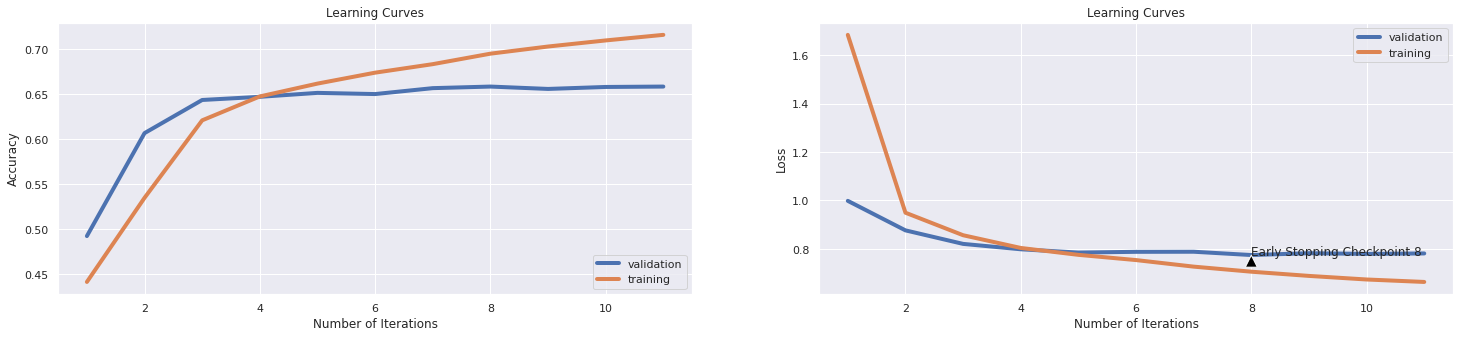

              precision    recall  f1-score
neutral        0.739247  0.774648  0.756534
antivax        0.520000  0.043919  0.080997
provax         0.581946  0.720955  0.644035
macro avg      0.613731  0.513174  0.493855
weighted avg   0.647323  0.658195  0.623506


**Accuracy: 0.65819** 



Total time: 30.78 seconds


**Grid Search: 2, Type: LSTM, Hidden size: 128, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.005, Schelduler: None**

Training accuracy scores: [0.6343264897346019, 0.6894091136705057, 0.7212694041061593, 0.7450550826239359, 0.7844892338507762, 0.8214196294441662, 0.8733099649474211]
Validation accuracy scores: [0.6713409290096407, 0.6914986853637161, 0.696319018404908, 0.7028921998247152, 0.7037686240140227, 0.6985100788781771, 0.703330411919369]
Training f1 scores: [0.5993699703579003, 0.6741121665925771, 0.7123577855307925, 0.7391911445306917, 0.7809146060912656, 0.8197379368312515, 0.8727870295408747]
Validation f1 scores: [0.6325128303783139, 0.6865983595425535, 0.7010040665177675, 0.6950708804801675, 0.7051593560696293, 0.6917894631581017, 0.7040149941887593]
Training losses: [0.7987699022293091, 0.7021768310070038, 0.6480952749252319, 0.6025186593532562, 0.5242730884552002, 0.4426638150215149, 0.32777014780044555]
Validation losses: [0.7270752257770963, 0.6846960054503547, 0.6819375786516402, 0.6789101229773628, 0.7006355739302106, 0.7353502048386468, 0.8562325868341658]


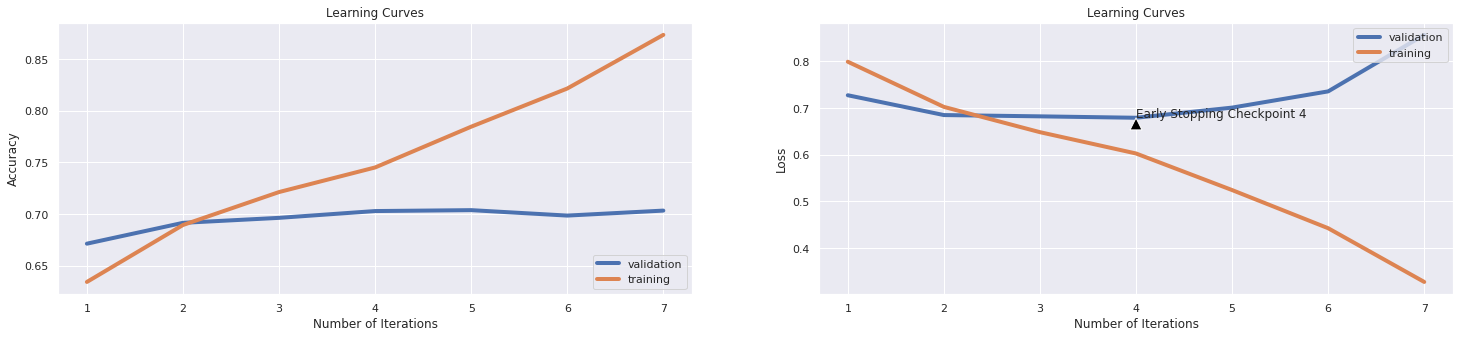

              precision    recall  f1-score
neutral        0.824895  0.734272  0.776950
antivax        0.494424  0.449324  0.470796
provax         0.647887  0.749186  0.694864
macro avg      0.655735  0.644261  0.647537
weighted avg   0.710590  0.703330  0.704109


**Accuracy: 0.70333** 



Total time: 19.59 seconds


**Grid Search: 3, Type: LSTM, Hidden size: 128, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5904481722583875, 0.6470330495743616, 0.6680020030045067, 0.6766399599399099, 0.6867801702553831, 0.6934777165748623, 0.7011141712568854, 0.7083124687030545, 0.7150100150225338, 0.7237731597396094, 0.7264646970455684, 0.7337255883825738, 0.736730095142714, 0.7468703054581873, 0.7521281922884326]
Validation accuracy scores: [0.6362839614373357, 0.6581945661700263, 0.6709027169149868, 0.6779141104294478, 0.6757230499561788, 0.6805433829973707, 0.684487291849255, 0.6805433829973707, 0.6919368974583698, 0.6928133216476775, 0.6932515337423313, 0.6910604732690623, 0.6989482909728308, 0.7002629272567923, 0.6998247151621385]
Training f1 scores: [0.5419725398014484, 0.6175885293914205, 0.6473349359153912, 0.6594740278885827, 0.6704720000281397, 0.6793441426020138, 0.6879513279988905, 0.6964026982123042, 0.7046549587955442, 0.7140514611928495, 0.7172138080841396, 0.7253296365564303, 0.7300636914790503, 0.7403898583541925, 0.7467226358514569]
Validation f1 scores: [0.

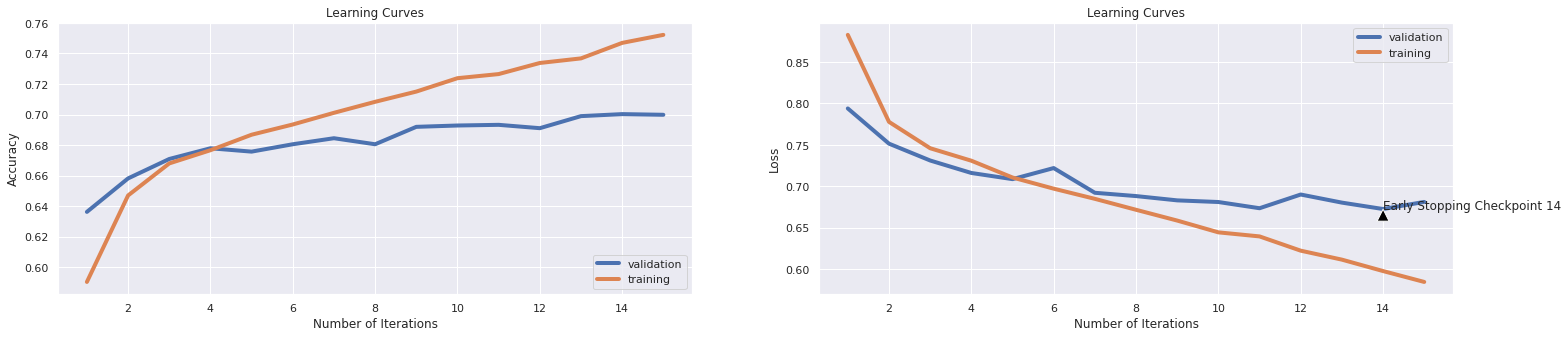

              precision    recall  f1-score
neutral        0.788555  0.763380  0.775763
antivax        0.650602  0.182432  0.284960
provax         0.625000  0.792617  0.698899
macro avg      0.688052  0.579476  0.586541
weighted avg   0.704651  0.699825  0.681079


**Accuracy: 0.69982** 



Total time: 41.84 seconds


**Grid Search: 4, Type: GRU, Hidden size: 128, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.1, Schelduler: Exponential**

Training accuracy scores: [0.44698297446169255, 0.49655733600400603, 0.5351151727591387, 0.5924511767651477, 0.6416499749624437, 0.6599899849774662, 0.674699549323986, 0.6904106159238859, 0.699549323985979, 0.706935403104657, 0.7099399098647972]
Validation accuracy scores: [0.46669588080631025, 0.4886064855390009, 0.5105170902716915, 0.6235758106923751, 0.6538124452234881, 0.5985977212971078, 0.6463628396143734, 0.6524978089395267, 0.6507449605609115, 0.6511831726555652, 0.6538124452234881]
Training f1 scores: [0.33730213777318585, 0.42102613945016626, 0.4798603085787882, 0.5473851661136905, 0.6015398258478863, 0.6217420748119724, 0.6397434659184228, 0.6549730928910309, 0.6660678137508365, 0.6760723913447908, 0.6777088106030794]
Validation f1 scores: [0.2972341224084841, 0.37524110917508097, 0.44376725688982743, 0.5824919658210271, 0.6142074353994942, 0.5402854304513227, 0.6087814195643966, 0.6146494698128033, 0.6138142816317207, 0.6081493578101982, 0.6160849221886858]
Training losses:

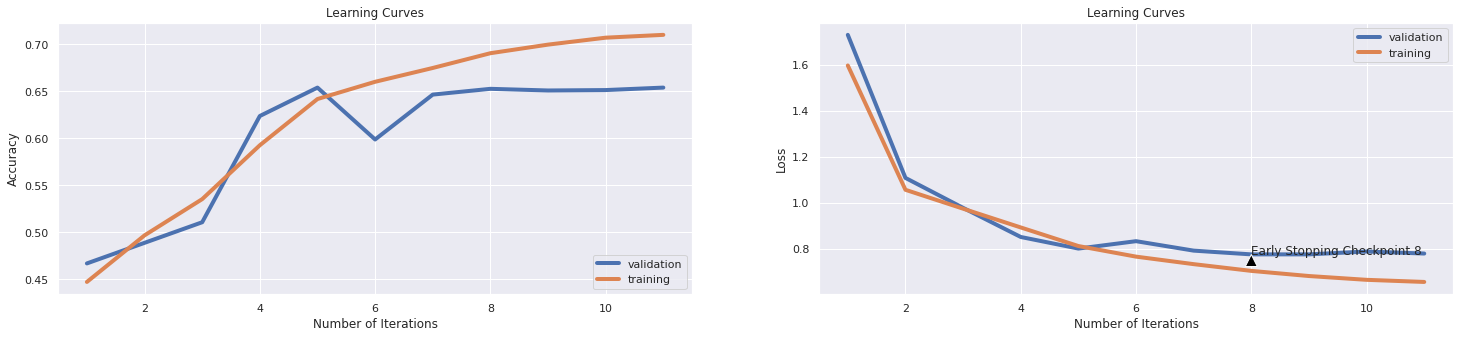

              precision    recall  f1-score
neutral        0.732970  0.757746  0.745152
antivax        0.421053  0.027027  0.050794
provax         0.582616  0.735071  0.650024
macro avg      0.578880  0.506615  0.481990
weighted avg   0.631829  0.653812  0.616693


**Accuracy: 0.65381** 



Total time: 30.71 seconds


**Grid Search: 5, Type: GRU, Hidden size: 128, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.005, Schelduler: None**

Training accuracy scores: [0.6302578868302454, 0.6915373059589384, 0.7195167751627441, 0.7508137205808713, 0.799949924887331, 0.8587255883825738]
Validation accuracy scores: [0.6906222611744084, 0.6858019281332165, 0.6932515337423313, 0.6954425942156004, 0.6928133216476775, 0.694127957931639]
Training f1 scores: [0.5989563219130143, 0.6789453749996828, 0.7110508916896671, 0.7456485607789741, 0.7984545653835259, 0.8578482197543027]
Validation f1 scores: [0.6689339114085207, 0.6591785631404762, 0.6974153783241366, 0.6932089717449818, 0.6803742156283613, 0.6872191722630846]
Training losses: [0.8178177461624145, 0.7042446346282959, 0.6510234789848328, 0.5910941150188446, 0.49359494805335996, 0.37229824686050417]
Validation losses: [0.7222892310884264, 0.7179868419965109, 0.6944505241182115, 0.7010558545589447, 0.7921222382121615, 0.8243309160073599]


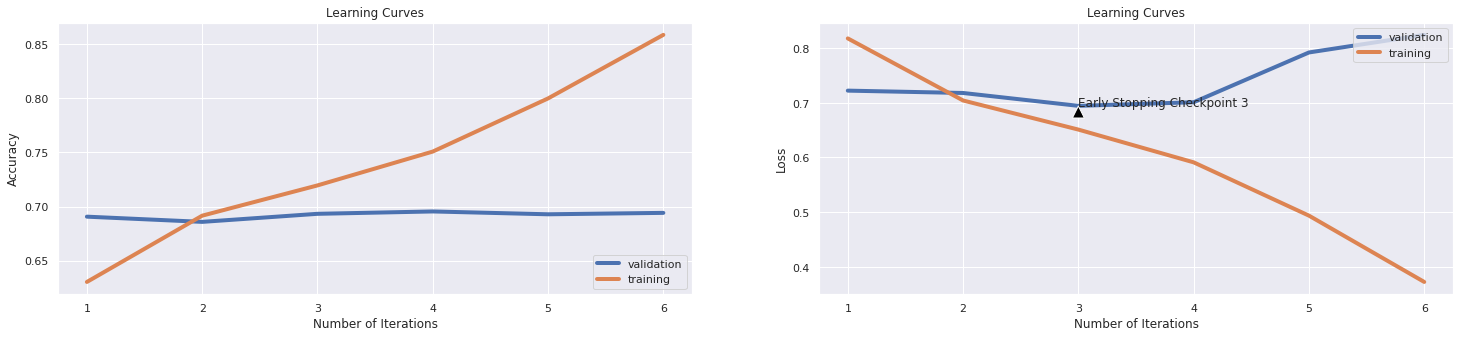

              precision    recall  f1-score
neutral        0.733733  0.804695  0.767577
antivax        0.512712  0.408784  0.454887
provax         0.690205  0.657980  0.673708
macro avg      0.645550  0.623820  0.632057
weighted avg   0.687497  0.694128  0.689133


**Accuracy: 0.69413** 



Total time: 16.90 seconds


**Grid Search: 6, Type: GRU, Hidden size: 128, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.6039684526790186, 0.6542313470205308, 0.6715698547821732, 0.6808337506259389, 0.6878442663995994, 0.6933525287931898, 0.6991737606409615, 0.7053705558337506, 0.7132573860791187, 0.7155733600400601, 0.7213319979969955, 0.7270906359539309, 0.7296569854782173, 0.7344141211817726, 0.7444917376064096]
Validation accuracy scores: [0.6406660823838738, 0.6577563540753725, 0.661262050832603, 0.6643295354951797, 0.670464504820333, 0.6757230499561788, 0.6831726555652936, 0.694127957931639, 0.6950043821209465, 0.7002629272567923, 0.6914986853637161, 0.6919368974583698, 0.6976336546888694, 0.703330411919369, 0.7068361086765995]
Training f1 scores: [0.5639675648897323, 0.6318290656674783, 0.6518347606674255, 0.6626275829803234, 0.6730915290813382, 0.6784171362522728, 0.6851796295814192, 0.6924894753335653, 0.7027215496870229, 0.7063400587020455, 0.7118451038778858, 0.7188159169996875, 0.7216031267105588, 0.7274800731881009, 0.7384149596262363]
Validation f1 scores: [0.62

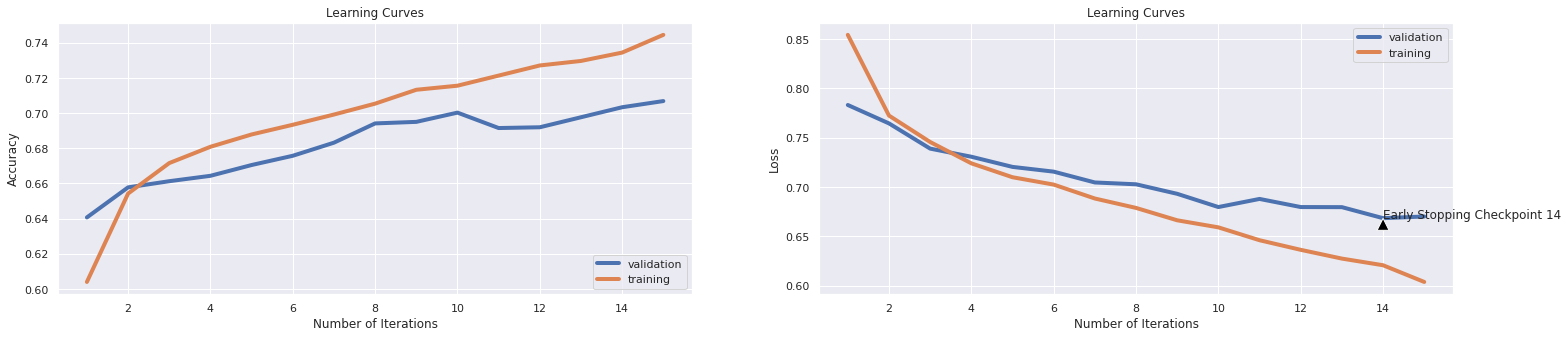

              precision    recall  f1-score
neutral        0.795299  0.762441  0.778523
antivax        0.578947  0.334459  0.423983
provax         0.644037  0.762215  0.698160
macro avg      0.672761  0.619705  0.633555
weighted avg   0.706187  0.706836  0.700102


**Accuracy: 0.70684** 



Total time: 41.44 seconds


**Grid Search: 7, Type: Vanilla, Hidden size: 128, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.1, Schelduler: Exponential**

Training accuracy scores: [0.41017776664997496, 0.42726589884827243, 0.4225087631447171, 0.4531797696544817, 0.4735227841762644, 0.49555583375062595, 0.5087631447170756, 0.517964446670005, 0.5306084126189284, 0.5317351026539809, 0.5371807711567351, 0.5458187280921382, 0.5471331997996995, 0.5471331997996995, 0.5524536805207811]
Validation accuracy scores: [0.45311130587204207, 0.4671340929009641, 0.46669588080631025, 0.46757230499561786, 0.46669588080631025, 0.5035056967572304, 0.5135845749342682, 0.5214723926380368, 0.521034180543383, 0.5219106047326906, 0.5311130587204207, 0.5297984224364592, 0.5319894829097284, 0.5385626643295355, 0.5381244522348817]
Training f1 scores: [0.3724672103924929, 0.3523811963184205, 0.3184489756047567, 0.35727876666348524, 0.40867228073499073, 0.44295691587075725, 0.46215282273396296, 0.4701937480401362, 0.490603222152444, 0.4870262657615716, 0.4960313575053099, 0.507212138529447, 0.5100252198362375, 0.509181392524512, 0.5149273335397867]
Validation f1 sco

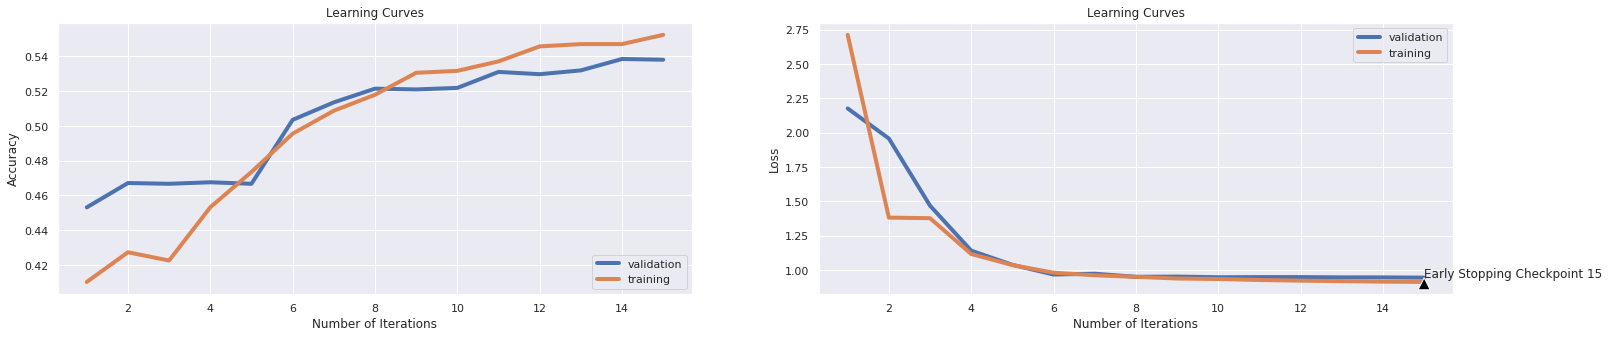

              precision    recall  f1-score
neutral        0.566188  0.666667  0.612333
antivax        0.000000  0.000000  0.000000
provax         0.503891  0.562432  0.531555
macro avg      0.356693  0.409700  0.381296
weighted avg   0.467605  0.538124  0.500305


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Accuracy: 0.53812** 



Total time: 35.53 seconds


**Grid Search: 8, Type: Vanilla, Hidden size: 128, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.005, Schelduler: None**

Training accuracy scores: [0.5632198297446169, 0.6092263395092639, 0.6245618427641462, 0.6325738607911868, 0.6354531797696544, 0.6439659489233851, 0.6480971457185779, 0.6489108662994492, 0.6504757135703555, 0.6562969454181272]
Validation accuracy scores: [0.6056091148115688, 0.6086765994741455, 0.619193689745837, 0.6292725679228747, 0.6183172655565293, 0.6358457493426819, 0.6432953549517967, 0.6275197195442594, 0.6205083260297984, 0.6362839614373357]
Training f1 scores: [0.5329130322346552, 0.5849990177507232, 0.5998477399784329, 0.6112904168475307, 0.6163906037821392, 0.6259495923490032, 0.6293316595940176, 0.6309574719620187, 0.632071079590199, 0.6388721866488478]
Validation f1 scores: [0.5774113263162822, 0.5683221228202279, 0.6004688977929425, 0.5966781483260644, 0.6070420823522658, 0.6061932979511151, 0.6253419131313053, 0.6258401730743425, 0.5987913000460127, 0.6277360182799162]
Training losses: [0.966404676914215, 0.8400696296691894, 0.8240128955841064, 0.8084589705467224, 0.804

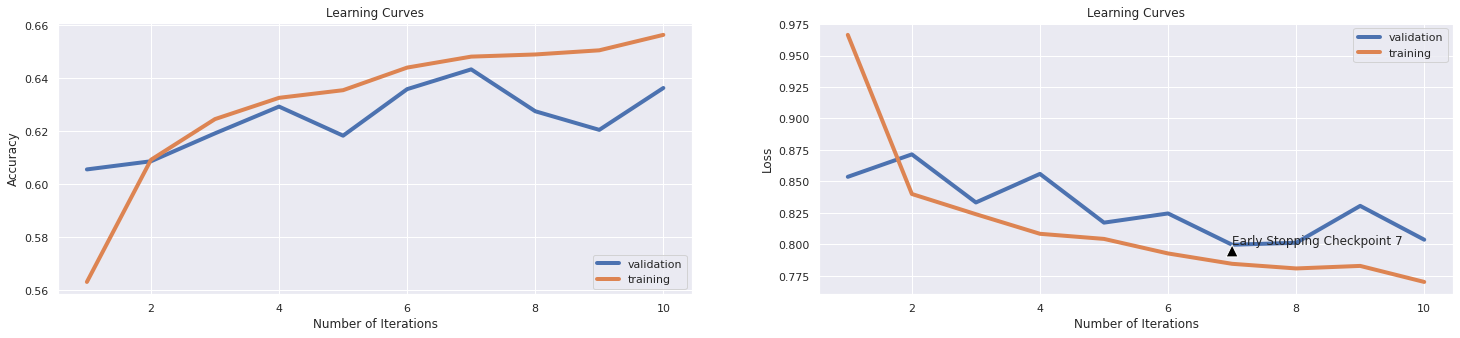

              precision    recall  f1-score
neutral        0.740814  0.700469  0.720077
antivax        0.346154  0.212838  0.263598
provax         0.588289  0.698154  0.638530
macro avg      0.558419  0.537154  0.540735
weighted avg   0.628064  0.636284  0.627955


**Accuracy: 0.63628** 



Total time: 23.71 seconds


**Grid Search: 9, Type: Vanilla, Hidden size: 128, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5878192288432649, 0.6328868302453681, 0.6437781672508763, 0.6497245868803205, 0.6605533299949925, 0.6666249374061092, 0.6654356534802204, 0.6775162744116174, 0.6766399599399099]
Validation accuracy scores: [0.6275197195442594, 0.6459246275197196, 0.6450482033304119, 0.6503067484662577, 0.6599474145486416, 0.6573181419807187, 0.6411042944785276, 0.6419807186678352, 0.6432953549517967]
Training f1 scores: [0.5455448677941541, 0.606619004492679, 0.6211026420750168, 0.6281257885485652, 0.642555110473722, 0.6492796508848843, 0.6493604053467269, 0.6617156928448135, 0.6619239920948229]
Validation f1 scores: [0.5866456639731176, 0.6348344858594392, 0.6078104957258258, 0.6348266833242229, 0.6412407944742224, 0.6428542152601265, 0.6193977584049518, 0.6199368808468784, 0.6282065524455107]
Training losses: [0.8694209461212158, 0.7991030859947205, 0.7815988335609436, 0.7678056292533875, 0.7581285862922669, 0.7510064177513123, 0.7463292245864868, 0.735511387348175, 0.731

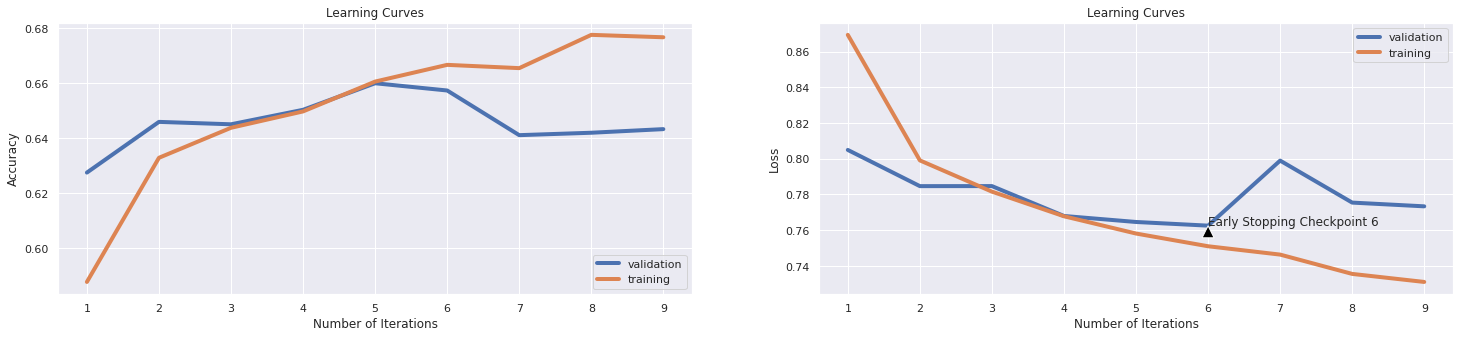

              precision    recall  f1-score
neutral        0.737639  0.686385  0.711089
antivax        0.452174  0.175676  0.253041
provax         0.582483  0.743757  0.653314
macro avg      0.590765  0.535272  0.539148
weighted avg   0.637991  0.643295  0.628358


**Accuracy: 0.64330** 



Total time: 21.60 seconds

Best grid is: Grid Search: 6, Type: GRU, Hidden size: 128, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None



In [ ]:
param_grid = {
  'types': ['LSTM', 'GRU', 'Vanilla'],
  'hidden_dimensions': [128],
  'layers_info': [{'stacks': 2, 'skip': None}],
  'max_clip_norms': [5],
  'dropout_rates': [None],
  'encoding_stategies': ['LAST_STATES'],
  'bidirectional': True,
  'sequence_length': 50,
  'learning_rates': [{'val': 1e-1, 'schelduler': 'Exponential'}, {'val': 5e-3, 'schelduler': None}, {'val' : 3e-4, 'schelduler': None}],
  'classes': ['neutral', 'antivax', 'provax'],
  'batch_size': 128,
  'epochs': 15,
  'early_stopping_patience': 3,
  'L2_reg': 0,
  'accuracy_threshold': 0.68
}

customGridSearch(param_grid, glove_training_set, glove_validation_set, embedding_matrix)

### **Hidden size evaluation : Small hidden size vs Medium hidden size vs Large hidden size**

**Grid Search: 1, Type: LSTM, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5781171757636455, 0.6403980971457186, 0.6610540811216825, 0.6720706059088633, 0.6825237856785178, 0.6887205808713069, 0.6921006509764647, 0.698798197295944, 0.7043690535803706, 0.7107536304456685, 0.7141337005508263, 0.7181397095643465, 0.7222083124687031, 0.7252128192288433, 0.7312218327491237]
Validation accuracy scores: [0.6248904469763366, 0.6468010517090271, 0.6617002629272568, 0.6709027169149868, 0.6730937773882559, 0.6822962313759859, 0.6822962313759859, 0.6910604732690623, 0.6862401402278703, 0.6875547765118317, 0.6945661700262927, 0.6976336546888694, 0.6980718667835232, 0.6993865030674846, 0.7011393514461]
Training f1 scores: [0.531028947065704, 0.6008079047291086, 0.6370557044778591, 0.6513716643211432, 0.6662161198796922, 0.6727934976721172, 0.677160641619393, 0.6853249174459445, 0.691922688791638, 0.699225689662226, 0.7019709093374193, 0.7078197986513727, 0.7120951994365653, 0.7150065111002735, 0.7230873796380429]
Validation f1 scores: [0.580770

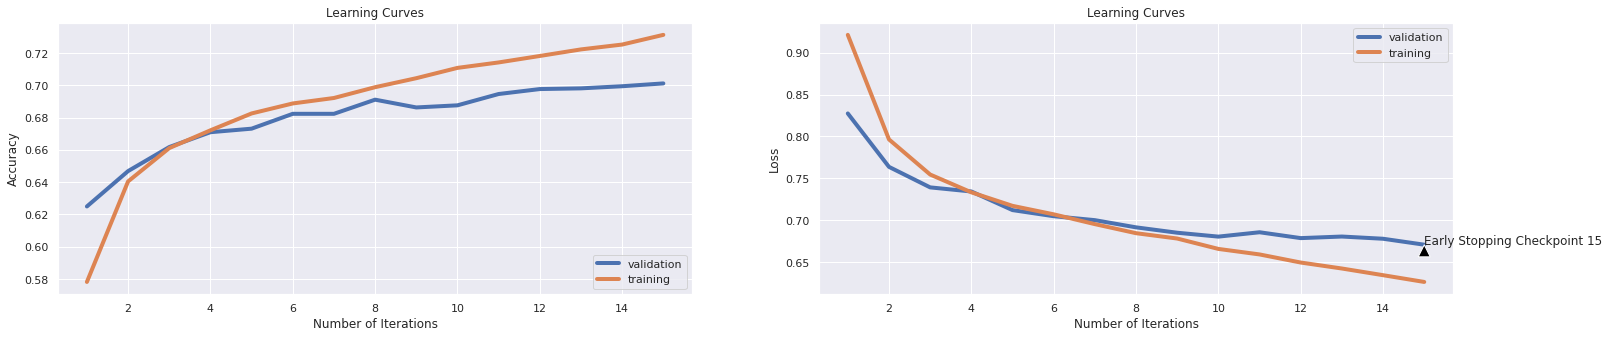

              precision    recall  f1-score
neutral        0.822529  0.726761  0.771685
antivax        0.514124  0.307432  0.384778
provax         0.631443  0.798046  0.705036
macro avg      0.656032  0.610746  0.620500
weighted avg   0.705405  0.701139  0.694600


**Accuracy: 0.70114** 



Total time: 39.27 seconds


**Grid Search: 2, Type: LSTM, Hidden size: 128, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5913870806209314, 0.6485978968452679, 0.6648097145718578, 0.6771407110665999, 0.6851527290936404, 0.6972333500250375, 0.7028042063094642, 0.7082498748122183, 0.7114421632448673, 0.7187030545818728, 0.7234601902854282, 0.7289058587881823, 0.7375438157235854, 0.7426139208813219, 0.7486855282924386]
Validation accuracy scores: [0.6358457493426819, 0.6546888694127958, 0.670464504820333, 0.6748466257668712, 0.6787905346187555, 0.6831726555652936, 0.686678352322524, 0.6923751095530236, 0.6919368974583698, 0.6831726555652936, 0.6919368974583698, 0.6976336546888694, 0.7055214723926381, 0.7015775635407537, 0.7059596844872918]
Training f1 scores: [0.5431466770691905, 0.6196771706545037, 0.6434835885938331, 0.660499957705687, 0.6695420342144955, 0.683827914192809, 0.691000756336971, 0.6965468214288701, 0.7008260683049435, 0.7087072131600504, 0.7144440230153206, 0.7209100894642704, 0.7300494588434496, 0.735645648641259, 0.7429897107968831]
Validation f1 scores: [0.5965

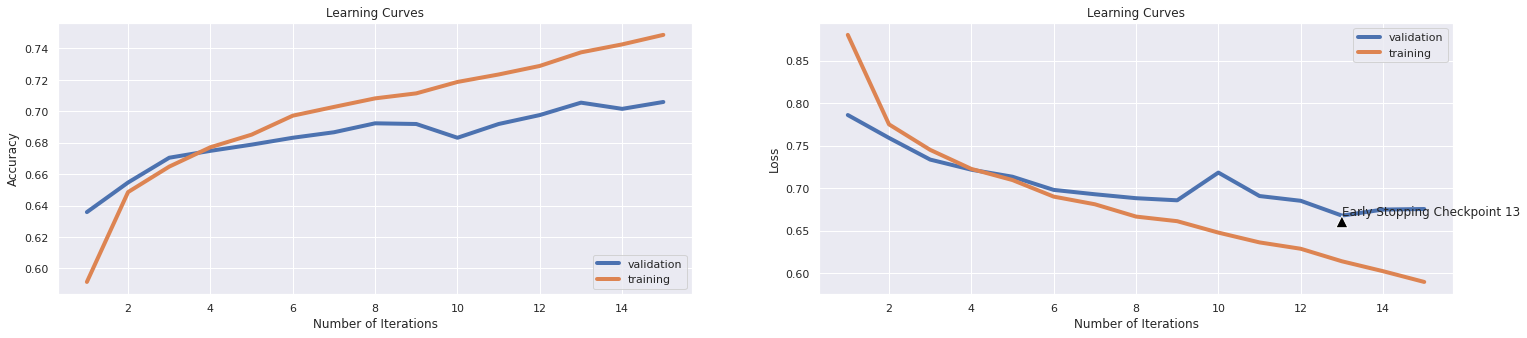

              precision    recall  f1-score
neutral        0.791304  0.769014  0.780000
antivax        0.559585  0.364865  0.441718
provax         0.648956  0.742671  0.692658
macro avg      0.666615  0.625517  0.638125
weighted avg   0.703797  0.705960  0.700871


**Accuracy: 0.70596** 



Total time: 41.65 seconds


**Grid Search: 3, Type: LSTM, Hidden size: 256, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5935778668002003, 0.651352028042063, 0.6720080120180271, 0.6799574361542313, 0.6889083625438157, 0.6991737606409615, 0.7085628442663996, 0.7184526790185278, 0.7247120681021533, 0.7329118678017026, 0.739922383575363, 0.7461817726589884, 0.7586379569354031, 0.7713445167751627]
Validation accuracy scores: [0.6389132340052586, 0.6660823838737949, 0.6717791411042945, 0.6748466257668712, 0.6779141104294478, 0.6827344434706398, 0.6862401402278703, 0.6858019281332165, 0.6827344434706398, 0.6853637160385626, 0.6928133216476775, 0.6950043821209465, 0.694127957931639, 0.6923751095530236]
Training f1 scores: [0.5430823892504746, 0.6272004577628699, 0.6539182630248345, 0.6642565825740945, 0.6736767753811, 0.687184489446112, 0.6986434493905167, 0.7088205550353394, 0.7175035879314116, 0.7250298598561506, 0.7336894765080315, 0.7412838623381884, 0.7539951565704436, 0.7674415325148234]
Validation f1 scores: [0.596923038227201, 0.6421171582190437, 0.6575716375812735, 0.649736

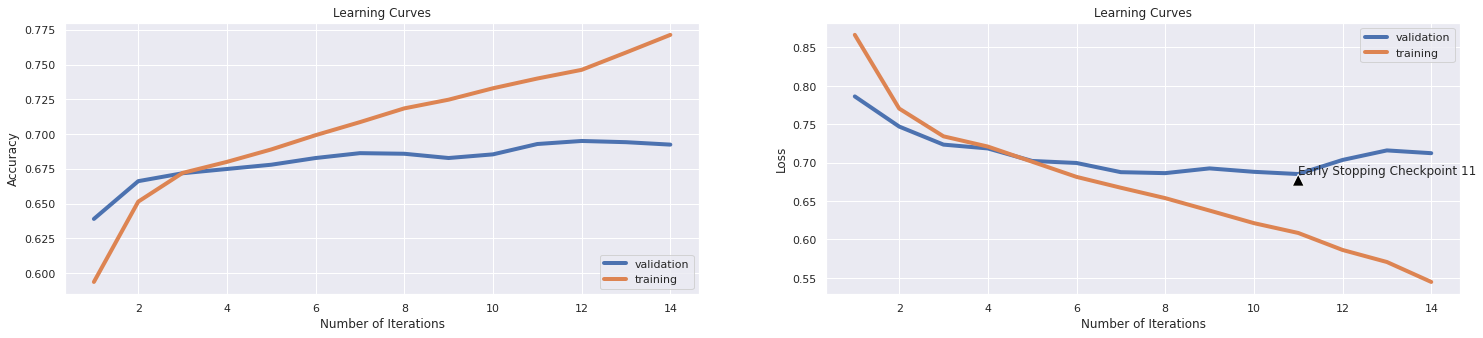

              precision    recall  f1-score
neutral        0.821121  0.715493  0.764676
antivax        0.525424  0.314189  0.393235
provax         0.615973  0.787188  0.691134
macro avg      0.654172  0.605623  0.616348
weighted avg   0.699969  0.692375  0.686815


**Accuracy: 0.69238** 



Total time: 46.80 seconds


**Grid Search: 4, Type: GRU, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5628442663995994, 0.6407110665998998, 0.6618678017025539, 0.6730721081622434, 0.6819604406609915, 0.6849023535302955, 0.6915998998497747, 0.6981096644967452, 0.6989859789684527, 0.7065598397596394, 0.7125688532799199, 0.7133825738607912, 0.7202679018527791, 0.7211442163244868, 0.725150225338007]
Validation accuracy scores: [0.6218229623137599, 0.647239263803681, 0.656441717791411, 0.6643295354951797, 0.6730937773882559, 0.6783523225241017, 0.6849255039439088, 0.6853637160385626, 0.6875547765118317, 0.6849255039439088, 0.6831726555652936, 0.6958808063102542, 0.6945661700262927, 0.6985100788781771, 0.7011393514461]
Training f1 scores: [0.5158989153874539, 0.6057684958380206, 0.636818739939996, 0.6520161791452183, 0.6644048325368592, 0.6681436332191798, 0.6750799908093472, 0.6823522408441929, 0.6854461871759316, 0.6935314389775887, 0.7015241553670759, 0.701274267281085, 0.709931302912273, 0.7107370110431631, 0.7151869250974986]
Validation f1 scores: [0.5803851

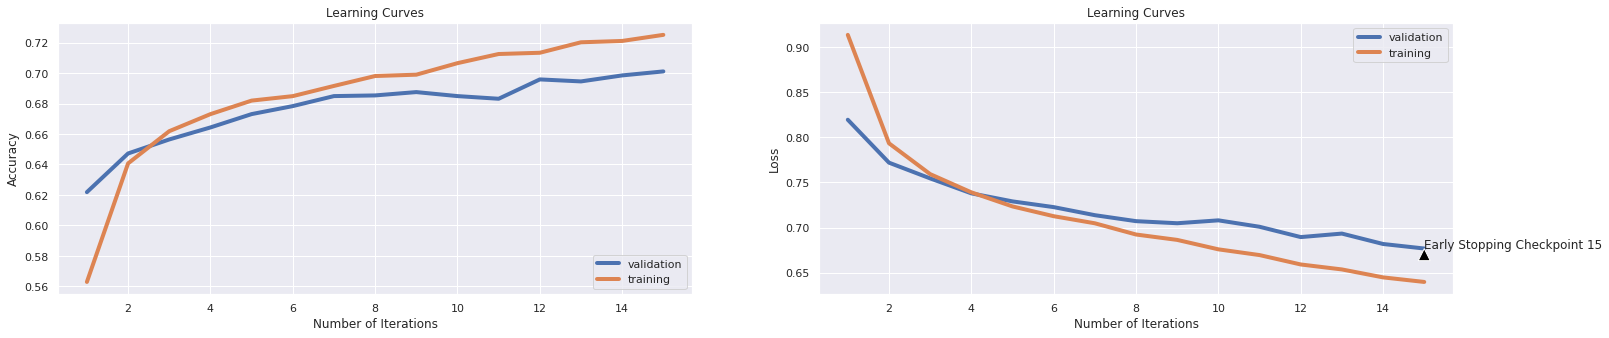

              precision    recall  f1-score
neutral        0.787440  0.765258  0.776190
antivax        0.505882  0.435811  0.468240
provax         0.661290  0.712269  0.685834
macro avg      0.651537  0.637779  0.643421
weighted avg   0.700006  0.701139  0.699779


**Accuracy: 0.70114** 



Total time: 37.99 seconds


**Grid Search: 5, Type: GRU, Hidden size: 128, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5930771156735103, 0.654043565348022, 0.6644967451176765, 0.6777666499749625, 0.6860916374561843, 0.6942288432648973, 0.6997371056584877, 0.7059339008512769, 0.710878818227341, 0.7136955433149724, 0.7205808713069605, 0.7298447671507261, 0.7332874311467201, 0.7372934401602403, 0.7446169253880821]
Validation accuracy scores: [0.6323400525854513, 0.6617002629272568, 0.6691498685363716, 0.6757230499561788, 0.6814198071866784, 0.6884312007011394, 0.677475898334794, 0.6888694127957932, 0.694127957931639, 0.6945661700262927, 0.7020157756354075, 0.6879929886064855, 0.7011393514461, 0.7042068361086766, 0.7015775635407537]
Training f1 scores: [0.5488066248647844, 0.6300354294859215, 0.6428236076716485, 0.659460649178168, 0.67048745288257, 0.6794713760221526, 0.6855449745974764, 0.6940516634948161, 0.699439032673321, 0.7031844546703081, 0.7116618471981746, 0.7214143776745385, 0.725495452550442, 0.7305613068211753, 0.7379337554550025]
Validation f1 scores: [0.5933037021

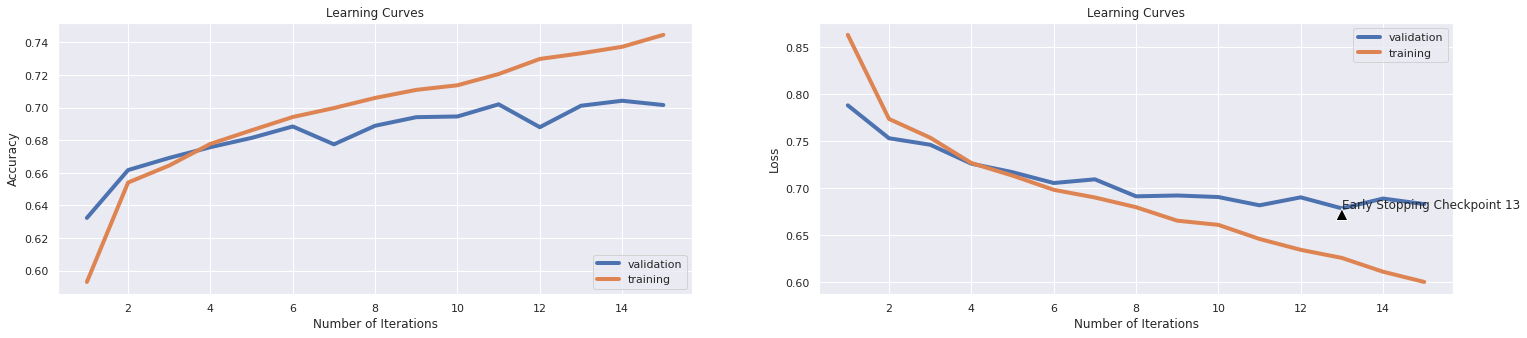

              precision    recall  f1-score
neutral        0.812178  0.738967  0.773845
antivax        0.622642  0.222973  0.328358
provax         0.619718  0.812161  0.703008
macro avg      0.684846  0.591367  0.601737
weighted avg   0.709917  0.701578  0.687471


**Accuracy: 0.70158** 



Total time: 41.36 seconds


**Grid Search: 6, Type: GRU, Hidden size: 256, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.6097896845267902, 0.6514772158237356, 0.6699424136204306, 0.6851527290936404, 0.6925388082123185, 0.7025538307461192, 0.7113169754631948, 0.7129444166249375, 0.7213945918878317, 0.7285302954431647, 0.7373560340510766, 0.7449924887330996, 0.7551326990485728, 0.76771407110666, 0.7728467701552328]
Validation accuracy scores: [0.64943032427695, 0.6621384750219106, 0.6752848378615249, 0.677475898334794, 0.6884312007011394, 0.6906222611744084, 0.6884312007011394, 0.6871165644171779, 0.6862401402278703, 0.6976336546888694, 0.6967572304995618, 0.7007011393514461, 0.703330411919369, 0.7072743207712533, 0.7002629272567923]
Training f1 scores: [0.5720413584756969, 0.6298597166084113, 0.6507128268688219, 0.6677045304892817, 0.6766245979436524, 0.6897014638654779, 0.7001443785098904, 0.702732836118398, 0.7127947792902712, 0.7197665343228493, 0.729941637794853, 0.7393458254966881, 0.7494742725388507, 0.7633656988915117, 0.7677276946854088]
Validation f1 scores: [0.624916

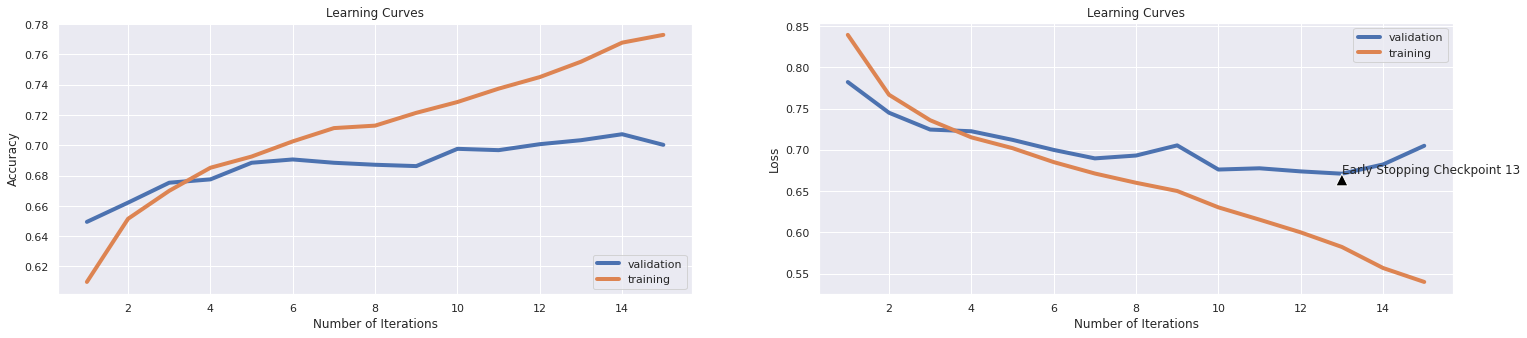

              precision    recall  f1-score
neutral        0.818757  0.729577  0.771599
antivax        0.542105  0.347973  0.423868
provax         0.628171  0.779587  0.695736
macro avg      0.663011  0.619046  0.630401
weighted avg   0.705953  0.700263  0.695877


**Accuracy: 0.70026** 



Total time: 48.43 seconds


**Grid Search: 7, Type: Vanilla, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5553329994992489, 0.6206810215322984, 0.6380821231847772, 0.6492238357536304, 0.6551076614922383, 0.6567351026539809, 0.6681271907861792, 0.6675012518778167, 0.6731347020530796, 0.6743865798698047, 0.6825863795693541, 0.6859664496745118, 0.6909113670505759, 0.6941662493740611, 0.696106659989985]
Validation accuracy scores: [0.6038562664329535, 0.6319018404907976, 0.6367221735319895, 0.6441717791411042, 0.6516213847502191, 0.6498685363716039, 0.6481156879929886, 0.6577563540753725, 0.6524978089395267, 0.6603856266432954, 0.6656441717791411, 0.6673970201577564, 0.6748466257668712, 0.6713409290096407, 0.6761612620508326]
Training f1 scores: [0.5096539923801547, 0.5841907115445599, 0.6141202556178481, 0.6272035723149308, 0.6358868518269813, 0.6369114674529164, 0.6489212514865158, 0.6502547671638751, 0.6569255217680693, 0.6585109725809662, 0.6664348474434407, 0.6705807864273402, 0.676782206765846, 0.6800050843931222, 0.6818622455655806]
Validation f1 scores: [0.

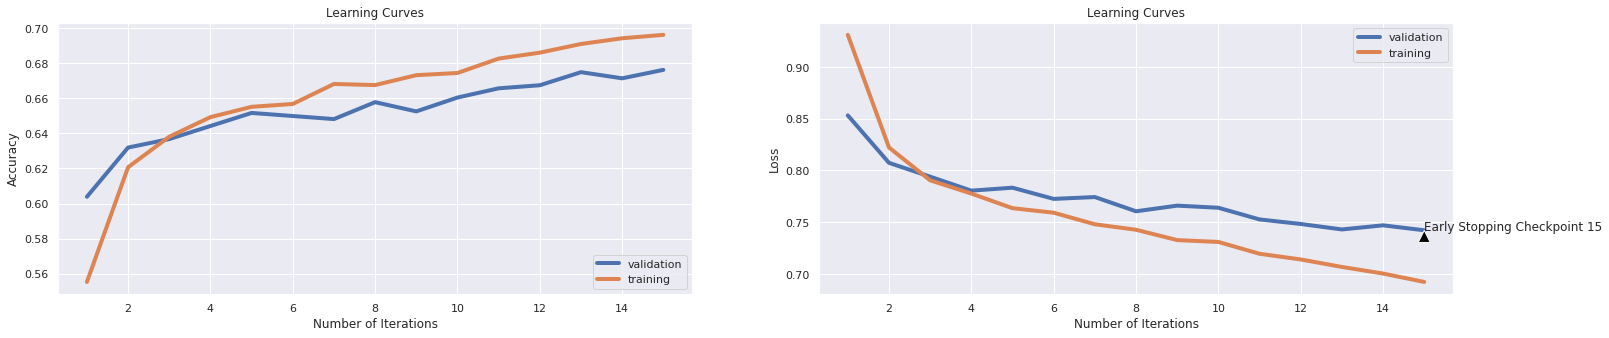

              precision    recall  f1-score
neutral        0.708436  0.812207  0.756780
antivax        0.503937  0.216216  0.302600
provax         0.657388  0.666667  0.661995
macro avg      0.623253  0.565030  0.573792
weighted avg   0.661307  0.676161  0.659613


**Accuracy: 0.67616** 



Total time: 34.37 seconds


**Grid Search: 8, Type: Vanilla, Hidden size: 128, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.581685027541312, 0.6352028042063095, 0.6401477215823735, 0.6516649974962444, 0.6628067100650976, 0.6641837756634953, 0.6703179769654481, 0.6728217325988983, 0.676201802704056, 0.6790185277916875, 0.6860916374561843, 0.6897846770155233, 0.6958562844266399, 0.7020530796194292, 0.7056835252879319]
Validation accuracy scores: [0.6205083260297984, 0.6288343558282209, 0.6288343558282209, 0.6437335670464505, 0.6406660823838738, 0.6481156879929886, 0.6459246275197196, 0.6459246275197196, 0.6503067484662577, 0.6432953549517967, 0.6476774758983348, 0.6511831726555652, 0.6468010517090271, 0.6551270815074496, 0.6529360210341806]
Training f1 scores: [0.5405971293870083, 0.6075044190767077, 0.6184242652043915, 0.6306111989850361, 0.6446836824344514, 0.6473657576854264, 0.6543026214825243, 0.657355741900777, 0.6618736189637227, 0.6664022020150773, 0.6724611957770503, 0.6768338337247417, 0.6838627832224857, 0.6911006523440171, 0.6952431086309668]
Validation f1 scores: [0.5

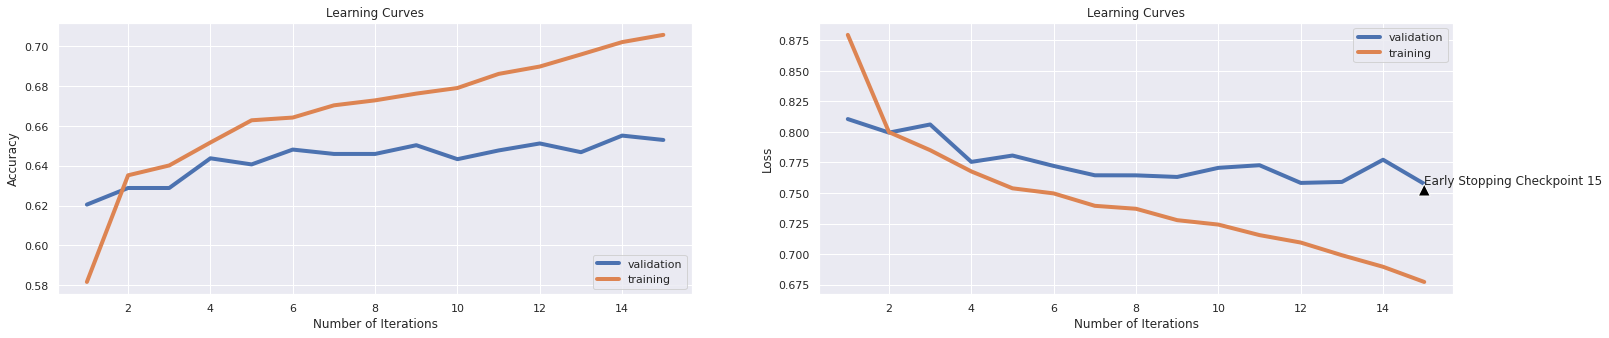

              precision    recall  f1-score
neutral        0.731022  0.732394  0.731707
antivax        0.487179  0.192568  0.276029
provax         0.594718  0.709012  0.646855
macro avg      0.604306  0.544658  0.551530
weighted avg   0.644381  0.652936  0.638355


**Accuracy: 0.65294** 



Total time: 35.48 seconds


**Grid Search: 9, Type: Vanilla, Hidden size: 256, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.596707561342013, 0.635327991987982, 0.6452178267401102, 0.6512268402603906, 0.6589884827240862, 0.6628067100650976, 0.6691286930395594, 0.6703805708562844, 0.6783299949924887, 0.6790185277916875]
Validation accuracy scores: [0.6248904469763366, 0.6305872042068361, 0.6275197195442594, 0.6419807186678352, 0.6415425065731815, 0.6419807186678352, 0.6419807186678352, 0.6529360210341806, 0.6174408413672218, 0.6446099912357581]
Training f1 scores: [0.5618495724077764, 0.6124200676158834, 0.6251994205022515, 0.6348587929818286, 0.6420531306843457, 0.6471674661440207, 0.6550806973901545, 0.6557116048339077, 0.6650136531018136, 0.6670883636053326]
Validation f1 scores: [0.5953786169644801, 0.6164493603381715, 0.5977394296324443, 0.617458236234681, 0.6293146171644833, 0.6374420263592517, 0.6317896587287288, 0.6300953738437958, 0.5962175024345062, 0.625287927960658]
Training losses: [0.8645105657577514, 0.8022579298019409, 0.7881729588508606, 0.7726731767654419, 0.7622

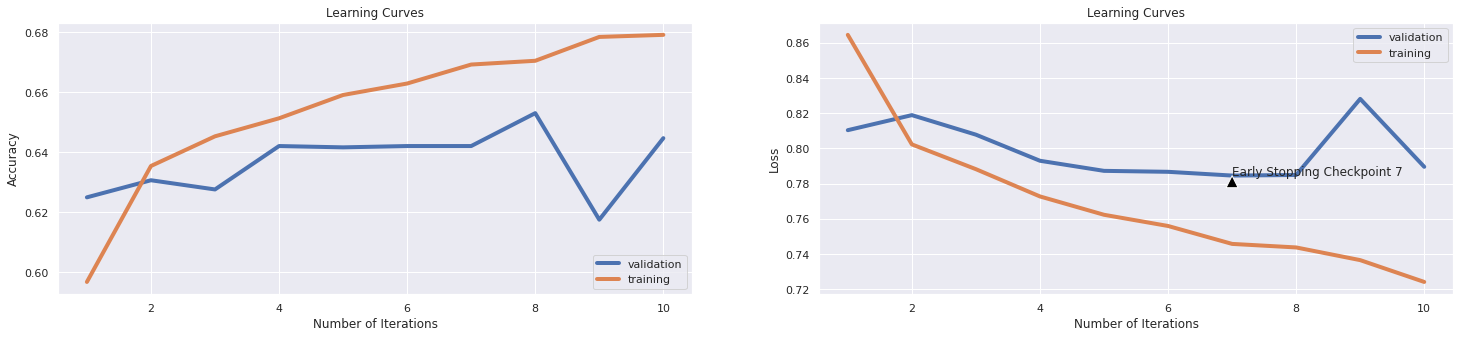

              precision    recall  f1-score
neutral        0.674201  0.812207  0.736797
antivax        0.500000  0.202703  0.288462
provax         0.621160  0.592834  0.606667
macro avg      0.598454  0.535914  0.543975
weighted avg   0.630198  0.644610  0.626123


**Accuracy: 0.64461** 



Total time: 27.72 seconds

Best grid is: Grid Search: 4, Type: GRU, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None



In [ ]:
param_grid = {
  'types': ['LSTM', 'GRU', 'Vanilla'],
  'hidden_dimensions': [64, 128, 256],
  'layers_info': [{'stacks': 2, 'skip': None}],
  'max_clip_norms': [5],
  'dropout_rates': [None],
  'encoding_stategies': ['LAST_STATES'],
  'bidirectional': True,
  'sequence_length': 50,
  'learning_rates': [{'val' : 3e-4, 'schelduler': None}],
  'classes': ['neutral', 'antivax', 'provax'],
  'batch_size': 128,
  'epochs': 15,
  'early_stopping_patience': 3,
  'L2_reg': 0,
  'accuracy_threshold': 0.68
}

customGridSearch(param_grid, glove_training_set, glove_validation_set, embedding_matrix)

### **Stacked layers & skip connections evaluation: 1 layer without skip connections vs 2 layers with and without skip connections vs 3 layers with and without skip connections vs 4 layers with skip connections**

**Grid Search: 1, Type: LSTM, Hidden size: 64, Stacks: 1, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5550826239359039, 0.6313845768652979, 0.6547946920380571, 0.664621932899349, 0.6735102653980971, 0.6775162744116174, 0.6874687030545819, 0.6942288432648973, 0.6972959439158738, 0.7024912368552829, 0.7064972458688032, 0.7102528793189785, 0.7113169754631948, 0.7169504256384577, 0.7201427140711066]
Validation accuracy scores: [0.6108676599474145, 0.6529360210341806, 0.6621384750219106, 0.6709027169149868, 0.6765994741454864, 0.677475898334794, 0.6818580192813322, 0.6875547765118317, 0.6875547765118317, 0.686678352322524, 0.689307624890447, 0.6875547765118317, 0.6914986853637161, 0.6919368974583698, 0.6923751095530236]
Training f1 scores: [0.5150149899304968, 0.5912507428864537, 0.6265983682222993, 0.6424535633143027, 0.6519773352094249, 0.6596254134121585, 0.6705152445018053, 0.6787545288475053, 0.6830530667478437, 0.6890586495015816, 0.6931899081850375, 0.6981019793259324, 0.6990080436026187, 0.7059403103095807, 0.7086095337907958]
Validation f1 scores: [0.56

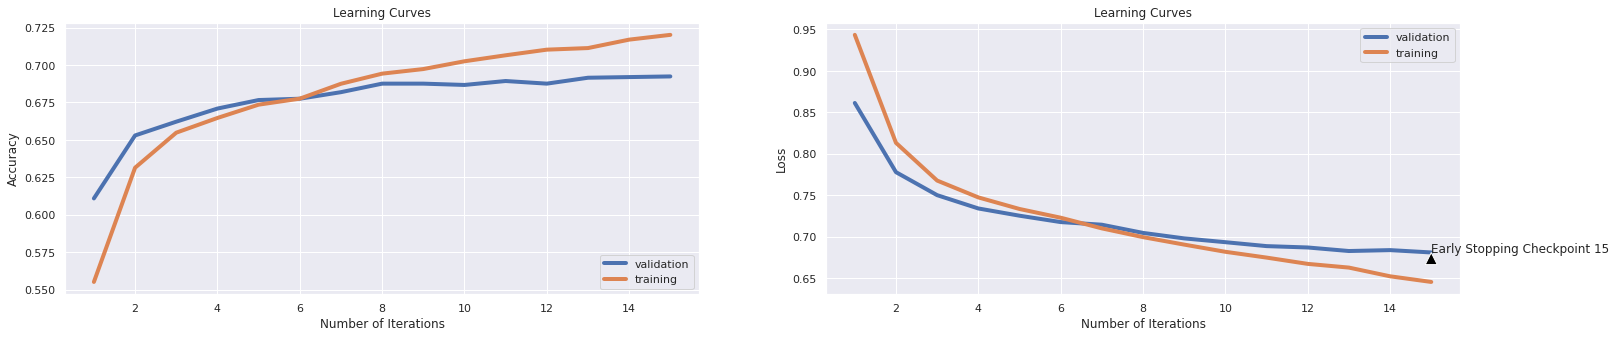

              precision    recall  f1-score
neutral        0.778203  0.764319  0.771198
antivax        0.526316  0.270270  0.357143
provax         0.632841  0.744843  0.684289
macro avg      0.645787  0.593144  0.604210
weighted avg   0.686863  0.692375  0.682415


**Accuracy: 0.69238** 



Total time: 23.34 seconds


**Grid Search: 2, Type: LSTM, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5668502754131197, 0.6424011016524788, 0.6648723084626941, 0.678893340010015, 0.6853405107661492, 0.6927891837756635, 0.6985478217325989, 0.699549323985979, 0.706434651977967, 0.7098147220831247, 0.7109414121181773, 0.7185778668002003, 0.7225212819228843, 0.7260891337005508, 0.7342263395092639]
Validation accuracy scores: [0.6301489921121823, 0.6511831726555652, 0.6643295354951797, 0.6700262927256793, 0.6722173531989483, 0.686678352322524, 0.689307624890447, 0.6836108676599474, 0.6950043821209465, 0.6871165644171779, 0.6936897458369851, 0.6954425942156004, 0.6928133216476775, 0.6967572304995618, 0.7024539877300614]
Training f1 scores: [0.5056242458283654, 0.6042248403038504, 0.6421568640051217, 0.6599250293920179, 0.6685573247123061, 0.6786579796673518, 0.6860552616240043, 0.6874849466705758, 0.6950844361415927, 0.6994807640258288, 0.7000533890859897, 0.709020594240859, 0.7128856104439529, 0.7174339408009153, 0.725983187032448]
Validation f1 scores: [0.58905

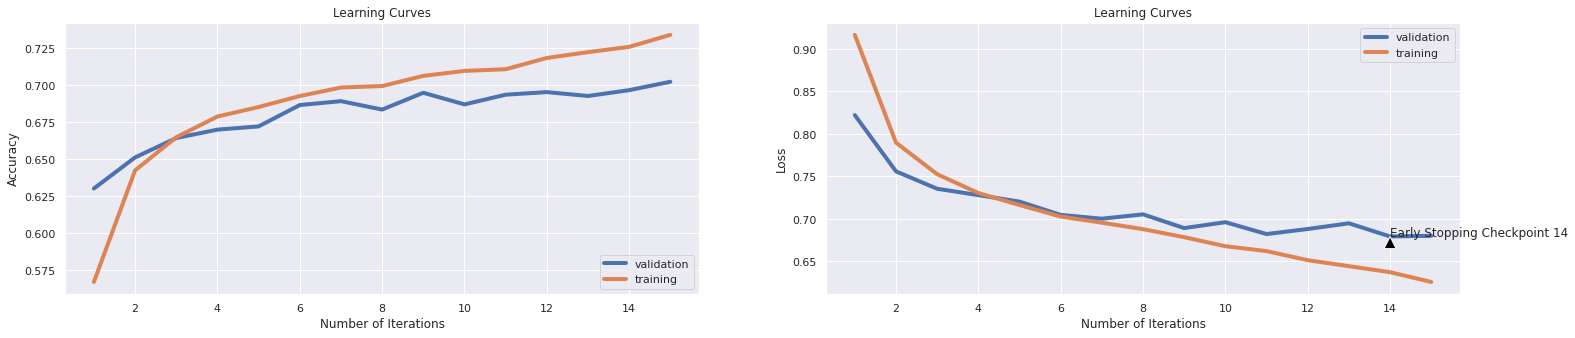

              precision    recall  f1-score
neutral        0.785645  0.760563  0.772901
antivax        0.621849  0.250000  0.356627
provax         0.635159  0.780673  0.700438
macro avg      0.680884  0.597079  0.609989
weighted avg   0.703664  0.702454  0.689660


**Accuracy: 0.70245** 



Total time: 39.65 seconds


**Grid Search: 3, Type: LSTM, Hidden size: 64, Stacks: 2, Skip layers: 2, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5418127190786179, 0.6385828743114672, 0.6621181772658988, 0.6747621432148222, 0.6820230345518278, 0.6902228342513771, 0.6984226339509264, 0.7029293940911367, 0.7086254381572359, 0.7135077616424637, 0.7133199799699549, 0.7182023034551828, 0.7232098147220831, 0.7252128192288433, 0.7297195793690536]
Validation accuracy scores: [0.6305872042068361, 0.6507449605609115, 0.6599474145486416, 0.6647677475898335, 0.6656441717791411, 0.6757230499561788, 0.6831726555652936, 0.686678352322524, 0.694127957931639, 0.686678352322524, 0.6932515337423313, 0.6936897458369851, 0.686678352322524, 0.6976336546888694, 0.6980718667835232]
Training f1 scores: [0.5086627639589317, 0.6084996925176078, 0.6426510868044153, 0.658560517999536, 0.6660149547146094, 0.6761094577499132, 0.6853296116164003, 0.6892857996391151, 0.6961555063139158, 0.7016412006528101, 0.7019381391951193, 0.7077084017893222, 0.7137177826535264, 0.714761751719095, 0.7205326038337123]
Validation f1 scores: [0.5934

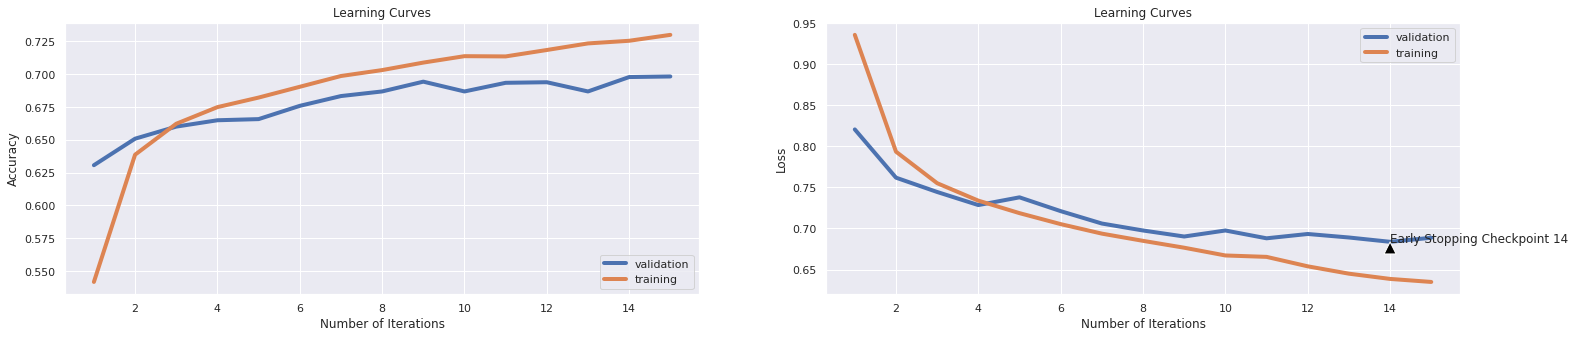

              precision    recall  f1-score
neutral        0.761644  0.783099  0.772222
antivax        0.527919  0.351351  0.421907
provax         0.661616  0.711183  0.685505
macro avg      0.650393  0.615211  0.626545
weighted avg   0.690957  0.698072  0.691784


**Accuracy: 0.69807** 



Total time: 40.39 seconds


**Grid Search: 4, Type: LSTM, Hidden size: 64, Stacks: 3, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5766775162744117, 0.6394591887831748, 0.6634952428642964, 0.6745117676514772, 0.682085628442664, 0.6897220831246871, 0.6946670005007511, 0.6977966950425638, 0.7024286429644466, 0.7100650976464697, 0.7128818227341012, 0.7188282423635454, 0.7206434651977967, 0.728592889334001, 0.7346019028542814]
Validation accuracy scores: [0.6297107800175284, 0.6560035056967572, 0.6577563540753725, 0.6735319894829097, 0.6787905346187555, 0.6818580192813322, 0.6792287467134093, 0.6814198071866784, 0.6928133216476775, 0.694127957931639, 0.6901840490797546, 0.6971954425942156, 0.6967572304995618, 0.7063978965819456, 0.7063978965819456]
Training f1 scores: [0.5235522610913496, 0.6037608074929144, 0.642370218871879, 0.6554505693853743, 0.6663211858982507, 0.6733701063899342, 0.6817078556085395, 0.6846621333854803, 0.6897031046139082, 0.6987857770580278, 0.7018807811793424, 0.7082527676974396, 0.7104236595952954, 0.7194634784078936, 0.7268679089917408]
Validation f1 scores: [0.58

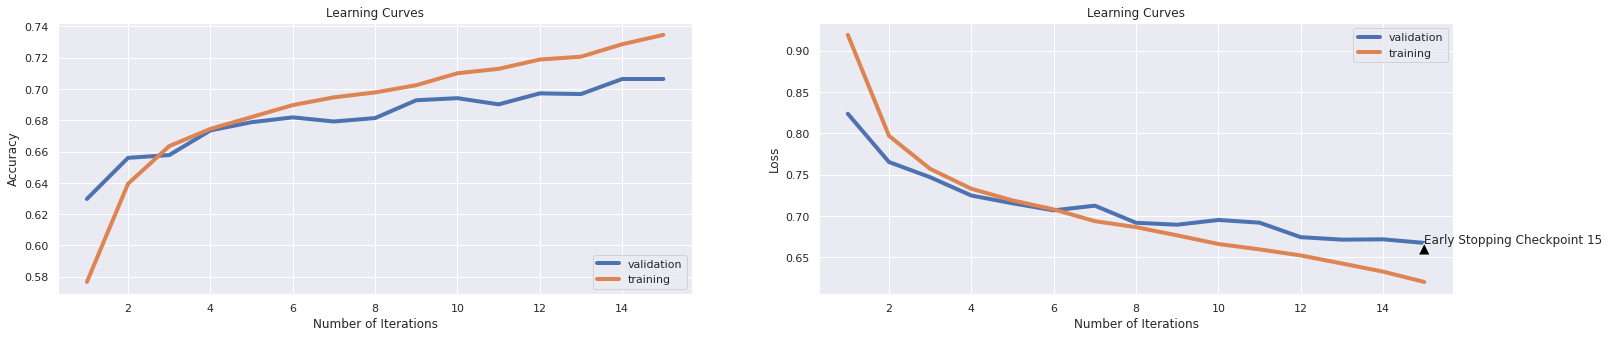

              precision    recall  f1-score
neutral        0.806484  0.747418  0.775828
antivax        0.531100  0.375000  0.439604
provax         0.649171  0.765472  0.702541
macro avg      0.662252  0.629297  0.639325
weighted avg   0.707274  0.706398  0.702638


**Accuracy: 0.70640** 



Total time: 55.60 seconds


**Grid Search: 5, Type: LSTM, Hidden size: 64, Stacks: 3, Skip layers: 1, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5641587381071608, 0.6501627441161743, 0.6700050075112669, 0.6782048072108162, 0.6942288432648973, 0.7030545818728092, 0.7128192288432649, 0.7148848272408613, 0.7266524787180771, 0.7312218327491237, 0.7395468202303456, 0.7487481221832749, 0.7579494241362043, 0.7640210315473209]
Validation accuracy scores: [0.621384750219106, 0.6586327782646801, 0.6687116564417178, 0.6695880806310254, 0.6700262927256793, 0.6858019281332165, 0.684487291849255, 0.6906222611744084, 0.6888694127957932, 0.6910604732690623, 0.7050832602979842, 0.7011393514461, 0.6993865030674846, 0.7094653812445223]
Training f1 scores: [0.5312196263066223, 0.6273391701005296, 0.6532956875568392, 0.662620722557192, 0.6818857000208408, 0.6901550435488712, 0.7013109949372134, 0.704399434825816, 0.7182137877753781, 0.7226179114254812, 0.732734608658556, 0.7423025756062219, 0.7522166984751213, 0.7590064488015302]
Validation f1 scores: [0.5928264753529566, 0.6403801439091814, 0.6637822268093784, 0.644290

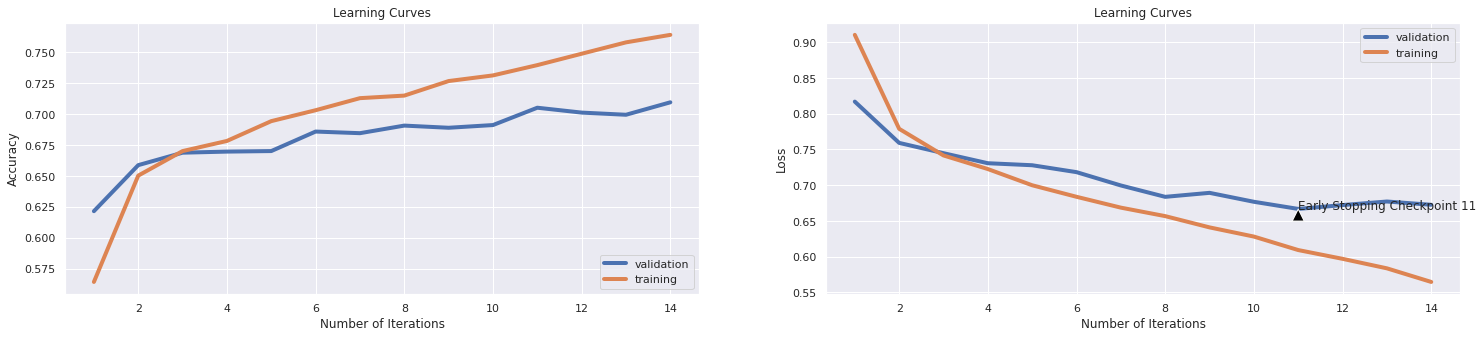

              precision    recall  f1-score
neutral        0.776761  0.797183  0.786840
antivax        0.542714  0.364865  0.436364
provax         0.668687  0.718784  0.692831
macro avg      0.662721  0.626944  0.638678
weighted avg   0.702785  0.709465  0.703438


**Accuracy: 0.70947** 



Total time: 52.62 seconds


**Grid Search: 6, Type: LSTM, Hidden size: 64, Stacks: 4, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.543064596895343, 0.6349524286429644, 0.6629944917376064, 0.6735102653980971, 0.681835252879319, 0.6895968953430145, 0.693164747120681, 0.6992363545317977, 0.7041186780170255, 0.7062468703054582, 0.7092513770655984, 0.7146344516775163, 0.7168878317476214, 0.7200801201802705, 0.7215197796695042]
Validation accuracy scores: [0.6314636283961438, 0.64943032427695, 0.6691498685363716, 0.6805433829973707, 0.6787905346187555, 0.689307624890447, 0.6928133216476775, 0.696319018404908, 0.6971954425942156, 0.6936897458369851, 0.6980718667835232, 0.6884312007011394, 0.7037686240140227, 0.6871165644171779, 0.694127957931639]
Training f1 scores: [0.4689888330470965, 0.593935055497708, 0.6330182928224208, 0.6512999128032932, 0.6666391620923561, 0.6738211610731362, 0.6787833155180328, 0.6852728358115097, 0.6929757054306167, 0.6946566671653718, 0.6983437567162621, 0.7041398188826631, 0.7070721514805075, 0.7100900330772952, 0.713089111053921]
Validation f1 scores: [0.58950934

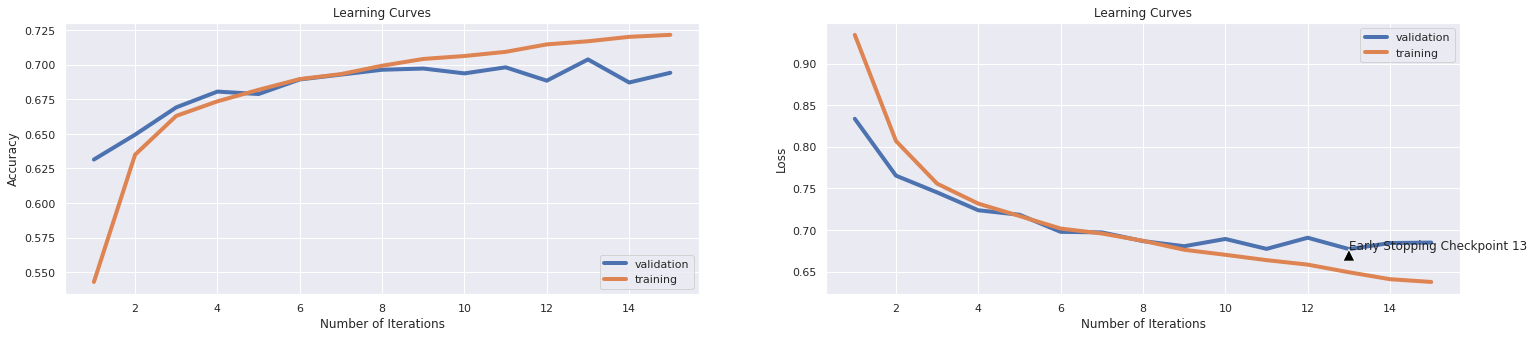

              precision    recall  f1-score
neutral        0.854782  0.679812  0.757322
antivax        0.488263  0.351351  0.408644
provax         0.618658  0.820847  0.705553
macro avg      0.653901  0.617337  0.623840
weighted avg   0.711942  0.694128  0.691201


**Accuracy: 0.69413** 



Total time: 71.93 seconds


**Grid Search: 7, Type: LSTM, Hidden size: 64, Stacks: 4, Skip layers: 2, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5638457686529794, 0.6412118177265899, 0.6668753129694541, 0.6768903355032548, 0.6842138207310966, 0.6924762143214822, 0.7019904857285929, 0.7050575863795694, 0.7103154732098147, 0.7170756134201302, 0.7243365047571357, 0.7291562343515273, 0.7368552829243866, 0.7412368552829244, 0.7488733099649474]
Validation accuracy scores: [0.6393514460999123, 0.6555652936021035, 0.6581945661700263, 0.6595092024539877, 0.6726555652936022, 0.6818580192813322, 0.6792287467134093, 0.6862401402278703, 0.689307624890447, 0.6884312007011394, 0.6888694127957932, 0.6989482909728308, 0.6923751095530236, 0.6971954425942156, 0.7042068361086766]
Training f1 scores: [0.5272773925989483, 0.613313158043689, 0.6461052002173454, 0.6602498450336035, 0.668448998913573, 0.6778362825251374, 0.6904893398760267, 0.691306277173222, 0.6996456498468198, 0.7066511412693943, 0.7158779557408029, 0.7221478223930302, 0.7299022084483714, 0.7350933055361718, 0.7429728949587985]
Validation f1 scores: [0.60

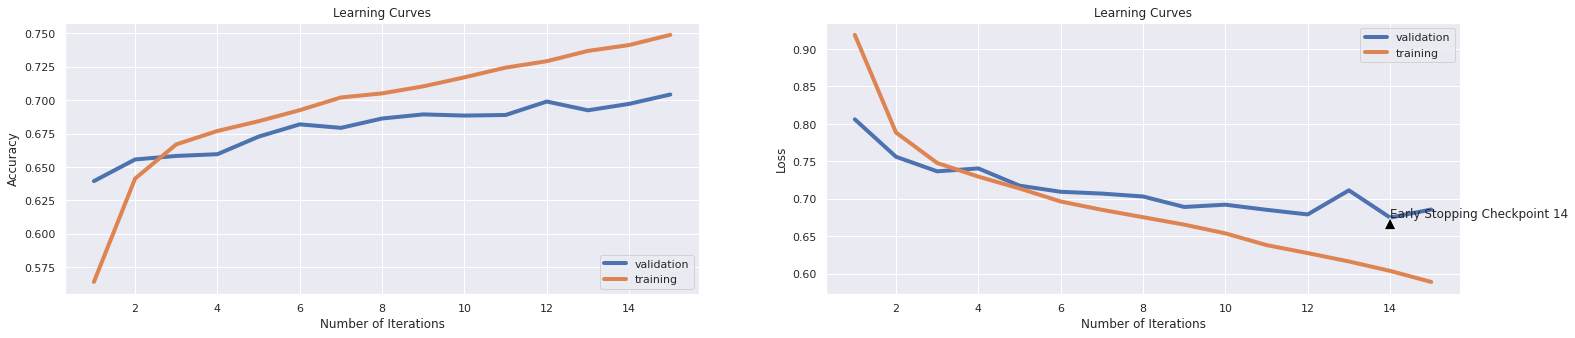

              precision    recall  f1-score
neutral        0.815047  0.732394  0.771513
antivax        0.517544  0.398649  0.450382
provax         0.646308  0.769815  0.702676
macro avg      0.659633  0.633619  0.641524
weighted avg   0.708356  0.704207  0.702077


**Accuracy: 0.70421** 



Total time: 72.96 seconds


**Grid Search: 8, Type: GRU, Hidden size: 64, Stacks: 1, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.542814221331998, 0.6199924887330996, 0.6447170756134202, 0.6643715573360041, 0.6731347020530796, 0.6793314972458688, 0.6856534802203305, 0.6915373059589384, 0.6957310966449675, 0.7009263895843766, 0.7059339008512769, 0.7067476214321482, 0.7117551326990486, 0.7145092638958438, 0.7168878317476214]
Validation accuracy scores: [0.6029798422436459, 0.635407537248028, 0.6608238387379491, 0.6638913234005258, 0.6643295354951797, 0.679666958808063, 0.6822962313759859, 0.6836108676599474, 0.6809815950920245, 0.6914986853637161, 0.689307624890447, 0.6945661700262927, 0.6980718667835232, 0.6950043821209465, 0.6958808063102542]
Training f1 scores: [0.5030964396403449, 0.5792862865326097, 0.6146254383060862, 0.6409848709252781, 0.655268873013792, 0.6608805973286084, 0.6692411286588787, 0.676161086780826, 0.6804920575379879, 0.687734932016394, 0.6932407141695698, 0.69315508350197, 0.700388753818119, 0.7025472722681249, 0.7064590063466979]
Validation f1 scores: [0.56055911

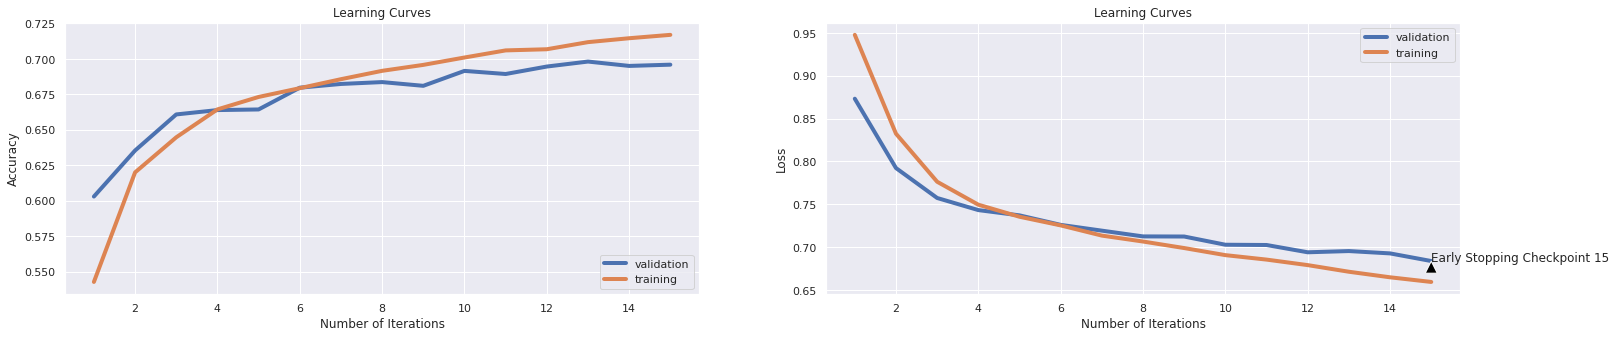

              precision    recall  f1-score
neutral        0.772140  0.785915  0.778967
antivax        0.505319  0.320946  0.392562
provax         0.649505  0.712269  0.679441
macro avg      0.642321  0.606377  0.616990
weighted avg   0.688036  0.695881  0.688678


**Accuracy: 0.69588** 



Total time: 22.82 seconds


**Grid Search: 9, Type: GRU, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5770530796194292, 0.6377691537305958, 0.6586755132699048, 0.6660615923885829, 0.6767025538307461, 0.6864046069103655, 0.690473209814722, 0.6952929394091136, 0.6992363545317977, 0.7062468703054582, 0.7078117175763645, 0.7100650976464697, 0.7172008012018027, 0.7238357536304457, 0.7240235353029544]
Validation accuracy scores: [0.6288343558282209, 0.647239263803681, 0.6590709903593339, 0.6608238387379491, 0.6765994741454864, 0.6840490797546013, 0.6818580192813322, 0.6897458369851008, 0.6919368974583698, 0.694127957931639, 0.6950043821209465, 0.7007011393514461, 0.6914986853637161, 0.7007011393514461, 0.7037686240140227]
Training f1 scores: [0.5328824477682385, 0.6031747688779906, 0.6338931810307558, 0.6453242184311652, 0.6592288638678684, 0.6696956085549439, 0.6750450486689635, 0.6805808364493676, 0.6858425203203379, 0.6943847749287054, 0.6967619150406352, 0.6986667943645575, 0.7070867469510042, 0.71476397084164, 0.7150636830444005]
Validation f1 scores: [0.588

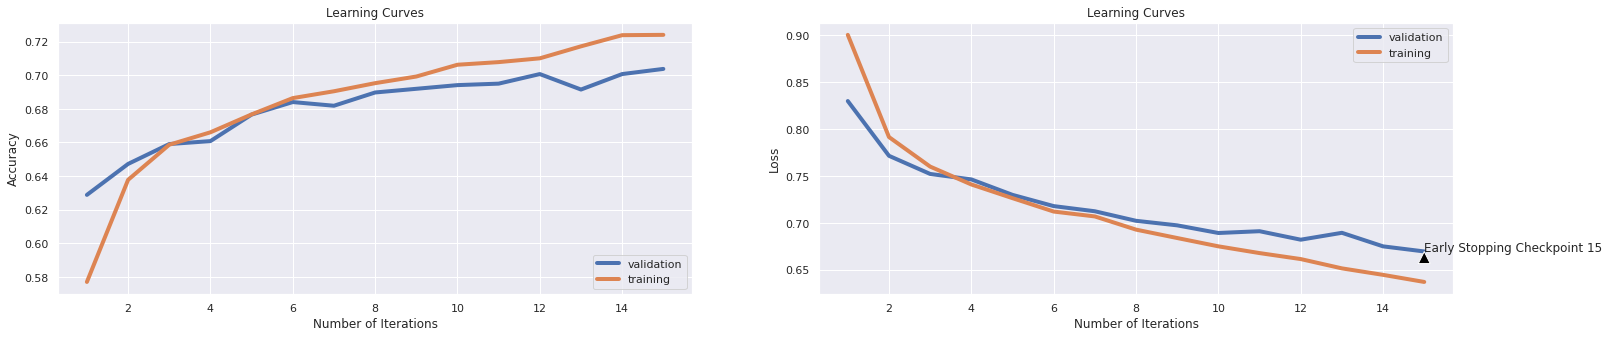

              precision    recall  f1-score
neutral        0.777467  0.784038  0.780739
antivax        0.571429  0.283784  0.379233
provax         0.647502  0.745928  0.693239
macro avg      0.665466  0.604583  0.617737
weighted avg   0.698289  0.703769  0.693345


**Accuracy: 0.70377** 



Total time: 38.40 seconds


**Grid Search: 10, Type: GRU, Hidden size: 64, Stacks: 2, Skip layers: 2, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5604656985478217, 0.6410240360540811, 0.6608037055583375, 0.6695668502754131, 0.6824611917876815, 0.6874061091637457, 0.693665498247371, 0.699549323985979, 0.7002378567851778, 0.7091261892839259, 0.7092513770655984, 0.7182648973460191, 0.7165748622934401, 0.7222083124687031, 0.7242739108662994]
Validation accuracy scores: [0.6279579316389132, 0.6524978089395267, 0.6621384750219106, 0.6691498685363716, 0.6726555652936022, 0.6744084136722174, 0.6757230499561788, 0.6818580192813322, 0.677475898334794, 0.6910604732690623, 0.6914986853637161, 0.6923751095530236, 0.694127957931639, 0.6950043821209465, 0.7024539877300614]
Training f1 scores: [0.5256590578306984, 0.6087735695983397, 0.6382236528235314, 0.6515828273784778, 0.6653046674119163, 0.671021254970804, 0.679462319618448, 0.6855330693152722, 0.6874827012920492, 0.6954331579563939, 0.6990967642187799, 0.7080082852823123, 0.7065134327737057, 0.712643729668189, 0.7148268526061217]
Validation f1 scores: [0.58904

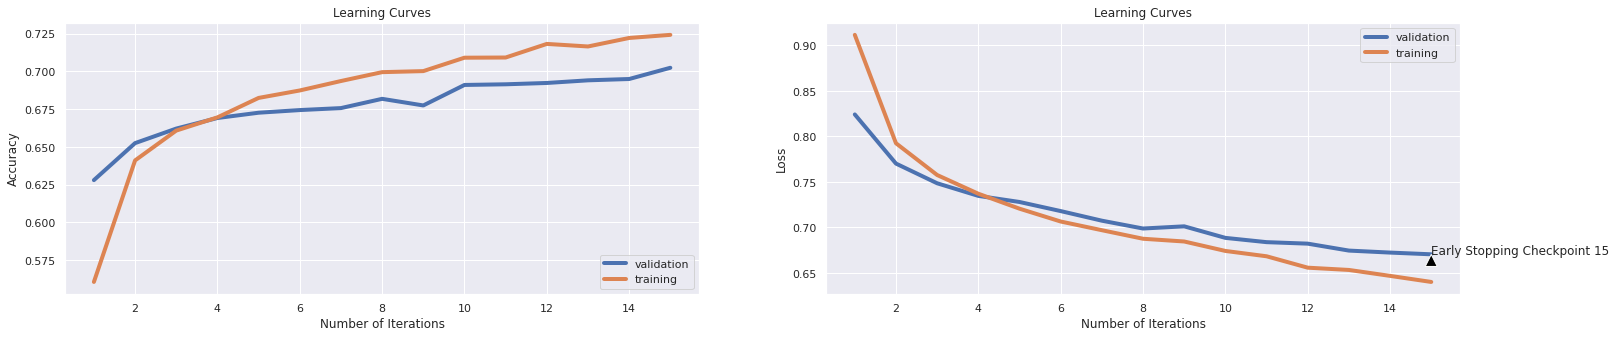

              precision    recall  f1-score
neutral        0.812757  0.741784  0.775650
antivax        0.528986  0.246622  0.336406
provax         0.631399  0.803474  0.707119
macro avg      0.657714  0.597293  0.606392
weighted avg   0.702754  0.702454  0.691017


**Accuracy: 0.70245** 



Total time: 38.80 seconds


**Grid Search: 11, Type: GRU, Hidden size: 64, Stacks: 3, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5851276915373059, 0.6418377566349525, 0.6619929894842264, 0.6752628943415123, 0.6826489734601903, 0.6889083625438157, 0.6957936905358038, 0.7003630445668503, 0.7077491236855283, 0.7083124687030545, 0.7160741111667501, 0.7190160240360541, 0.7212694041061593, 0.7268402603905859, 0.7351026539809714]
Validation accuracy scores: [0.6222611744084137, 0.6481156879929886, 0.6468010517090271, 0.6761612620508326, 0.6792287467134093, 0.684487291849255, 0.689307624890447, 0.6936897458369851, 0.6822962313759859, 0.6884312007011394, 0.6914986853637161, 0.7028921998247152, 0.7011393514461, 0.708150744960561, 0.7055214723926381]
Training f1 scores: [0.5382229362756197, 0.6094705827341883, 0.6393208393146066, 0.6561331167538419, 0.66462656962001, 0.6721871522712412, 0.6819682979302204, 0.6858019851222006, 0.6951201607449701, 0.6952085549754512, 0.7055478489357845, 0.7083782315460164, 0.7119693897464741, 0.718263198244491, 0.7270806273427223]
Validation f1 scores: [0.5779142

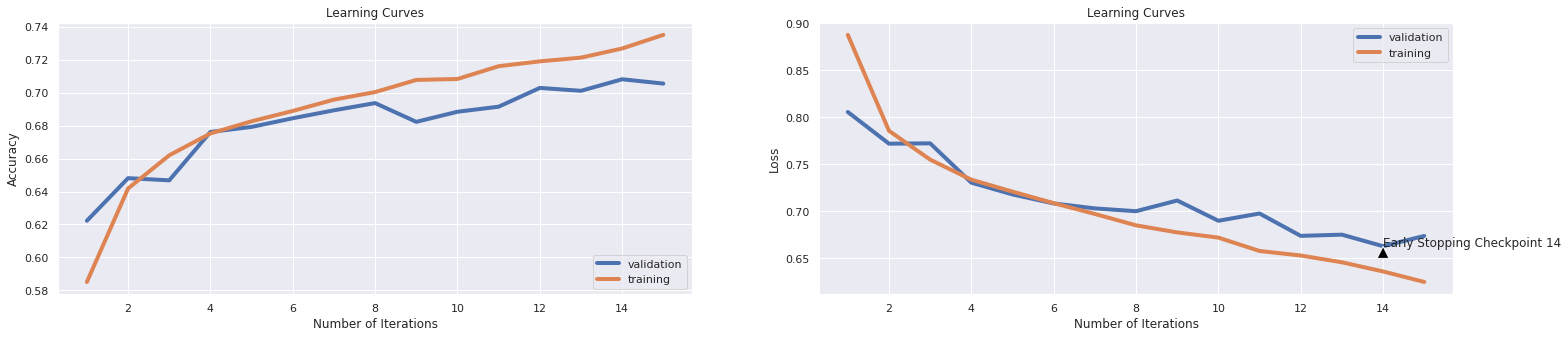

              precision    recall  f1-score
neutral        0.745763  0.826291  0.783964
antivax        0.530364  0.442568  0.482505
provax         0.700585  0.650380  0.674550
macro avg      0.658904  0.639746  0.647006
weighted avg   0.699590  0.705521  0.700703


**Accuracy: 0.70552** 



Total time: 53.53 seconds


**Grid Search: 12, Type: GRU, Hidden size: 64, Stacks: 3, Skip layers: 1, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5774286429644466, 0.6469704556835253, 0.6690035052578869, 0.6794566850275413, 0.6915998998497747, 0.7018652979469204, 0.7080620931397096, 0.7123184777165749, 0.7159489233850777, 0.7247746619929895, 0.7295317976965449, 0.7377315973960942, 0.7404857285928893, 0.7486855282924386, 0.7551952929394091]
Validation accuracy scores: [0.6183172655565293, 0.6599474145486416, 0.6726555652936022, 0.6783523225241017, 0.6722173531989483, 0.6779141104294478, 0.689307624890447, 0.6884312007011394, 0.6936897458369851, 0.6906222611744084, 0.6919368974583698, 0.696319018404908, 0.703330411919369, 0.7037686240140227, 0.7046450482033304]
Training f1 scores: [0.5483572351405887, 0.6246306831493239, 0.6499422292080427, 0.6637975955661924, 0.6770563607721439, 0.6894283290131383, 0.6954439341513781, 0.701710921549589, 0.7062741162753708, 0.7159257441596708, 0.720027067255494, 0.7295153873158058, 0.7336761258764386, 0.7421350700236657, 0.749265728748372]
Validation f1 scores: [0.5760

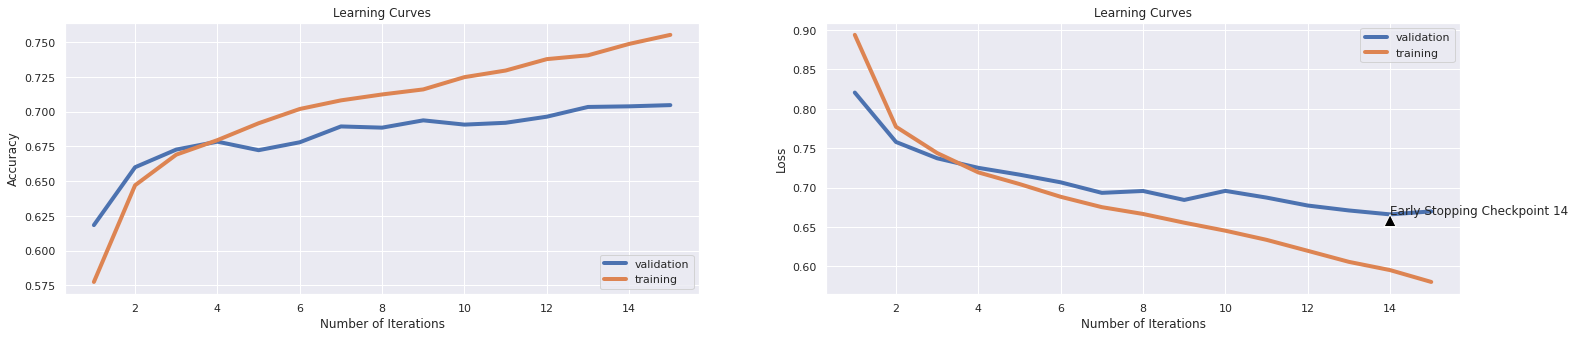

              precision    recall  f1-score
neutral        0.793666  0.776526  0.785002
antivax        0.471186  0.469595  0.470389
provax         0.679365  0.697068  0.688103
macro avg      0.648073  0.647730  0.647831
weighted avg   0.705706  0.704645  0.705086


**Accuracy: 0.70465** 



Total time: 54.57 seconds


**Grid Search: 13, Type: GRU, Hidden size: 64, Stacks: 4, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5726715072608913, 0.6457185778668002, 0.6659989984977466, 0.6775788683024537, 0.6830245368052078, 0.6924762143214822, 0.6977341011517276, 0.7023034551827742, 0.7068102153229845, 0.7103154732098147, 0.7144466700050075, 0.7227090635953931, 0.7268402603905859, 0.7310340510766149, 0.7332248372558838]
Validation accuracy scores: [0.6345311130587205, 0.6568799298860648, 0.6660823838737949, 0.6779141104294478, 0.6805433829973707, 0.684487291849255, 0.6875547765118317, 0.6862401402278703, 0.6906222611744084, 0.6985100788781771, 0.694127957931639, 0.6923751095530236, 0.703330411919369, 0.7072743207712533, 0.7068361086765995]
Training f1 scores: [0.5252070435728541, 0.6211295479907405, 0.6434715279205772, 0.6596012837182205, 0.66656920727118, 0.6759789474499054, 0.6831998463575212, 0.689091741975937, 0.6948696768101441, 0.6996340740145117, 0.7037373097902655, 0.71363232612846, 0.7175486269795177, 0.7235122079986809, 0.7259764047828188]
Validation f1 scores: [0.619731

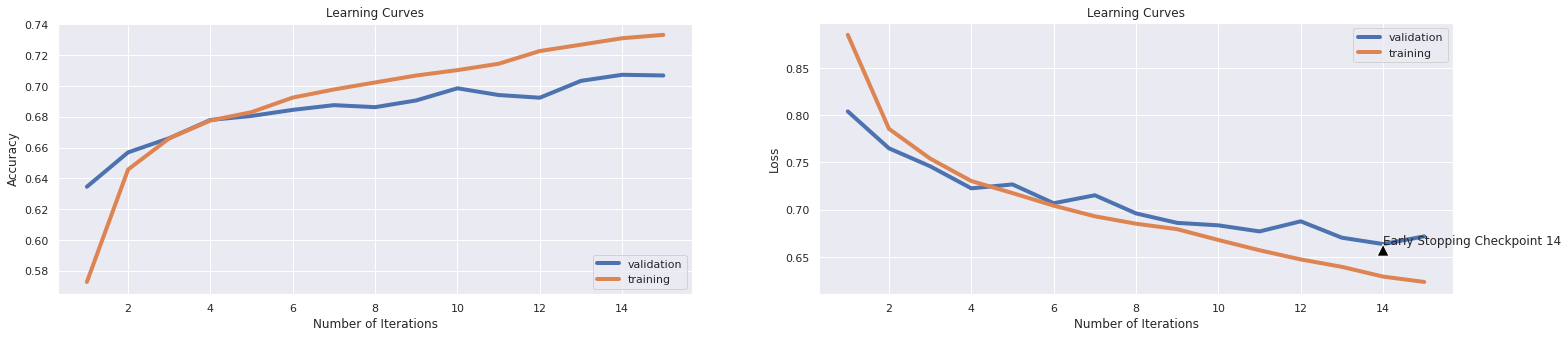

              precision    recall  f1-score
neutral        0.815574  0.747418  0.780010
antivax        0.596774  0.250000  0.352381
provax         0.628596  0.806732  0.706610
macro avg      0.680315  0.601383  0.613000
weighted avg   0.711730  0.706836  0.694918


**Accuracy: 0.70684** 



Total time: 69.22 seconds


**Grid Search: 14, Type: GRU, Hidden size: 64, Stacks: 4, Skip layers: 2, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5928267401101652, 0.6483475212819229, 0.6663119679519279, 0.6811467200801202, 0.6877190786179269, 0.6929769654481722, 0.7009263895843766, 0.7096895343014522, 0.7125062593890836, 0.7222709063595393, 0.7230220330495744, 0.7326614922383575, 0.7352904356534802, 0.7449924887330996, 0.7500625938908363]
Validation accuracy scores: [0.6411042944785276, 0.6577563540753725, 0.663453111305872, 0.6739702015775635, 0.6779141104294478, 0.6875547765118317, 0.689307624890447, 0.6971954425942156, 0.6945661700262927, 0.6928133216476775, 0.7037686240140227, 0.7011393514461, 0.7059596844872918, 0.708150744960561, 0.7120946538124452]
Training f1 scores: [0.56033063132091, 0.6257854548328163, 0.6464904470247778, 0.6628478832364804, 0.6719985615763157, 0.6781115091953016, 0.6893266504779687, 0.6977665661200866, 0.7014706907384404, 0.7124776693357318, 0.7141556713002826, 0.7239703737440062, 0.7277200401753615, 0.7374529754780802, 0.7441016214304697]
Validation f1 scores: [0.615345

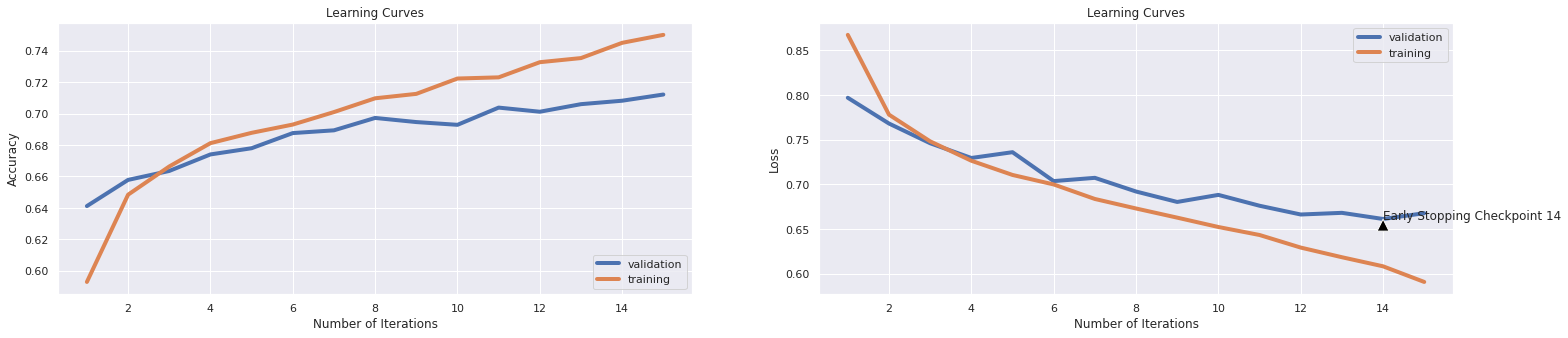

              precision    recall  f1-score
neutral        0.809237  0.756808  0.782145
antivax        0.631579  0.283784  0.391608
provax         0.637467  0.798046  0.708775
macro avg      0.692761  0.612879  0.627509
weighted avg   0.716868  0.712095  0.701876


**Accuracy: 0.71209** 



Total time: 70.20 seconds


**Grid Search: 15, Type: Vanilla, Hidden size: 64, Stacks: 1, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5308587881822734, 0.6199298948422634, 0.6343264897346019, 0.6408988482724086, 0.6474712068102153, 0.6482849273910867, 0.6563595393089634, 0.6599899849774662, 0.6621181772658988, 0.6658112168252378, 0.6710691036554832, 0.6696294441662494, 0.6752628943415123, 0.6751377065598397, 0.6818978467701552]
Validation accuracy scores: [0.605170902716915, 0.6323400525854513, 0.6367221735319895, 0.6419807186678352, 0.6450482033304119, 0.6503067484662577, 0.6446099912357581, 0.6524978089395267, 0.6555652936021035, 0.6608238387379491, 0.6590709903593339, 0.6586327782646801, 0.6630148992112183, 0.6638913234005258, 0.6669588080631026]
Training f1 scores: [0.49603678398502316, 0.5810864611199058, 0.6003649133173419, 0.6143702598574601, 0.6234297504573009, 0.6269120398441655, 0.6363513209753797, 0.6415466872879, 0.6432651660975743, 0.6478114365166253, 0.6538832866881752, 0.652172744033635, 0.6591414858877853, 0.6593979580735387, 0.6664775067240478]
Validation f1 scores: [0.56

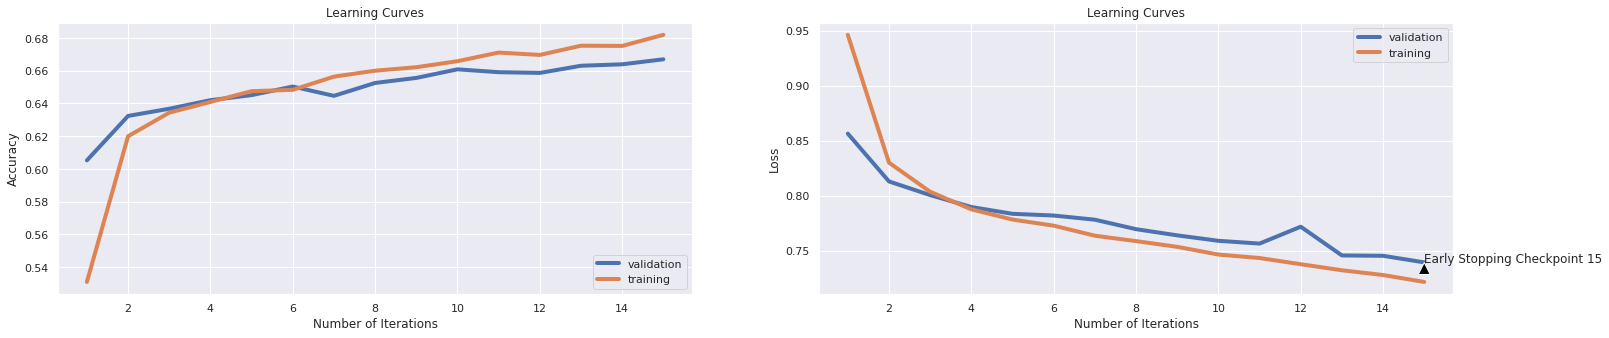

              precision    recall  f1-score
neutral        0.752896  0.732394  0.742504
antivax        0.503876  0.219595  0.305882
provax         0.606088  0.735071  0.664377
macro avg      0.620953  0.562353  0.570921
weighted avg   0.661344  0.666959  0.654338


**Accuracy: 0.66696** 



Total time: 21.11 seconds


**Grid Search: 16, Type: Vanilla, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5685403104656985, 0.6296945418127191, 0.6417125688532799, 0.6488482724086129, 0.6532298447671507, 0.6616174261392088, 0.6664371557336004, 0.670756134201302, 0.6778292438657987, 0.6800200300450676, 0.6843390085127692, 0.6873435152729094, 0.6942288432648973, 0.6989233850776164, 0.7031171757636455]
Validation accuracy scores: [0.6196319018404908, 0.6323400525854513, 0.6384750219106047, 0.6459246275197196, 0.6546888694127958, 0.6529360210341806, 0.6625766871165644, 0.661262050832603, 0.6652059596844873, 0.6630148992112183, 0.6647677475898335, 0.6660823838737949, 0.6735319894829097, 0.6801051709027169, 0.6783523225241017]
Training f1 scores: [0.5289728871357038, 0.5962595173985618, 0.6179526429863033, 0.6267781246948768, 0.632515282640606, 0.6407696662153644, 0.6475995197718891, 0.6535651654198842, 0.6614392679039113, 0.6641632523760866, 0.669077656673291, 0.6716918627280588, 0.6808998784841505, 0.6847623100314943, 0.6911077557013988]
Validation f1 scores: [0.57

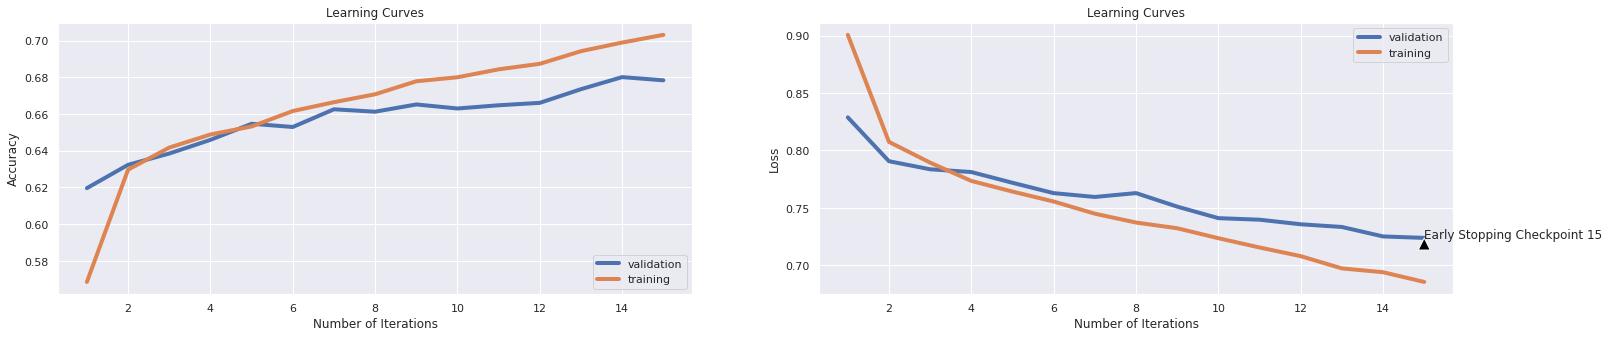

              precision    recall  f1-score
neutral        0.759138  0.760563  0.759850
antivax        0.528000  0.222973  0.313539
provax         0.616514  0.729642  0.668324
macro avg      0.634551  0.571059  0.580571
weighted avg   0.671595  0.678352  0.665019


**Accuracy: 0.67835** 



Total time: 34.45 seconds


**Grid Search: 17, Type: Vanilla, Hidden size: 64, Stacks: 2, Skip layers: 2, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5548948422633951, 0.6253755633450175, 0.6380195292939409, 0.6504131196795193, 0.6557336004006009, 0.6630570856284427, 0.6649349023535303, 0.6714446670005008, 0.675200300450676, 0.6796444667000501, 0.6831497245868803, 0.6864046069103655, 0.6924136204306459, 0.6961692538808212, 0.6966700050075113]
Validation accuracy scores: [0.6126205083260298, 0.6240140227870289, 0.6362839614373357, 0.6397896581945661, 0.642418930762489, 0.6371603856266433, 0.647239263803681, 0.6507449605609115, 0.6568799298860648, 0.6568799298860648, 0.663453111305872, 0.6643295354951797, 0.6647677475898335, 0.6722173531989483, 0.6621384750219106]
Training f1 scores: [0.5185421035209347, 0.5924680425549366, 0.611449043057851, 0.6308292715215545, 0.6367990100569272, 0.6442559111727465, 0.6476712842180448, 0.6557831028692271, 0.6585186520621997, 0.6652088076693389, 0.6689046029817134, 0.671946832429561, 0.6783313152380327, 0.6841316138708489, 0.6839346591108247]
Validation f1 scores: [0.5772

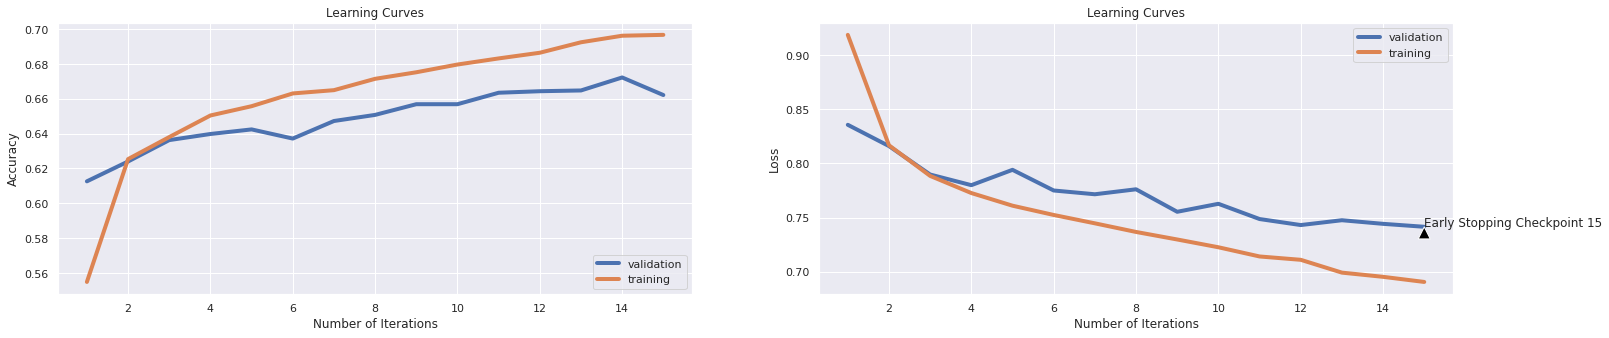

              precision    recall  f1-score
neutral        0.751938  0.728638  0.740105
antivax        0.464789  0.222973  0.301370
provax         0.603791  0.726384  0.659438
macro avg      0.606839  0.559332  0.566971
weighted avg   0.654900  0.662138  0.650640


**Accuracy: 0.66214** 



Total time: 35.41 seconds


**Grid Search: 18, Type: Vanilla, Hidden size: 64, Stacks: 3, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5739859789684527, 0.6267526289434151, 0.6422759138708062, 0.6537305958938407, 0.6592388582874311, 0.6661241862794192, 0.6723835753630446, 0.6740110165247872, 0.6787681522283425, 0.6823985978968453, 0.6838382573860792, 0.6937906860290436, 0.6971707561342013, 0.704744616925388, 0.7095017526289434]
Validation accuracy scores: [0.6134969325153374, 0.6446099912357581, 0.6503067484662577, 0.6590709903593339, 0.6608238387379491, 0.6538124452234881, 0.6621384750219106, 0.6573181419807187, 0.6717791411042945, 0.6538124452234881, 0.6660823838737949, 0.6836108676599474, 0.679666958808063, 0.6822962313759859, 0.6858019281332165]
Training f1 scores: [0.5302725619763428, 0.5914094130738634, 0.613797881605499, 0.6304770839580578, 0.638348045218307, 0.6459993090323528, 0.6556324451413572, 0.6563458207144468, 0.6644696986188755, 0.6672207945884918, 0.6695379696225056, 0.6809014005217066, 0.6850071845611393, 0.6925748535349205, 0.6987418678390684]
Validation f1 scores: [0.57

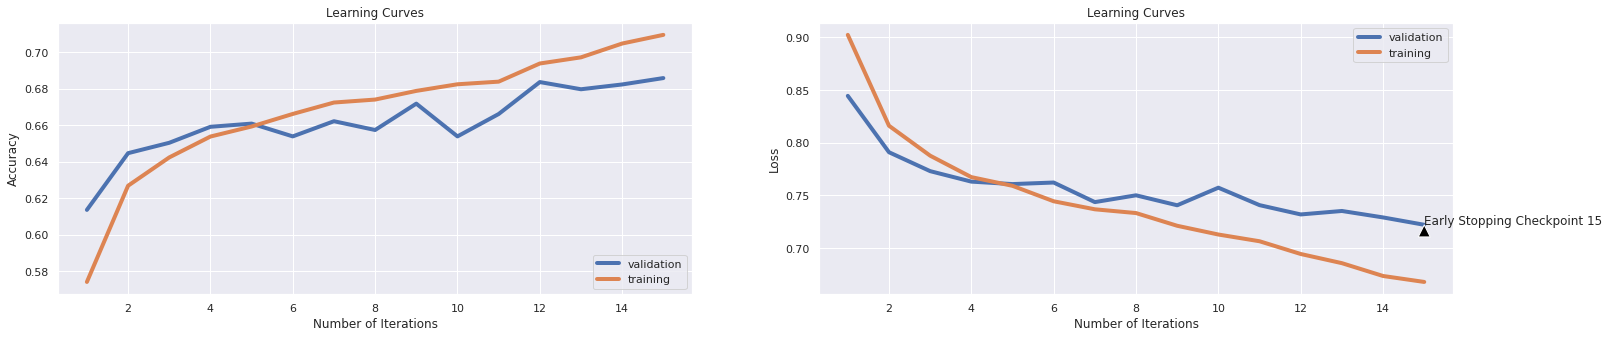

              precision    recall  f1-score
neutral        0.759746  0.786854  0.773063
antivax        0.462963  0.337838  0.390625
provax         0.651090  0.680782  0.665605
macro avg      0.624600  0.601825  0.609764
weighted avg   0.677397  0.685802  0.680087


**Accuracy: 0.68580** 



Total time: 48.08 seconds


**Grid Search: 19, Type: Vanilla, Hidden size: 64, Stacks: 3, Skip layers: 1, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5615923885828743, 0.6339509263895844, 0.6480971457185779, 0.6578617926890336, 0.6676890335503255, 0.6757636454682023, 0.6829619429143715, 0.693415122684026, 0.6954181271907862, 0.7055583375062594, 0.7091887831747622, 0.7203930896344517, 0.7211442163244868, 0.7292188282423635, 0.7402979469203805]
Validation accuracy scores: [0.6029798422436459, 0.6170026292725679, 0.6362839614373357, 0.6428571428571429, 0.647239263803681, 0.6319018404907976, 0.6489921121822962, 0.6524978089395267, 0.6555652936021035, 0.6660823838737949, 0.6695880806310254, 0.6630148992112183, 0.6691498685363716, 0.6700262927256793, 0.6595092024539877]
Training f1 scores: [0.5341315205654603, 0.6102738786251689, 0.6269672548220477, 0.6389962890167994, 0.6505369067815334, 0.6601433693845464, 0.6683292430735538, 0.6800788696309976, 0.6829223469168879, 0.6938538412834745, 0.6987901371941282, 0.7104811746487785, 0.7113263371026409, 0.718753321177246, 0.7309686304074244]
Validation f1 scores: [0.5

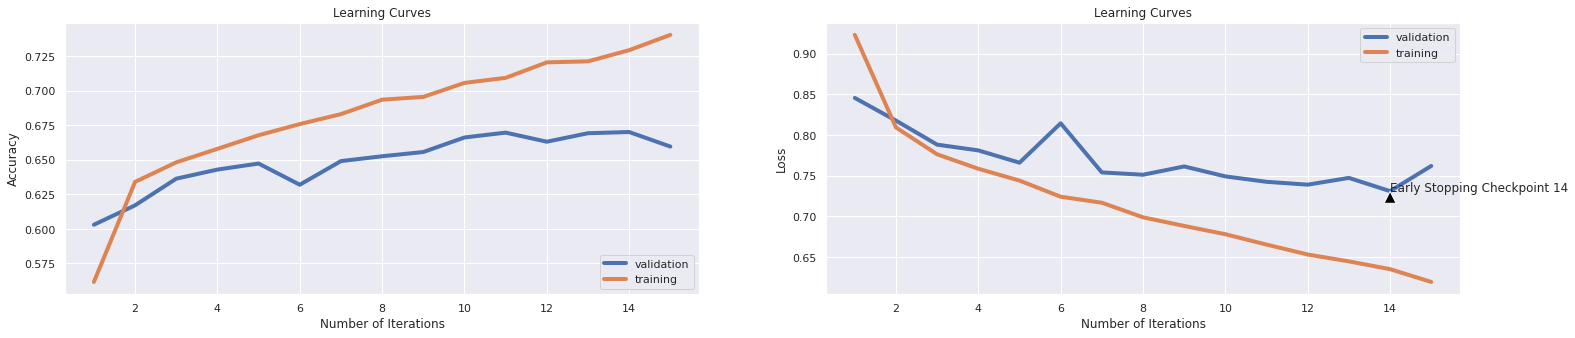

              precision    recall  f1-score
neutral        0.679331  0.839437  0.750945
antivax        0.503448  0.246622  0.331066
provax         0.655298  0.584148  0.617681
macro avg      0.612693  0.556735  0.566564
weighted avg   0.646818  0.659509  0.642698


**Accuracy: 0.65951** 



Total time: 48.98 seconds


**Grid Search: 20, Type: Vanilla, Hidden size: 64, Stacks: 4, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5647220831246871, 0.6283800701051577, 0.64271407110666, 0.6550450676014021, 0.6656234351527291, 0.667814221331998, 0.6758888332498748, 0.6796444667000501, 0.683337506259389]
Validation accuracy scores: [0.6134969325153374, 0.6367221735319895, 0.6288343558282209, 0.6432953549517967, 0.6468010517090271, 0.6617002629272568, 0.6516213847502191, 0.6468010517090271, 0.6498685363716039]
Training f1 scores: [0.520953124212867, 0.5987438747075824, 0.6198065861864845, 0.6328499136822846, 0.6448130165276565, 0.6493361324769129, 0.6587251183676179, 0.6631751747731747, 0.6668794916938868]
Validation f1 scores: [0.5807651521123816, 0.6261623622902834, 0.5915771842424835, 0.6075036752318406, 0.6344689016741283, 0.6328355351657442, 0.6295831866048164, 0.625878744648697, 0.6294536868729205]
Training losses: [0.9033941135406495, 0.8057819228172303, 0.7799018321037292, 0.7639590239524842, 0.7479640722274781, 0.738296205997467, 0.7278589820861816, 0.7219823007583618, 0.7126922

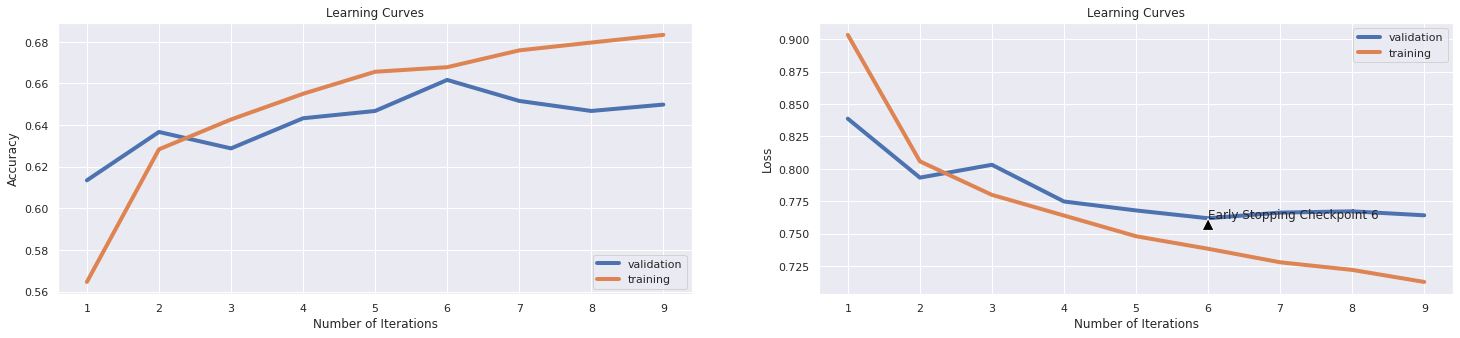

              precision    recall  f1-score
neutral        0.662338  0.861972  0.749082
antivax        0.466667  0.236486  0.313901
provax         0.663539  0.537459  0.593881
macro avg      0.597514  0.545306  0.552288
weighted avg   0.637442  0.649869  0.629996


**Accuracy: 0.64987** 



Total time: 37.29 seconds


**Grid Search: 21, Type: Vanilla, Hidden size: 64, Stacks: 4, Skip layers: 2, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5746745117676515, 0.6274411617426139, 0.6448422633950927, 0.6561091637456185, 0.6645593390085127, 0.6703179769654481, 0.6820230345518278, 0.689471707561342, 0.6897846770155233, 0.7019278918377566, 0.7055583375062594, 0.709877315973961, 0.7200801201802705, 0.7243990986479719, 0.7284051076614922]
Validation accuracy scores: [0.6130587204206837, 0.6327782646801051, 0.6450482033304119, 0.6419807186678352, 0.6485539000876425, 0.6498685363716039, 0.6625766871165644, 0.6713409290096407, 0.670464504820333, 0.6744084136722174, 0.6787905346187555, 0.6805433829973707, 0.6730937773882559, 0.679666958808063, 0.6713409290096407]
Training f1 scores: [0.5398202725012794, 0.6009754484304441, 0.6242070603066296, 0.6362949770152687, 0.6458450758528244, 0.65417600615509, 0.6670675207107294, 0.6756223760670221, 0.6756881344974893, 0.6889170734854978, 0.6931905503699205, 0.6990168198304475, 0.7082078763598674, 0.7147616768685766, 0.7183075544962056]
Validation f1 scores: [0.5771

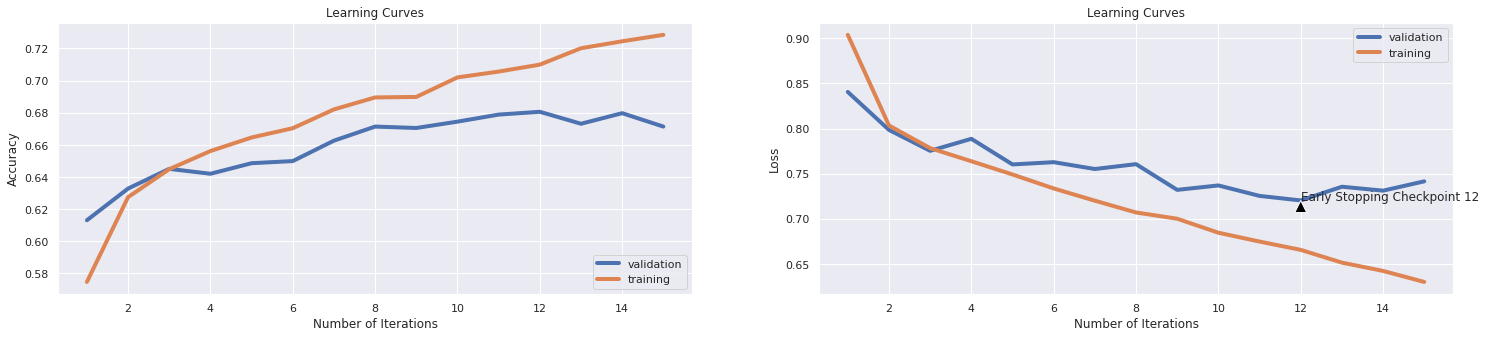

              precision    recall  f1-score
neutral        0.742520  0.769014  0.755535
antivax        0.573529  0.131757  0.214286
provax         0.606661  0.731813  0.663386
macro avg      0.640903  0.544195  0.544402
weighted avg   0.665768  0.671341  0.648138


**Accuracy: 0.67134** 



Total time: 62.44 seconds

Best grid is: Grid Search: 9, Type: GRU, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None



In [ ]:
param_grid = {
  'types': ['LSTM', 'GRU', 'Vanilla'],
  'hidden_dimensions': [64],
  'layers_info': [{'stacks': 1, 'skip': None}, {'stacks': 2, 'skip': None}, {'stacks': 2, 'skip': 2}, {'stacks': 3, 'skip': None}, {'stacks': 3, 'skip': 1}, {'stacks': 4, 'skip': None}, {'stacks': 4, 'skip': 2}],
  'max_clip_norms': [5],
  'dropout_rates': [None],
  'encoding_stategies': ['LAST_STATES'],
  'bidirectional': True,
  'sequence_length': 50,
  'learning_rates': [{'val' : 3e-4, 'schelduler': None}],
  'classes': ['neutral', 'antivax', 'provax'],
  'batch_size': 128,
  'epochs': 15,
  'early_stopping_patience': 3,
  'L2_reg': 0,
  'accuracy_threshold': 0.68
}

customGridSearch(param_grid, glove_training_set, glove_validation_set, embedding_matrix)

### **Gradient clipping evaluation: Small max norm vs Medium max norm vs Large max norm**

**Grid Search: 1, Type: LSTM, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: None, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5650976464697045, 0.6416499749624437, 0.6598022033049574, 0.670756134201302, 0.6790185277916875, 0.6900350525788683, 0.6972959439158738, 0.6983600400600901, 0.7046194291437156, 0.709877315973961, 0.7148848272408613, 0.7168878317476214, 0.722458688032048, 0.7230220330495744, 0.7319103655483225]
Validation accuracy scores: [0.621384750219106, 0.6389132340052586, 0.6599474145486416, 0.6695880806310254, 0.6783523225241017, 0.6831726555652936, 0.6748466257668712, 0.6757230499561788, 0.6831726555652936, 0.6875547765118317, 0.6954425942156004, 0.6914986853637161, 0.6914986853637161, 0.7007011393514461, 0.7024539877300614]
Training f1 scores: [0.5127990638608774, 0.6021698653428135, 0.6334338124352591, 0.6484634608578093, 0.6600485183220809, 0.6747782521465449, 0.6821456456150311, 0.6849863619408777, 0.692455770083639, 0.6982606187883481, 0.7046310015671844, 0.7063548374851861, 0.7125160388000001, 0.7134513259000632, 0.7233248829882728]
Validation f1 scores: [0.574

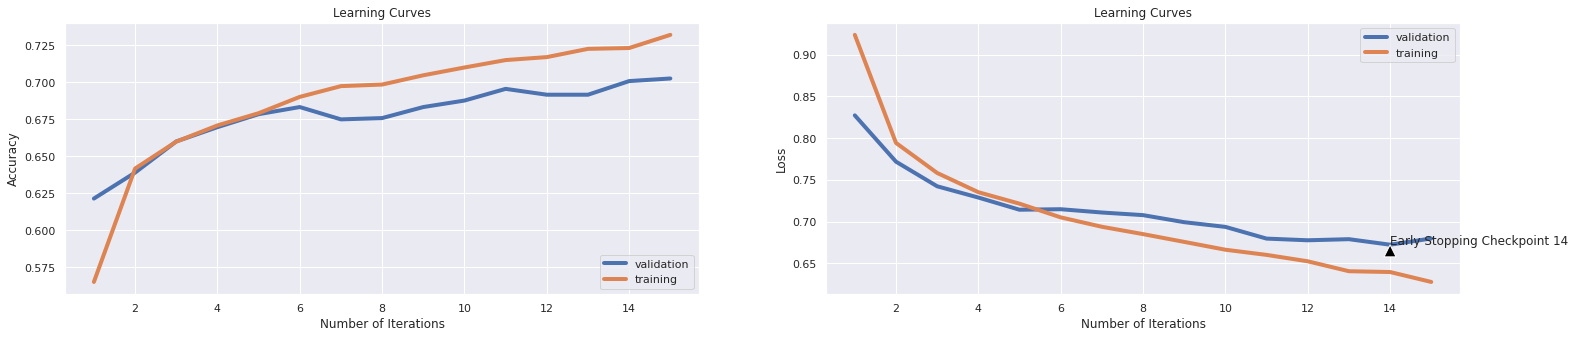

              precision    recall  f1-score
neutral        0.754850  0.803756  0.778536
antivax        0.538922  0.304054  0.388769
provax         0.669725  0.713355  0.690852
macro avg      0.654499  0.607055  0.619385
weighted avg   0.692486  0.702454  0.692590


**Accuracy: 0.70245** 



Total time: 38.46 seconds


**Grid Search: 2, Type: LSTM, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 1, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5648472709063596, 0.6424011016524788, 0.66042814221332, 0.6688783174762143, 0.67864296444667, 0.6890335503254882, 0.6947921882824236, 0.7001752628943415, 0.703743114672008, 0.7081872809213821, 0.717764146219329, 0.7187656484727091, 0.7239609414121182, 0.724649474211317, 0.7321607411116675]
Validation accuracy scores: [0.6231375985977213, 0.6538124452234881, 0.6678352322524101, 0.6722173531989483, 0.6739702015775635, 0.6792287467134093, 0.6831726555652936, 0.6853637160385626, 0.6849255039439088, 0.6932515337423313, 0.696319018404908, 0.6967572304995618, 0.6971954425942156, 0.6928133216476775, 0.6980718667835232]
Training f1 scores: [0.5160131344472607, 0.6109947737982585, 0.6404279231348335, 0.651309527177092, 0.6629645847049779, 0.6751188752872198, 0.6816715086890252, 0.6868398318860505, 0.6919387038349033, 0.6969916521577103, 0.7072263185038568, 0.7087232430162195, 0.7139713210017107, 0.7161384617739132, 0.7249224624327526]
Validation f1 scores: [0.5803906

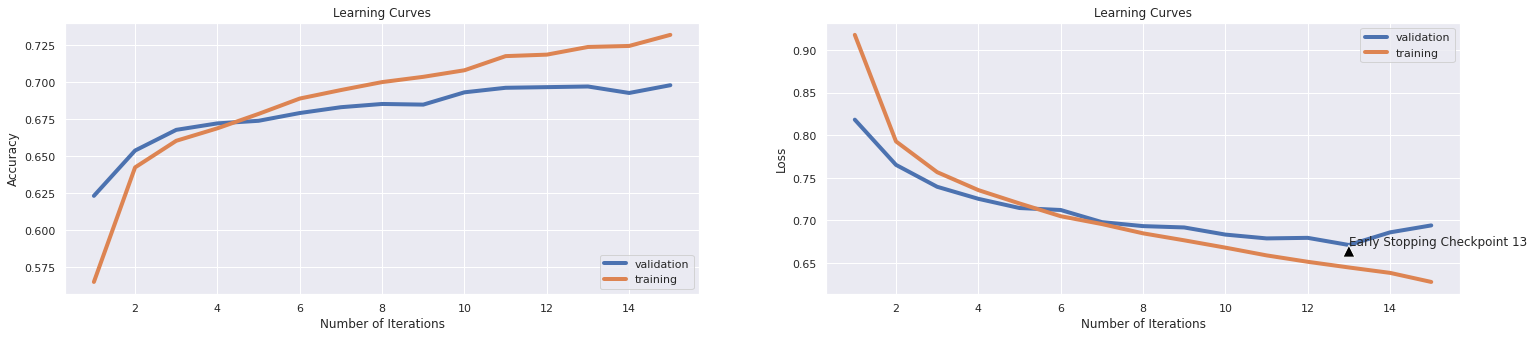

              precision    recall  f1-score
neutral        0.732665  0.823474  0.775420
antivax        0.564706  0.324324  0.412017
provax         0.677596  0.673181  0.675381
macro avg      0.658322  0.606993  0.620939
weighted avg   0.688653  0.698072  0.687908


**Accuracy: 0.69807** 



Total time: 39.34 seconds


**Grid Search: 3, Type: LSTM, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5656609914872308, 0.6415873810716074, 0.6574236354531797, 0.6718202303455183, 0.678392588883325, 0.6885953930896345, 0.692663995993991, 0.6992363545317977, 0.7019904857285929, 0.7089384076114171, 0.7113169754631948, 0.7176389584376565, 0.722458688032048, 0.7270906359539309, 0.7268402603905859]
Validation accuracy scores: [0.6244522348816828, 0.6481156879929886, 0.6617002629272568, 0.6678352322524101, 0.6709027169149868, 0.6822962313759859, 0.6779141104294478, 0.6875547765118317, 0.684487291849255, 0.677475898334794, 0.6897458369851008, 0.6967572304995618, 0.6888694127957932, 0.7007011393514461, 0.7007011393514461]
Training f1 scores: [0.5050850346986351, 0.6076738224663603, 0.6334818278170097, 0.6520655899081039, 0.6615799829185568, 0.6734371661012756, 0.6777071883679274, 0.6862009626713109, 0.6899698729702284, 0.6979054762459386, 0.7008288272053637, 0.707267944534862, 0.7130904973502882, 0.7183205369416104, 0.7189258210079401]
Validation f1 scores: [0.5845

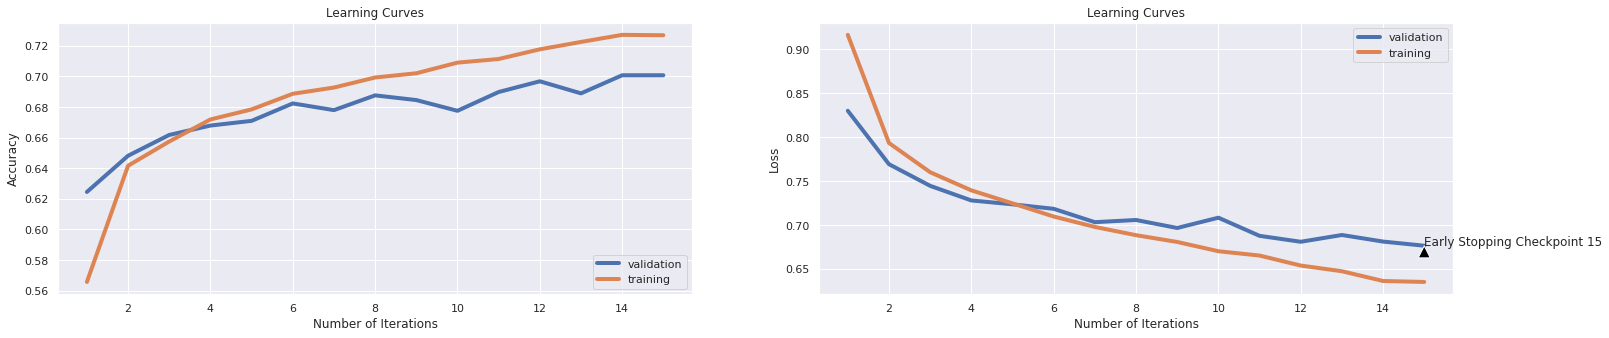

              precision    recall  f1-score
neutral        0.787645  0.766197  0.776773
antivax        0.516667  0.418919  0.462687
provax         0.655070  0.715527  0.683965
macro avg      0.653127  0.633548  0.641141
weighted avg   0.698990  0.700701  0.698576


**Accuracy: 0.70070** 



Total time: 39.64 seconds


**Grid Search: 4, Type: LSTM, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 10, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5664121181772659, 0.6408988482724086, 0.6579243865798698, 0.6690660991487231, 0.6766399599399099, 0.6882824236354532, 0.6945418127190787, 0.6968577866800201, 0.7030545818728092, 0.7034301452178268, 0.7119429143715573, 0.7171382073109664, 0.717764146219329, 0.7242739108662994, 0.7318477716574863]
Validation accuracy scores: [0.6200701139351447, 0.6349693251533742, 0.663453111305872, 0.6643295354951797, 0.6713409290096407, 0.6779141104294478, 0.6814198071866784, 0.6792287467134093, 0.6858019281332165, 0.6783523225241017, 0.6827344434706398, 0.6932515337423313, 0.6884312007011394, 0.6932515337423313, 0.6884312007011394]
Training f1 scores: [0.5089200684804759, 0.6042416075550087, 0.6326374948890341, 0.6478470981291427, 0.6591716172769969, 0.6727530461741376, 0.6781216146740504, 0.6831720218262795, 0.6896587468519204, 0.6902968466391307, 0.699753333557717, 0.7057550099850443, 0.7075563767507973, 0.7140437845308354, 0.7229345510374968]
Validation f1 scores: [0.5

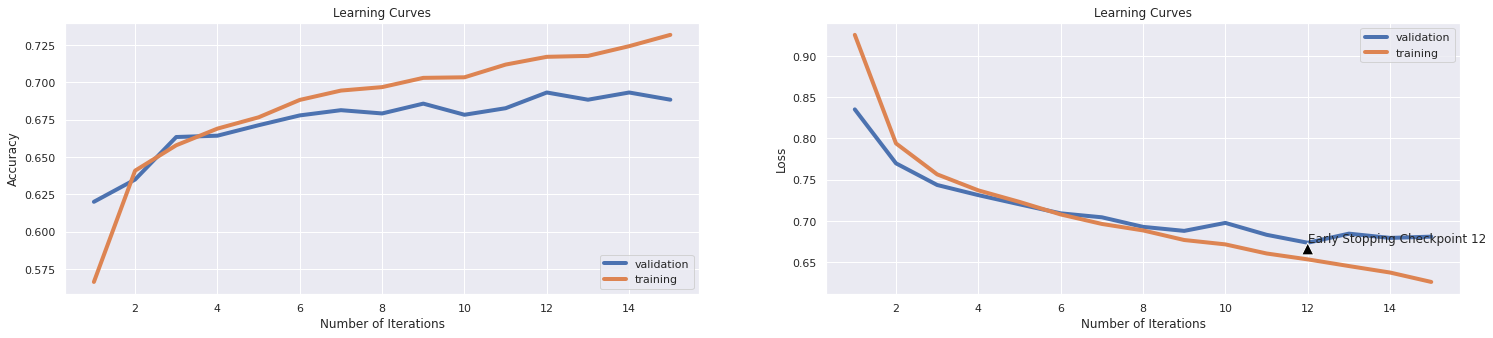

              precision    recall  f1-score
neutral        0.836528  0.696714  0.760246
antivax        0.515385  0.226351  0.314554
provax         0.602372  0.827362  0.697164
macro avg      0.651428  0.583476  0.590655
weighted avg   0.700368  0.688431  0.676975


**Accuracy: 0.68843** 



Total time: 39.75 seconds


**Grid Search: 5, Type: GRU, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: None, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5831246870305459, 0.6430270405608413, 0.6588632949424136, 0.6713820731096645, 0.6814596895343015, 0.6885953930896345, 0.6937280921382073, 0.699799699549324, 0.7038057085628443, 0.7076239359038557, 0.7128818227341012, 0.717013019529294, 0.7163870806209314, 0.7228968452679019, 0.7262143214822233]
Validation accuracy scores: [0.628396143733567, 0.6568799298860648, 0.6638913234005258, 0.6761612620508326, 0.6765994741454864, 0.6827344434706398, 0.6884312007011394, 0.6901840490797546, 0.6958808063102542, 0.6945661700262927, 0.6923751095530236, 0.7007011393514461, 0.7028921998247152, 0.6998247151621385, 0.7085889570552147]
Training f1 scores: [0.5395972284006179, 0.6121105276145468, 0.6355750849429778, 0.6512580666735909, 0.6632325284144425, 0.6719514862740406, 0.6764523601824075, 0.6854423661305182, 0.690451352816547, 0.6953575364343637, 0.701421214022012, 0.7051585607839987, 0.7061646010799811, 0.7122066392240386, 0.7167315478292111]
Validation f1 scores: [0.589

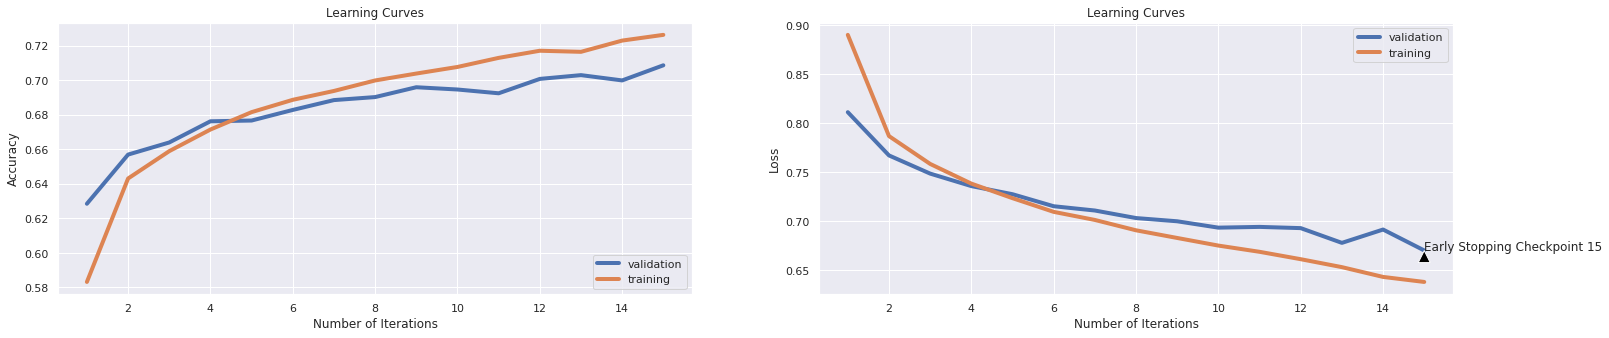

              precision    recall  f1-score
neutral        0.806387  0.758685  0.781809
antivax        0.578231  0.287162  0.383747
provax         0.639011  0.786102  0.704966
macro avg      0.674543  0.610650  0.623507
weighted avg   0.709241  0.708589  0.699163


**Accuracy: 0.70859** 



Total time: 36.95 seconds


**Grid Search: 6, Type: GRU, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 1, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5810590886329494, 0.6445292939409114, 0.66092889334001, 0.6747621432148222, 0.6809589384076115, 0.6905983975963946, 0.6954181271907862, 0.7003630445668503, 0.700050075112669, 0.7106284426639959, 0.713820731096645, 0.7133825738607912, 0.7184526790185278, 0.7261517275913871]
Validation accuracy scores: [0.6205083260297984, 0.6577563540753725, 0.6590709903593339, 0.6717791411042945, 0.6822962313759859, 0.6827344434706398, 0.6897458369851008, 0.6862401402278703, 0.6691498685363716, 0.6919368974583698, 0.6985100788781771, 0.6967572304995618, 0.6989482909728308, 0.694127957931639]
Training f1 scores: [0.5371407611085411, 0.6146885782634859, 0.6396438996865922, 0.6546848259001916, 0.6625902076979265, 0.6749545074649678, 0.680011890545772, 0.6870397159594227, 0.6867664454497099, 0.6977746409795688, 0.7023817700232461, 0.7002033207648045, 0.7079673188829492, 0.7158052627126626]
Validation f1 scores: [0.5819816378117878, 0.6348006752447746, 0.6369285652761623, 0.6624

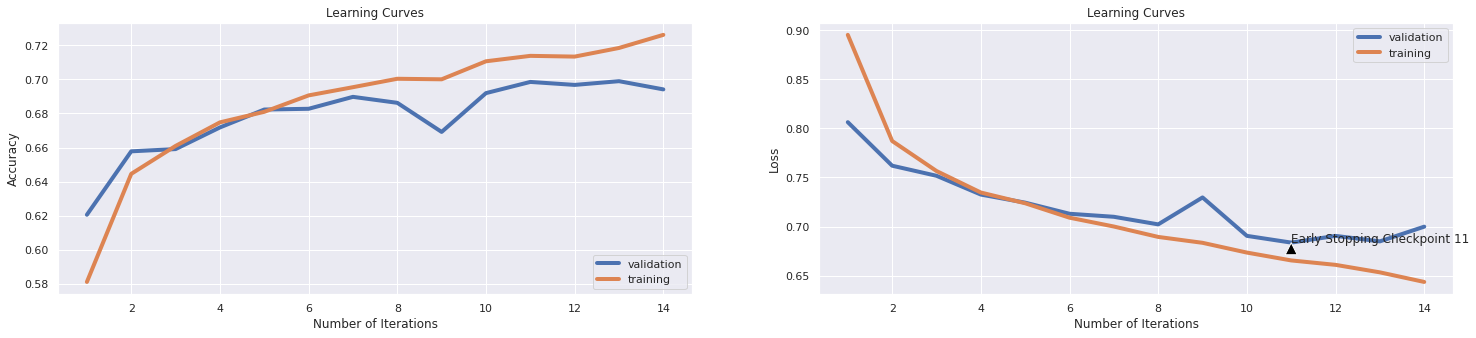

              precision    recall  f1-score
neutral        0.842890  0.690141  0.758906
antivax        0.618182  0.229730  0.334975
provax         0.600769  0.847991  0.703287
macro avg      0.687280  0.589287  0.599056
weighted avg   0.716025  0.694128  0.681470


**Accuracy: 0.69413** 



Total time: 35.89 seconds


**Grid Search: 7, Type: GRU, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5813094641962945, 0.6392088132198297, 0.6618678017025539, 0.6745743615423134, 0.6832123184777166, 0.6867175763645468, 0.6947921882824236, 0.6992363545317977, 0.7038057085628443, 0.7090635953930896, 0.7109414121181773, 0.7173259889834752, 0.7205808713069605, 0.7234601902854282, 0.7263395092638958]
Validation accuracy scores: [0.6253286590709903, 0.6481156879929886, 0.6625766871165644, 0.6739702015775635, 0.6818580192813322, 0.6818580192813322, 0.6836108676599474, 0.6906222611744084, 0.6950043821209465, 0.6888694127957932, 0.6914986853637161, 0.694127957931639, 0.7007011393514461, 0.694127957931639, 0.6901840490797546]
Training f1 scores: [0.5352215073754618, 0.6079475552750372, 0.638729119977841, 0.6556978303418972, 0.6662683715344564, 0.6695240367097633, 0.6801219471019938, 0.68548178019661, 0.6906192058763215, 0.6971839986136793, 0.6994337463799999, 0.7059333818840792, 0.7101939859287681, 0.7134457938510071, 0.7165831011461125]
Validation f1 scores: [0.586

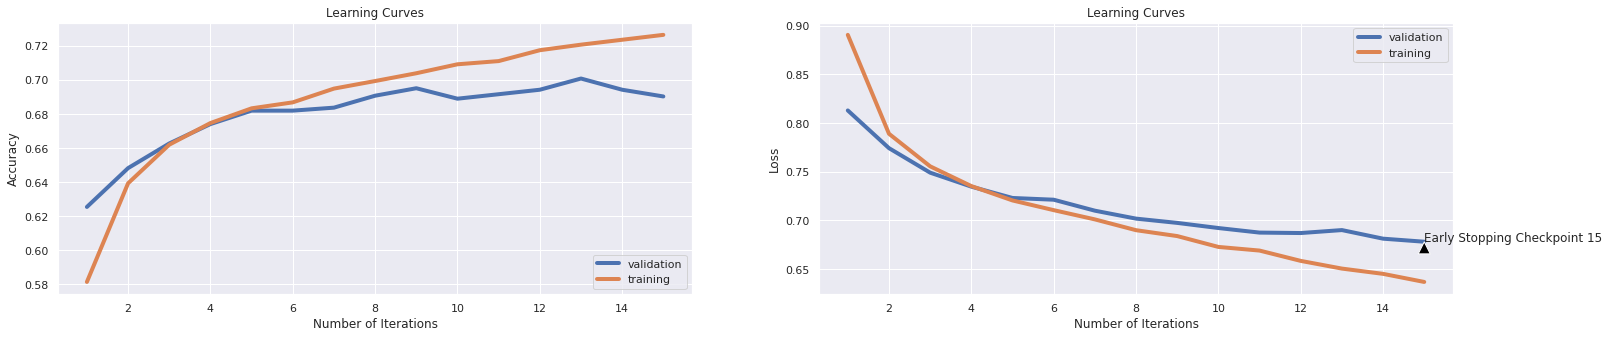

              precision    recall  f1-score
neutral        0.754433  0.799061  0.776106
antivax        0.474576  0.378378  0.421053
provax         0.666667  0.664495  0.665579
macro avg      0.631892  0.613978  0.620913
weighted avg   0.682710  0.690184  0.685444


**Accuracy: 0.69018** 



Total time: 38.52 seconds


**Grid Search: 8, Type: GRU, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: 10, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5869429143715573, 0.6426514772158237, 0.6618678017025539, 0.6740736104156234, 0.6823985978968453, 0.6860916374561843, 0.6938532799198798, 0.700050075112669, 0.6998622934401603, 0.7049949924887331, 0.7133199799699549, 0.7139459188783175, 0.7230220330495744, 0.7229594391587381, 0.724148723084627]
Validation accuracy scores: [0.6270815074496056, 0.6599474145486416, 0.6595092024539877, 0.6691498685363716, 0.6695880806310254, 0.6827344434706398, 0.6818580192813322, 0.6910604732690623, 0.6858019281332165, 0.689307624890447, 0.6879929886064855, 0.6928133216476775, 0.6993865030674846, 0.7050832602979842, 0.6958808063102542]
Training f1 scores: [0.54291575938448, 0.6076947918601231, 0.6400451709846899, 0.6548611526657119, 0.6639300484907487, 0.6697700603565585, 0.6804149968178963, 0.6856018906433688, 0.6867931743235539, 0.6928779345187545, 0.7021748915190008, 0.7036887236839163, 0.7133023175334394, 0.7133983544515666, 0.7157577952770453]
Validation f1 scores: [0.586

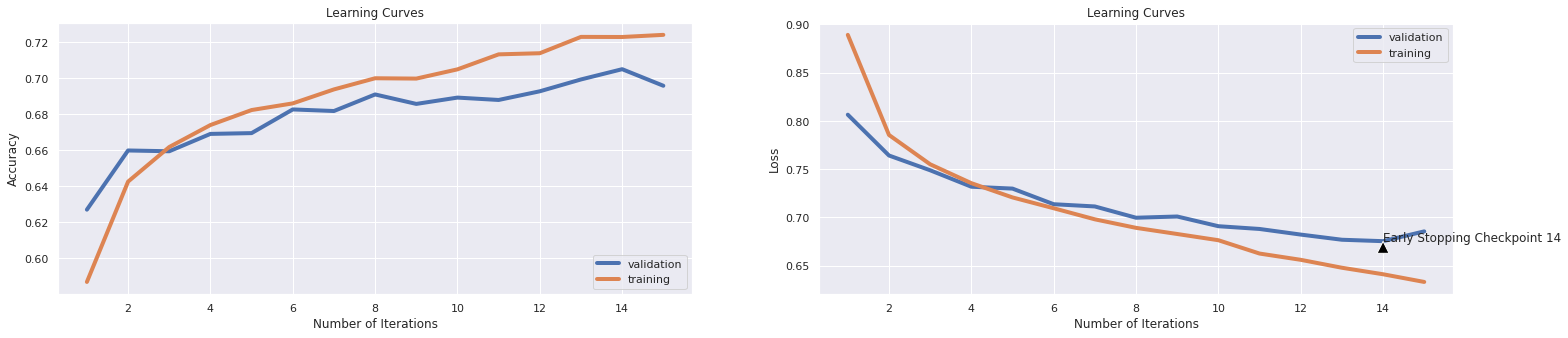

              precision    recall  f1-score
neutral        0.751547  0.798122  0.774135
antivax        0.659091  0.195946  0.302083
provax         0.639699  0.738328  0.685484
macro avg      0.683446  0.577465  0.587234
weighted avg   0.694413  0.695881  0.677126


**Accuracy: 0.69588** 



Total time: 38.47 seconds

Best grid is: Grid Search: 5, Type: GRU, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: None, Max clipping: None, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None



In [ ]:
param_grid = {
  'types': ['LSTM', 'GRU'],
  'hidden_dimensions': [64],
  'layers_info': [{'stacks': 2, 'skip': None}],
  'max_clip_norms': [None, 1, 5, 10],
  'dropout_rates': [None],
  'encoding_stategies': ['LAST_STATES'],
  'bidirectional': True,
  'sequence_length': 50,
  'learning_rates': [{'val' : 3e-4, 'schelduler': None}],
  'classes': ['neutral', 'antivax', 'provax'],
  'batch_size': 128,
  'epochs': 15,
  'early_stopping_patience': 3,
  'L2_reg': 0,
  'accuracy_threshold': 0.68
}

customGridSearch(param_grid, glove_training_set, glove_validation_set, embedding_matrix)

### **Dropout rate evaluation: Small dropout rate vs Medium dropout rate vs Large dropout rate**

**Grid Search: 1, Type: LSTM, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: 0.2, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5562093139709564, 0.6251877816725088, 0.6414621932899349, 0.6492238357536304, 0.6616174261392088, 0.6675012518778167, 0.6740736104156234, 0.6830245368052078, 0.6857160741111668, 0.6884076114171257, 0.6914121181772659, 0.6944792188282424, 0.6989859789684527, 0.7033049574361542, 0.7053705558337506]
Validation accuracy scores: [0.6279579316389132, 0.6459246275197196, 0.6599474145486416, 0.6687116564417178, 0.6722173531989483, 0.6770376862401403, 0.6853637160385626, 0.686678352322524, 0.686678352322524, 0.686678352322524, 0.6910604732690623, 0.6954425942156004, 0.6862401402278703, 0.6971954425942156, 0.6958808063102542]
Training f1 scores: [0.5099595121400893, 0.5832899745270784, 0.6114581630868355, 0.6260918643054679, 0.6418584296192313, 0.6493614761487285, 0.6565843428986425, 0.6673520733458645, 0.6700022665081935, 0.6734705587841573, 0.676789309878518, 0.6821112490060945, 0.6858024953814147, 0.6913551754265866, 0.6944820431694521]
Validation f1 scores: [0.58

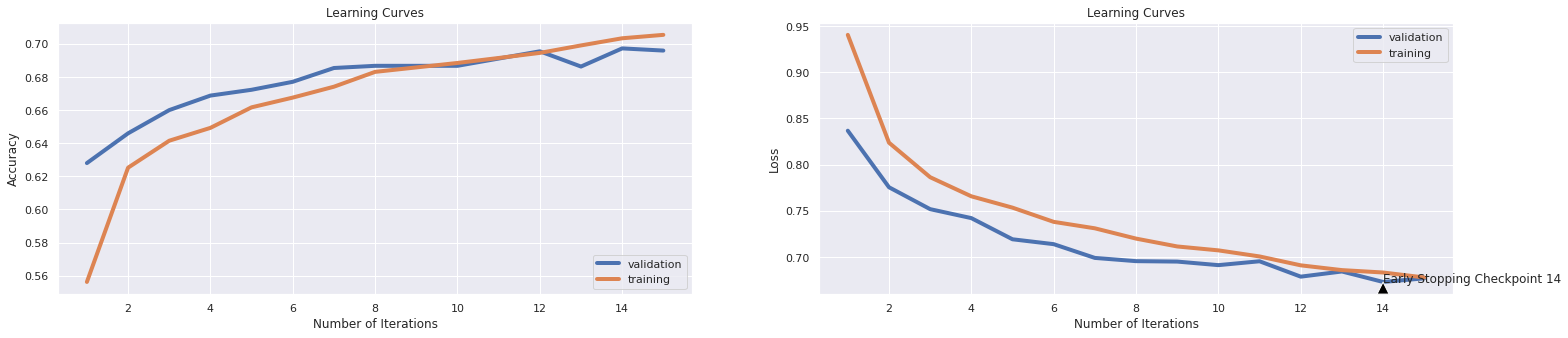

              precision    recall  f1-score
neutral        0.822319  0.712676  0.763581
antivax        0.500000  0.371622  0.426357
provax         0.631255  0.780673  0.698058
macro avg      0.651191  0.621657  0.629332
weighted avg   0.703399  0.695881  0.693395


**Accuracy: 0.69588** 



Total time: 40.31 seconds


**Grid Search: 2, Type: LSTM, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: 0.4, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5394967451176765, 0.6082874311467201, 0.6254381572358538, 0.6379569354031046, 0.6491612418627942, 0.6559839759639459, 0.6556084126189284, 0.6608662994491737, 0.6659989984977466, 0.6691286930395594, 0.6710691036554832, 0.6755758637956936, 0.6768903355032548, 0.6781422133199799, 0.6783299949924887]
Validation accuracy scores: [0.6073619631901841, 0.6301489921121823, 0.6498685363716039, 0.6577563540753725, 0.6599474145486416, 0.6691498685363716, 0.663453111305872, 0.6822962313759859, 0.6809815950920245, 0.6818580192813322, 0.6818580192813322, 0.6805433829973707, 0.6814198071866784, 0.686678352322524, 0.6871165644171779]
Training f1 scores: [0.47717717673093113, 0.5680637393502012, 0.5928665078419754, 0.6118857454248954, 0.6244046686748691, 0.6338741401721917, 0.6337258479454597, 0.6407357080357037, 0.6475563100660097, 0.6522798487138244, 0.6542862329633761, 0.6601516561886862, 0.6604710493144781, 0.6627680917223085, 0.6628966517039818]
Validation f1 scores: [0

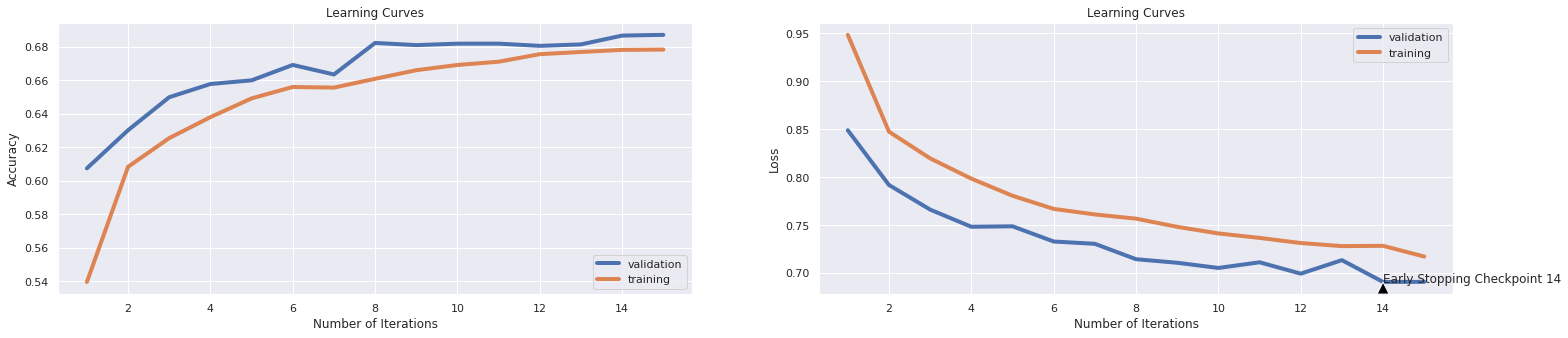

              precision    recall  f1-score
neutral        0.783300  0.739906  0.760985
antivax        0.529762  0.300676  0.383621
provax         0.623646  0.750271  0.681124
macro avg      0.645569  0.596951  0.608576
weighted avg   0.685978  0.687117  0.679805


**Accuracy: 0.68712** 



Total time: 39.84 seconds


**Grid Search: 3, Type: LSTM, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: 0.6, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5341762643965949, 0.5880070105157736, 0.5972083124687031, 0.6067225838758137, 0.6143590385578368, 0.6258137205808713, 0.6287556334501753, 0.6319479218828242, 0.6378943415122684, 0.6368302453680521, 0.6463445167751627, 0.6439659489233851, 0.6474712068102153, 0.6516024036054081, 0.6522909364046069]
Validation accuracy scores: [0.5784399649430324, 0.6209465381244522, 0.6240140227870289, 0.6463628396143734, 0.654250657318142, 0.6595092024539877, 0.6709027169149868, 0.6722173531989483, 0.6757230499561788, 0.6735319894829097, 0.6647677475898335, 0.6735319894829097, 0.6818580192813322, 0.670464504820333, 0.670464504820333]
Training f1 scores: [0.47768027608162106, 0.5481447421828655, 0.5574793692918951, 0.5741922793325968, 0.5832731431572488, 0.6000692553678255, 0.6008536862188625, 0.6075188192057672, 0.6142558426737003, 0.6142937050510958, 0.6221725100976623, 0.6222424656613428, 0.6250740525666506, 0.6278385830619941, 0.6312620695212948]
Validation f1 scores: [0.

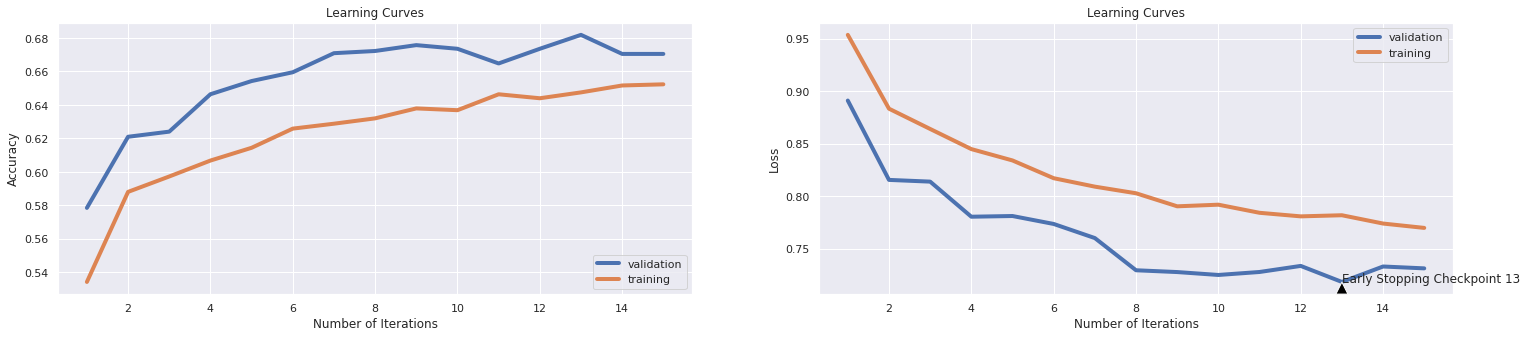

              precision    recall  f1-score
neutral        0.814351  0.671362  0.735975
antivax        0.514124  0.307432  0.384778
provax         0.590057  0.786102  0.674115
macro avg      0.639511  0.588299  0.598290
weighted avg   0.684885  0.670465  0.665455


**Accuracy: 0.67046** 



Total time: 39.58 seconds


**Grid Search: 4, Type: GRU, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: 0.2, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.563470205307962, 0.6232473710565849, 0.6382073109664497, 0.6560465698547822, 0.6626815222834251, 0.6628693039559339, 0.670756134201302, 0.6737606409614422, 0.6830245368052078, 0.682085628442664, 0.6864046069103655, 0.6907861792689034, 0.6909113670505759, 0.6930395593390085, 0.6981096644967452]
Validation accuracy scores: [0.6091148115687993, 0.6459246275197196, 0.6450482033304119, 0.6695880806310254, 0.6722173531989483, 0.6730937773882559, 0.6814198071866784, 0.6831726555652936, 0.6849255039439088, 0.689307624890447, 0.6849255039439088, 0.6888694127957932, 0.6923751095530236, 0.6897458369851008, 0.6906222611744084]
Training f1 scores: [0.5209837601152244, 0.5889518404005981, 0.6133501284663657, 0.6329094956125818, 0.6404247526911814, 0.6434068313326463, 0.6500086232835144, 0.6550718351246484, 0.6655666885190595, 0.6656044627377674, 0.671567503817592, 0.6758177792030771, 0.6770797357755645, 0.6784371895366185, 0.6864271510482786]
Validation f1 scores: [0.569

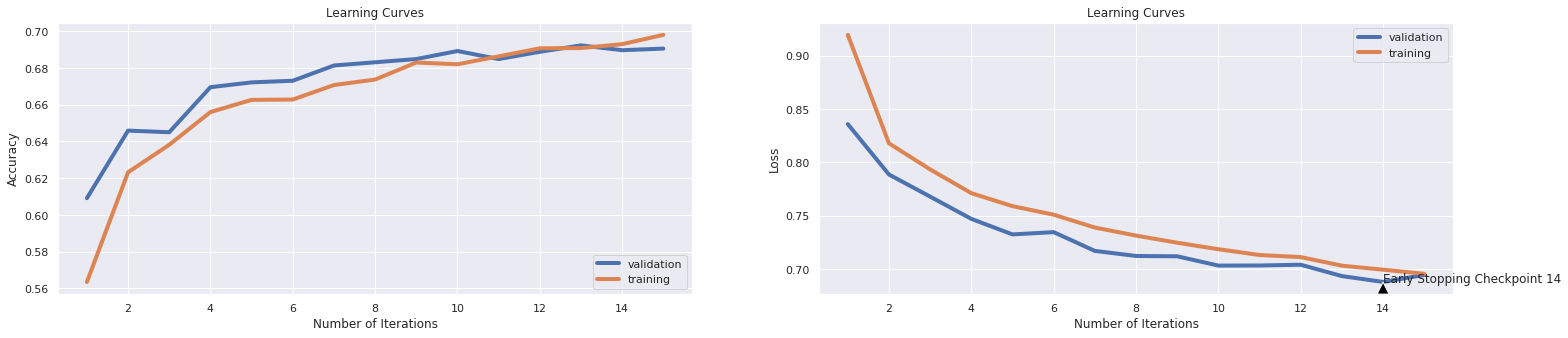

              precision    recall  f1-score
neutral        0.831672  0.705164  0.763211
antivax        0.608247  0.199324  0.300254
provax         0.597504  0.831705  0.695415
macro avg      0.679141  0.578731  0.586294
weighted avg   0.708183  0.690622  0.675799


**Accuracy: 0.69062** 



Total time: 38.43 seconds


**Grid Search: 5, Type: GRU, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: 0.4, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5475087631447171, 0.6065973960941412, 0.6190535803705558, 0.6287556334501753, 0.6351402103154732, 0.6455307961942914, 0.6445292939409114, 0.650851276915373, 0.6584251377065599, 0.661179268903355, 0.6624311467200801, 0.6658112168252378, 0.6714446670005008, 0.6718828242363545, 0.6694416624937406]
Validation accuracy scores: [0.6021034180543383, 0.6367221735319895, 0.6507449605609115, 0.6581945661700263, 0.6678352322524101, 0.6678352322524101, 0.6722173531989483, 0.6726555652936022, 0.6827344434706398, 0.6730937773882559, 0.6831726555652936, 0.6827344434706398, 0.6849255039439088, 0.6875547765118317, 0.686678352322524]
Training f1 scores: [0.5057775907244955, 0.5686975413108872, 0.5897123925075299, 0.6027973491250238, 0.6124332983957188, 0.6228909583162444, 0.6221136910704768, 0.6298298924104941, 0.6368361932362867, 0.6410747021175787, 0.6406537610112735, 0.6467632457497071, 0.6533054582586699, 0.6535250093454855, 0.6516612098586093]
Validation f1 scores: [0.5

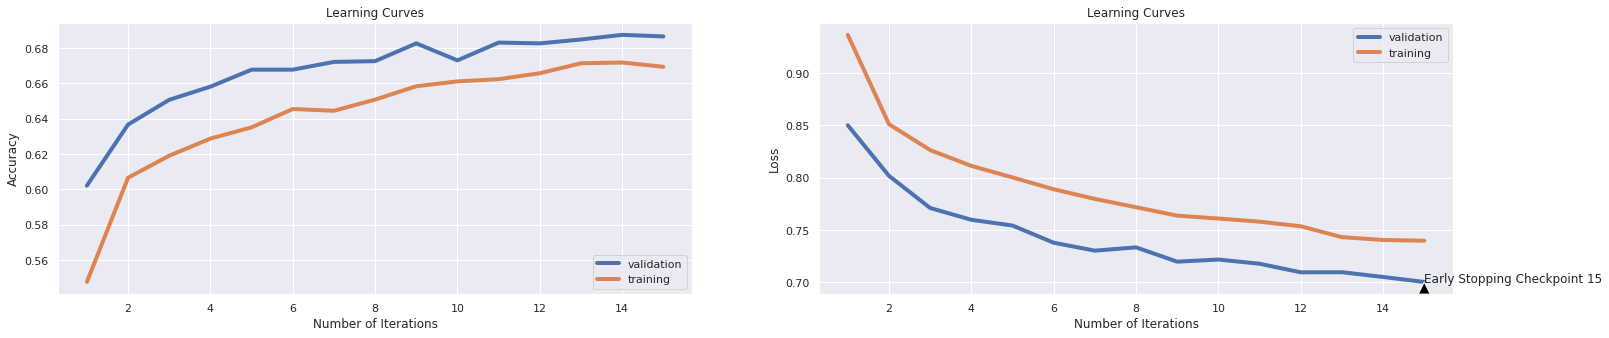

              precision    recall  f1-score
neutral        0.760036  0.782160  0.770939
antivax        0.533333  0.270270  0.358744
provax         0.631274  0.710098  0.668370
macro avg      0.641548  0.587509  0.599351
weighted avg   0.678663  0.686678  0.676077


**Accuracy: 0.68668** 



Total time: 38.56 seconds


**Grid Search: 6, Type: GRU, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: 0.6, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.514521782674011, 0.5720455683525288, 0.592513770655984, 0.5997746619929895, 0.6034051076614922, 0.6132949424136205, 0.6124812218327491, 0.6181772658988482, 0.6273159739609414, 0.6263770655983976, 0.627941912869304, 0.6319479218828242, 0.6350150225338007, 0.6377065598397597, 0.6407110665998998]
Validation accuracy scores: [0.5929009640666082, 0.6231375985977213, 0.6323400525854513, 0.635407537248028, 0.6454864154250657, 0.6577563540753725, 0.6573181419807187, 0.6573181419807187, 0.6652059596844873, 0.6647677475898335, 0.6739702015775635, 0.6669588080631026, 0.6722173531989483, 0.6752848378615249, 0.6673970201577564]
Training f1 scores: [0.4734274654015808, 0.534070133487748, 0.5570101714899388, 0.5673121796553008, 0.5722446248590377, 0.5850836775540879, 0.5875450877115365, 0.5917494982045012, 0.6004034756933261, 0.5994822110299649, 0.6002085222567111, 0.6051450710608479, 0.6100903615850852, 0.6127542998414904, 0.6148401161984246]
Validation f1 scores: [0.545

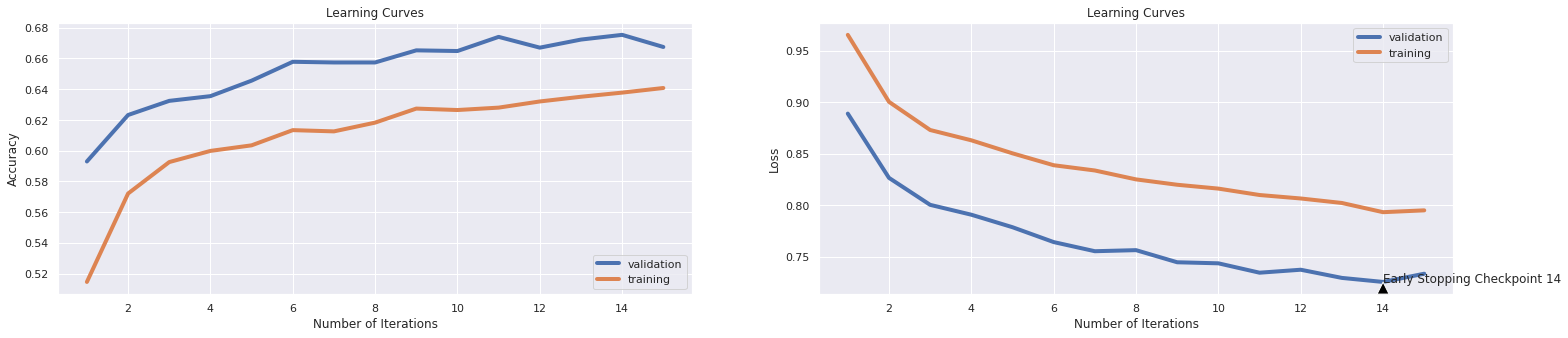

              precision    recall  f1-score
neutral        0.809735  0.687324  0.743525
antivax        0.611940  0.138514  0.225895
provax         0.572082  0.814332  0.672043
macro avg      0.664586  0.546723  0.547154
weighted avg   0.688164  0.667397  0.647533


**Accuracy: 0.66740** 



Total time: 38.57 seconds

Best grid is: Grid Search: 4, Type: GRU, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: 0.2, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None



In [ ]:
param_grid = {
  'types': ['LSTM', 'GRU'],
  'hidden_dimensions': [64],
  'layers_info': [{'stacks': 2, 'skip': None}],
  'max_clip_norms': [5],
  'dropout_rates': [0.2, 0.4, 0.6],
  'encoding_stategies': ['LAST_STATES'],
  'bidirectional': True,
  'sequence_length': 50,
  'learning_rates': [{'val' : 3e-4, 'schelduler': None}],
  'classes': ['neutral', 'antivax', 'provax'],
  'batch_size': 128,
  'epochs': 15,
  'early_stopping_patience': 3,
  'L2_reg': 0,
  'accuracy_threshold': 0.68
}

customGridSearch(param_grid, glove_training_set, glove_validation_set, embedding_matrix)

### **Encoding evaluation: Last state (of forward) vs Last states (of forward and backward) vs Mean of all states vs Max of all states**

**Grid Search: 1, Type: LSTM, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: 0.2, Max clipping: 5, Encoding strategy: LAST STATE, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5582749123685529, 0.6204306459689535, 0.6330120180270405, 0.6477215823735604, 0.6557961942914372, 0.6591136705057586, 0.6691286930395594, 0.6701927891837757, 0.678392588883325, 0.6836504757135704, 0.6848397596394592, 0.6841512268402604, 0.6949799699549324, 0.697608913370055, 0.6977341011517276]
Validation accuracy scores: [0.6240140227870289, 0.6489921121822962, 0.6503067484662577, 0.656441717791411, 0.6691498685363716, 0.6673970201577564, 0.6682734443470639, 0.677475898334794, 0.6814198071866784, 0.6831726555652936, 0.686678352322524, 0.6910604732690623, 0.6980718667835232, 0.6888694127957932, 0.6985100788781771]
Training f1 scores: [0.4943111862100153, 0.5799640649866825, 0.5985919461726914, 0.6236252293823497, 0.6352662151094248, 0.6400221778701006, 0.6536794702349775, 0.6546117700549267, 0.664831935591194, 0.6675100667017928, 0.6699970335945402, 0.6708501389124316, 0.6807759391582608, 0.6847116531147213, 0.6857905301441616]
Validation f1 scores: [0.5835

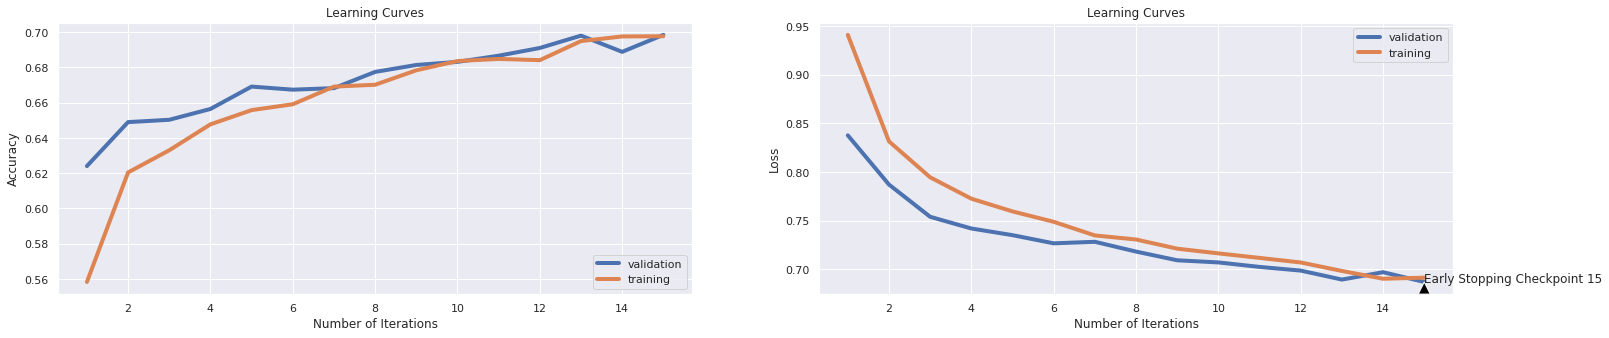

              precision    recall  f1-score
neutral        0.757658  0.789671  0.773333
antivax        0.572414  0.280405  0.376417
provax         0.652386  0.727470  0.687885
macro avg      0.660819  0.599182  0.612545
weighted avg   0.691142  0.698510  0.687363


**Accuracy: 0.69851** 



Total time: 39.78 seconds


**Grid Search: 2, Type: LSTM, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: 0.2, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5550826239359039, 0.6300075112669004, 0.6380821231847772, 0.6485353029544316, 0.6649349023535303, 0.6689409113670506, 0.670756134201302, 0.6764521782674011, 0.6817726589884827, 0.6852153229844767, 0.689221331997997, 0.6930395593390085, 0.6977341011517276, 0.6979844767150726, 0.7039308963445168]
Validation accuracy scores: [0.6047326906222612, 0.6375985977212971, 0.6625766871165644, 0.670464504820333, 0.6709027169149868, 0.6717791411042945, 0.6779141104294478, 0.6809815950920245, 0.6801051709027169, 0.6853637160385626, 0.6897458369851008, 0.6910604732690623, 0.6936897458369851, 0.6901840490797546, 0.6888694127957932]
Training f1 scores: [0.5017705911166661, 0.5890715513731672, 0.607864748352837, 0.6258828762826536, 0.6456161872557411, 0.6505171711320793, 0.6530842477928801, 0.6594412462182565, 0.6638923701170927, 0.6705019617058067, 0.6738665130286225, 0.6795843100526736, 0.6854684382159244, 0.6844245371587354, 0.6929817861272966]
Validation f1 scores: [0.55

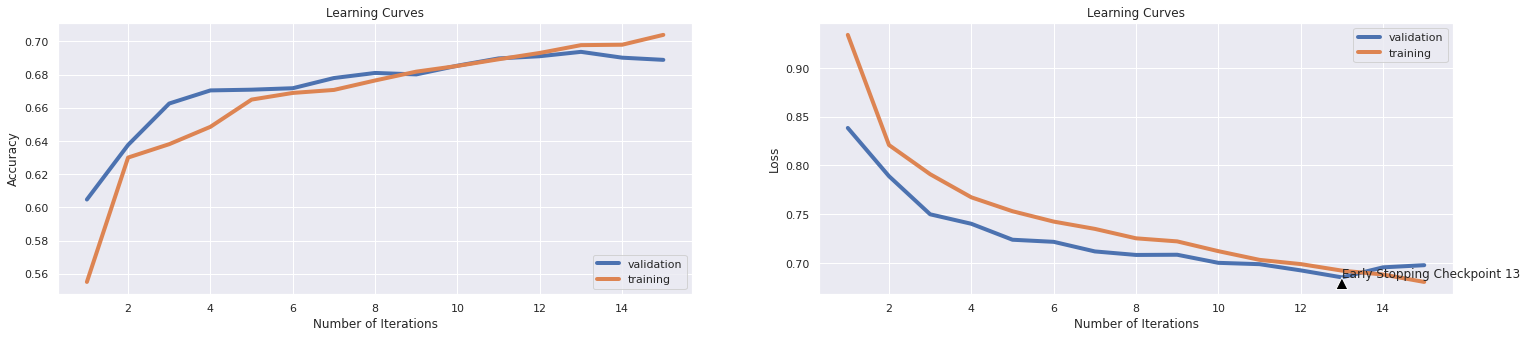

              precision    recall  f1-score
neutral        0.846154  0.681690  0.755070
antivax        0.471910  0.425676  0.447602
provax         0.622299  0.781759  0.692974
macro avg      0.646788  0.629708  0.631882
weighted avg   0.707264  0.688869  0.690127


**Accuracy: 0.68887** 



Total time: 39.75 seconds


**Grid Search: 3, Type: LSTM, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: 0.2, Max clipping: 5, Encoding strategy: MEAN OF STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5478217325988983, 0.6236229344016024, 0.6405232849273911, 0.6531046569854783, 0.6586755132699048, 0.6638708062093139, 0.6721957936905358, 0.6778292438657987, 0.6792689033550325, 0.6804581872809213, 0.6838382573860792, 0.693665498247371, 0.6926014021031547, 0.6960440660991487, 0.6985478217325989]
Validation accuracy scores: [0.619193689745837, 0.6481156879929886, 0.6560035056967572, 0.6586327782646801, 0.6656441717791411, 0.6783523225241017, 0.6730937773882559, 0.6814198071866784, 0.6801051709027169, 0.6836108676599474, 0.6914986853637161, 0.6906222611744084, 0.6914986853637161, 0.6936897458369851, 0.6906222611744084]
Training f1 scores: [0.5007437213130465, 0.5856520922635359, 0.613068939541114, 0.6274555883545062, 0.6366487001778928, 0.6434683626212097, 0.653750206088851, 0.6610800770101691, 0.6630515326807953, 0.6655399914124345, 0.668753598373914, 0.6801620124547544, 0.6790321579025286, 0.6820929608089364, 0.6863695634164797]
Validation f1 scores: [0.577

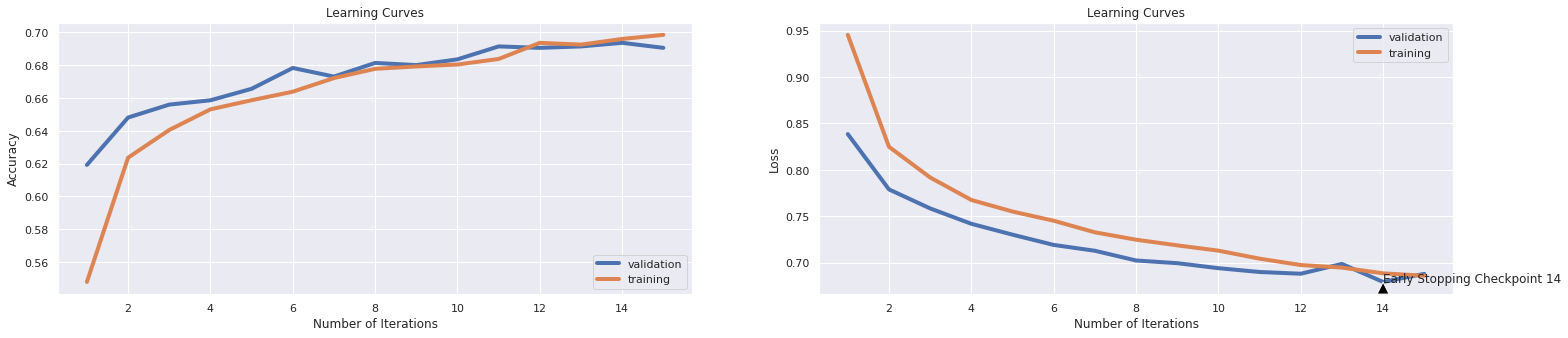

              precision    recall  f1-score
neutral        0.830735  0.700469  0.760061
antivax        0.640449  0.192568  0.296104
provax         0.596911  0.839305  0.697653
macro avg      0.689365  0.577447  0.584606
weighted avg   0.711683  0.690622  0.674694


**Accuracy: 0.69062** 



Total time: 58.72 seconds


**Grid Search: 4, Type: LSTM, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: 0.2, Max clipping: 5, Encoding strategy: MAX OF STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5637831747621432, 0.6224962443665498, 0.646407110665999, 0.6541061592388583, 0.6639334001001502, 0.6683775663495243, 0.6770781171757636, 0.6810215322984476, 0.6832749123685529, 0.6867175763645468, 0.6929769654481722, 0.6979218828242364, 0.6974837255883826, 0.7013019529293941, 0.703492739108663]
Validation accuracy scores: [0.6205083260297984, 0.647239263803681, 0.6652059596844873, 0.6665205959684487, 0.6783523225241017, 0.6822962313759859, 0.6814198071866784, 0.6901840490797546, 0.6897458369851008, 0.6875547765118317, 0.686678352322524, 0.6932515337423313, 0.6906222611744084, 0.6879929886064855, 0.6958808063102542]
Training f1 scores: [0.5115698700916548, 0.5811533193008499, 0.6186674563190766, 0.6315252292102032, 0.6424117030656442, 0.6494183197643865, 0.6585000300405127, 0.6635279674845104, 0.6668143008842027, 0.6703286850869042, 0.6783825597863838, 0.6838529002358061, 0.682700807576379, 0.6878376730029394, 0.6895645999859491]
Validation f1 scores: [0.579

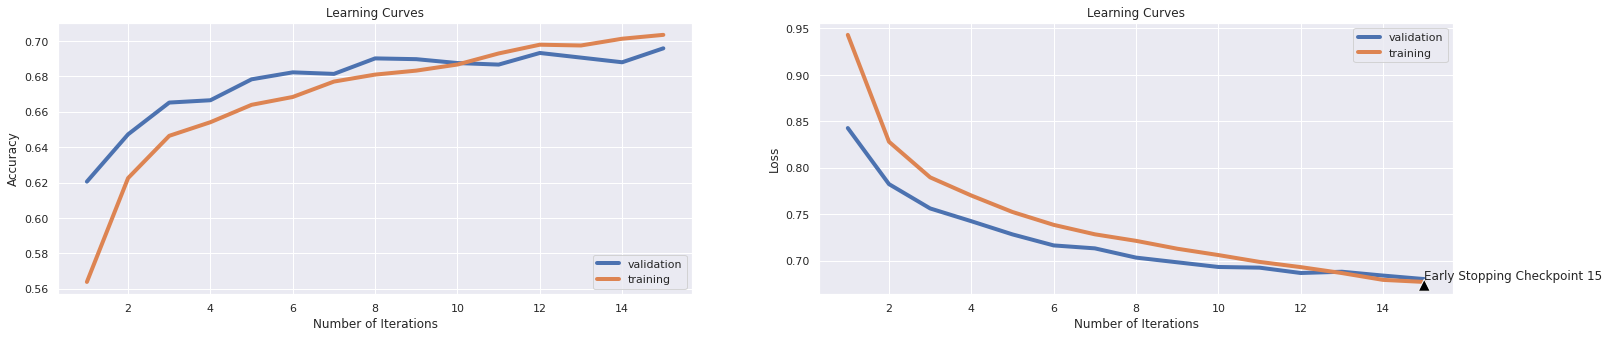

              precision    recall  f1-score
neutral        0.815595  0.726761  0.768620
antivax        0.492537  0.334459  0.398390
provax         0.631625  0.776330  0.696542
macro avg      0.646586  0.612517  0.621184
weighted avg   0.699442  0.695881  0.691507


**Accuracy: 0.69588** 



Total time: 61.95 seconds


**Grid Search: 5, Type: GRU, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: 0.2, Max clipping: 5, Encoding strategy: LAST STATE, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5456935403104657, 0.6145468202303456, 0.6346394591887832, 0.6489108662994492, 0.6539809714571858, 0.6595518277416125, 0.6664371557336004, 0.6709439158738107, 0.6711942914371557, 0.6800200300450676, 0.6842138207310966, 0.6841512268402604, 0.6901602403605408, 0.6920380570856285, 0.6932273410115173]
Validation accuracy scores: [0.6086765994741455, 0.6358457493426819, 0.6489921121822962, 0.6546888694127958, 0.6603856266432954, 0.6744084136722174, 0.6687116564417178, 0.6827344434706398, 0.6827344434706398, 0.6871165644171779, 0.6836108676599474, 0.684487291849255, 0.6906222611744084, 0.6906222611744084, 0.6914986853637161]
Training f1 scores: [0.49775924262167826, 0.5764167160629263, 0.604497563935358, 0.6262455653224471, 0.6316087877353629, 0.6413612233961096, 0.6489308595506137, 0.6544386520906575, 0.6547090238603395, 0.6643146792131817, 0.6691771779733714, 0.6701452124353022, 0.6763133011400918, 0.6787649278094768, 0.6790956583924507]
Validation f1 scores: [0

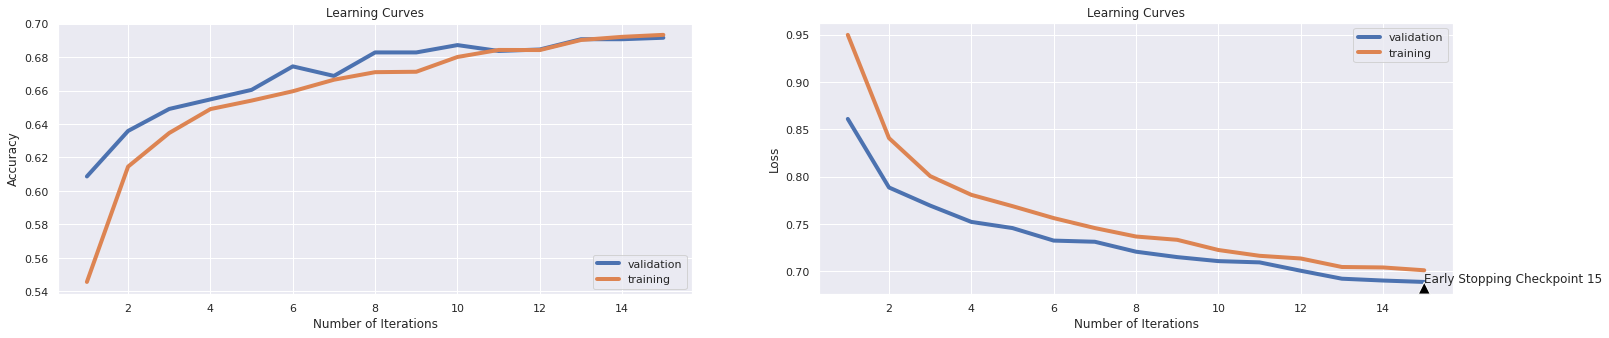

              precision    recall  f1-score
neutral        0.786853  0.741784  0.763654
antivax        0.559211  0.287162  0.379464
provax         0.624334  0.763301  0.686859
macro avg      0.656799  0.597416  0.609992
weighted avg   0.691734  0.691499  0.682826


**Accuracy: 0.69150** 



Total time: 38.15 seconds


**Grid Search: 6, Type: GRU, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: 0.2, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5738607911867801, 0.6231847771657486, 0.6405232849273911, 0.649349023535303, 0.6587381071607411, 0.6614296444667, 0.6708813219829745, 0.6745117676514772, 0.6790811216825238, 0.6823985978968453, 0.6853405107661492, 0.6879068602904357, 0.692663995993991, 0.6929769654481722, 0.69635703555333]
Validation accuracy scores: [0.6161262050832603, 0.647239263803681, 0.6643295354951797, 0.6652059596844873, 0.6717791411042945, 0.6735319894829097, 0.6787905346187555, 0.6814198071866784, 0.6901840490797546, 0.6919368974583698, 0.6950043821209465, 0.6980718667835232, 0.7002629272567923, 0.6985100788781771, 0.6950043821209465]
Training f1 scores: [0.5287991183146056, 0.5886724364926517, 0.6123678498313043, 0.6262552943130952, 0.6384160760424227, 0.6397248668563373, 0.6518175189948126, 0.6573616310116054, 0.6621847607294957, 0.665650581009862, 0.6705048468030402, 0.6725939565115227, 0.678234506762597, 0.6799723134636138, 0.6832077028463703]
Validation f1 scores: [0.57645678

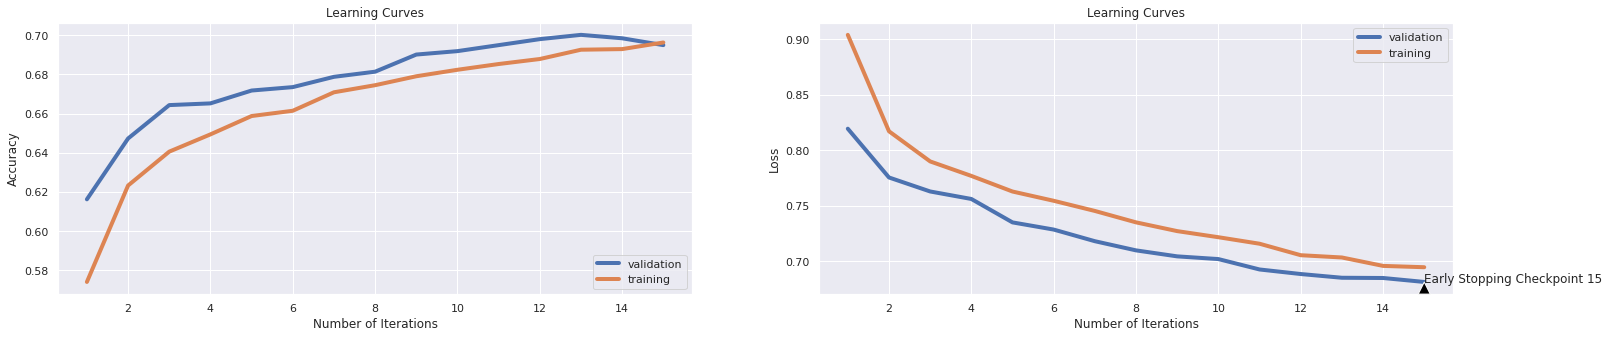

              precision    recall  f1-score
neutral        0.776852  0.787793  0.782284
antivax        0.465201  0.429054  0.446397
provax         0.667384  0.673181  0.670270
macro avg      0.636479  0.630010  0.632984
weighted avg   0.692247  0.695004  0.693508


**Accuracy: 0.69500** 



Total time: 38.43 seconds


**Grid Search: 7, Type: GRU, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: 0.2, Max clipping: 5, Encoding strategy: MEAN OF STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5727966950425638, 0.6246244366549825, 0.6367050575863795, 0.651352028042063, 0.6572984476715072, 0.6629318978467702, 0.6730095142714071, 0.6755132699048573, 0.6759514271407111, 0.6795818728092138, 0.684526790185278, 0.6834626940410616, 0.6875312969454181, 0.6909739609414122, 0.6944792188282424]
Validation accuracy scores: [0.6073619631901841, 0.6529360210341806, 0.6599474145486416, 0.6573181419807187, 0.6730937773882559, 0.6748466257668712, 0.6757230499561788, 0.6818580192813322, 0.6801051709027169, 0.6875547765118317, 0.6967572304995618, 0.6923751095530236, 0.6967572304995618, 0.6936897458369851, 0.6936897458369851]
Training f1 scores: [0.5256658606825145, 0.5888843016012895, 0.6144681650782078, 0.6273912067360389, 0.6342635169451911, 0.6430888599855246, 0.6521873863985219, 0.6573849466110484, 0.6589678616272628, 0.661337137630453, 0.6676744977762291, 0.6680501610850462, 0.6721228519306616, 0.6770416010193719, 0.6803861540642906]
Validation f1 scores: [0.5

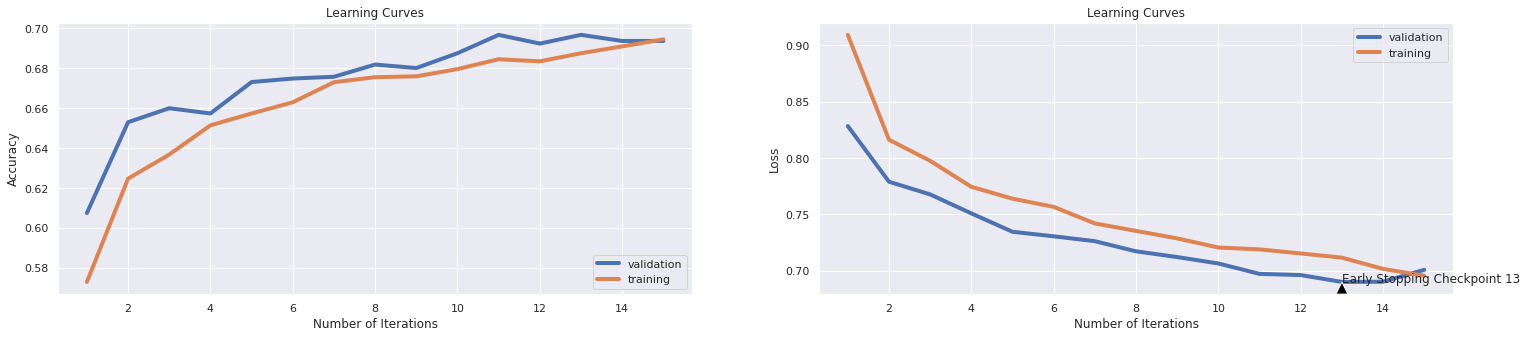

              precision    recall  f1-score
neutral        0.844626  0.678873  0.752733
antivax        0.655172  0.256757  0.368932
provax         0.598473  0.851249  0.702824
macro avg      0.699424  0.595626  0.608163
weighted avg   0.720706  0.693690  0.682807


**Accuracy: 0.69369** 



Total time: 57.02 seconds


**Grid Search: 8, Type: GRU, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: 0.2, Max clipping: 5, Encoding strategy: MAX OF STATES, Learning rate: 0.0003, Schelduler: None**

Training accuracy scores: [0.5709188783174762, 0.6357035553329995, 0.6475338007010516, 0.6561091637456185, 0.6607411116675013, 0.6705057586379569, 0.6728217325988983, 0.6795818728092138, 0.6817100650976464, 0.6849023535302955, 0.6909113670505759, 0.6934777165748623, 0.6947921882824236, 0.6989233850776164, 0.699799699549324]
Validation accuracy scores: [0.6082383873794917, 0.6590709903593339, 0.6673970201577564, 0.6678352322524101, 0.6818580192813322, 0.686678352322524, 0.6910604732690623, 0.6901840490797546, 0.6901840490797546, 0.6936897458369851, 0.6936897458369851, 0.6879929886064855, 0.7011393514461, 0.7007011393514461, 0.7059596844872918]
Training f1 scores: [0.5235389013252602, 0.6007625259625373, 0.6199087058127006, 0.6338947890847905, 0.6380077454836253, 0.6505628170021314, 0.6528954722588074, 0.6613659836461478, 0.6623199224731682, 0.6677849227540434, 0.6735411537039274, 0.6772213213913841, 0.678746583071117, 0.6852931657437746, 0.6844754741969336]
Validation f1 scores: [0.5564

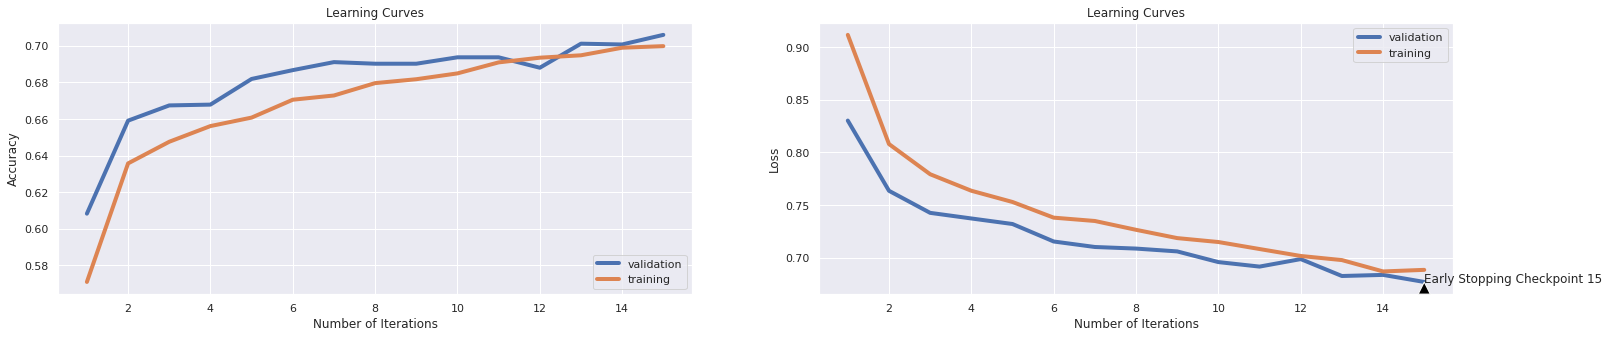

              precision    recall  f1-score
neutral        0.787560  0.772770  0.780095
antivax        0.576389  0.280405  0.377273
provax         0.645014  0.765472  0.700099
macro avg      0.669654  0.606216  0.619156
weighted avg   0.702638  0.705960  0.695559


**Accuracy: 0.70596** 



Total time: 60.61 seconds

Best grid is: Grid Search: 8, Type: GRU, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: 0.2, Max clipping: 5, Encoding strategy: MAX OF STATES, Learning rate: 0.0003, Schelduler: None



In [ ]:
param_grid = {
  'types': ['LSTM', 'GRU'],
  'hidden_dimensions': [64],
  'layers_info': [{'stacks': 2, 'skip': None}],
  'max_clip_norms': [5],
  'dropout_rates': [0.2],
  'encoding_stategies': ['LAST_STATE', 'LAST_STATES', 'MEAN_OF_STATES', 'MAX_OF_STATES'],
  'bidirectional': True,
  'sequence_length': 50,
  'learning_rates': [{'val' : 3e-4, 'schelduler': None}],
  'classes': ['neutral', 'antivax', 'provax'],
  'batch_size': 128,
  'epochs': 15,
  'early_stopping_patience': 3,
  'L2_reg': 0,
  'accuracy_threshold': 0.68
}

customGridSearch(param_grid, glove_training_set, glove_validation_set, embedding_matrix)

### **Putting all together now**

**Grid Search: 1, Type: LSTM, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: 0.2, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: Performance**

Training accuracy scores: [0.556835252879319, 0.6266900350525789, 0.6446544817225839, 0.6529794692038057, 0.6653104656985478, 0.6734476715072609, 0.6775162744116174, 0.6834626940410616, 0.6873435152729094, 0.6880946419629445, 0.6930395593390085, 0.696106659989985, 0.6984852278417626, 0.7033675513269905, 0.7043064596895343, 0.7043690535803706, 0.7114421632448673, 0.7091887831747622, 0.710378067100651, 0.7155733600400601, 0.722458688032048, 0.7213319979969955, 0.721957936905358, 0.7234601902854282, 0.7297195793690536, 0.7276539809714572, 0.7284677015523285]
Validation accuracy scores: [0.612182296231376, 0.647239263803681, 0.6568799298860648, 0.6617002629272568, 0.6669588080631026, 0.6761612620508326, 0.679666958808063, 0.6770376862401403, 0.6827344434706398, 0.6875547765118317, 0.6901840490797546, 0.6849255039439088, 0.694127957931639, 0.6928133216476775, 0.6910604732690623, 0.6967572304995618, 0.6980718667835232, 0.694127957931639, 0.6950043821209465, 0.6976336546888694, 0.698948290972

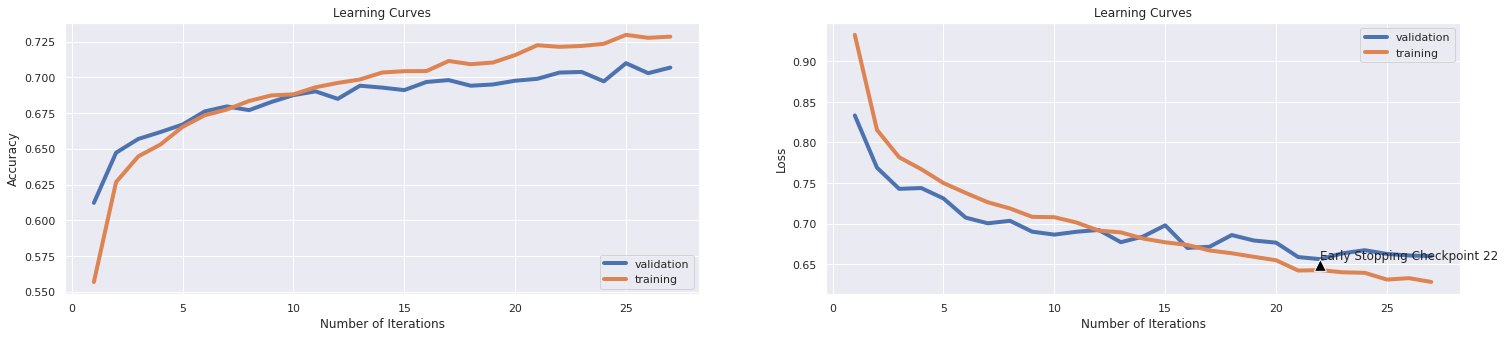

              precision    recall  f1-score
neutral        0.823656  0.719249  0.767920
antivax        0.543478  0.422297  0.475285
provax         0.643494  0.783931  0.706804
macro avg      0.670209  0.641826  0.650003
weighted avg   0.714602  0.706836  0.705296


**Accuracy: 0.70684** 



Total time: 70.99 seconds


**Grid Search: 2, Type: LSTM, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: 0.4, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: Performance**

Training accuracy scores: [0.5455683525287932, 0.6062218327491237, 0.6157361041562344, 0.6305708562844267, 0.6370180270405609, 0.6469704556835253, 0.649849774661993, 0.6539809714571858, 0.6547946920380571, 0.6581747621432148, 0.6663745618427641, 0.6686905358037055, 0.6704431647471207, 0.671757636454682, 0.6777666499749625, 0.6776414621932899, 0.6809589384076115, 0.6823985978968453, 0.6822108162243365, 0.6839008512769154, 0.6836504757135704, 0.6882824236354532, 0.6887205808713069, 0.693164747120681, 0.6944166249374061]
Validation accuracy scores: [0.5972830850131463, 0.6240140227870289, 0.642418930762489, 0.6397896581945661, 0.6560035056967572, 0.6726555652936022, 0.6761612620508326, 0.6730937773882559, 0.6603856266432954, 0.670464504820333, 0.6770376862401403, 0.679666958808063, 0.6792287467134093, 0.6884312007011394, 0.6862401402278703, 0.6840490797546013, 0.6945661700262927, 0.6853637160385626, 0.6858019281332165, 0.689307624890447, 0.6836108676599474, 0.6932515337423313, 0.687992988

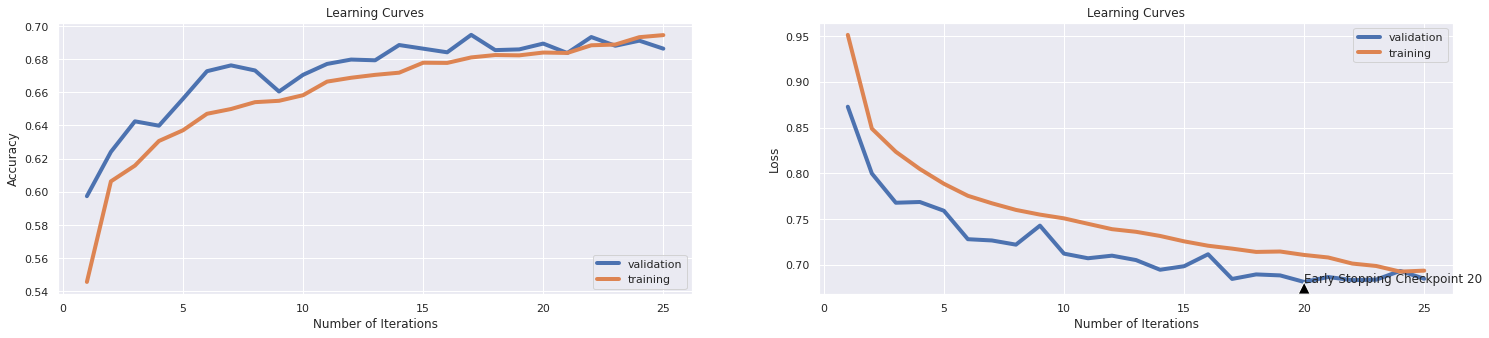

              precision    recall  f1-score
neutral        0.819869  0.705164  0.758203
antivax        0.545455  0.263514  0.355353
provax         0.602617  0.800217  0.687500
macro avg      0.655980  0.589632  0.600352
weighted avg   0.696593  0.686240  0.677414


**Accuracy: 0.68624** 



Total time: 65.66 seconds


**Grid Search: 3, Type: LSTM, Hidden size: 128, Stacks: 2, Skip layers: None, Dropout: 0.2, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: Performance**

Training accuracy scores: [0.582185778668002, 0.6333875813720581, 0.6497245868803205, 0.659677015523285, 0.6675012518778167, 0.6785803705558338, 0.682085628442664, 0.6870305458187281, 0.6944166249374061, 0.6950425638457687, 0.7041186780170255, 0.7066224336504757, 0.7071231847771657, 0.7138833249874812, 0.7131947921882824, 0.7202679018527791, 0.7242739108662994, 0.7277791687531296, 0.7306584877315974, 0.7341011517275914, 0.7379819729594391, 0.7496870305458188]
Validation accuracy scores: [0.6380368098159509, 0.6533742331288344, 0.6625766871165644, 0.6801051709027169, 0.6722173531989483, 0.6831726555652936, 0.6849255039439088, 0.6871165644171779, 0.6822962313759859, 0.6901840490797546, 0.6950043821209465, 0.689307624890447, 0.6910604732690623, 0.6958808063102542, 0.6967572304995618, 0.6932515337423313, 0.7050832602979842, 0.6967572304995618, 0.6989482909728308, 0.7007011393514461, 0.6989482909728308, 0.7024539877300614]
Training f1 scores: [0.530627744354534, 0.6009530280560025, 0.624081

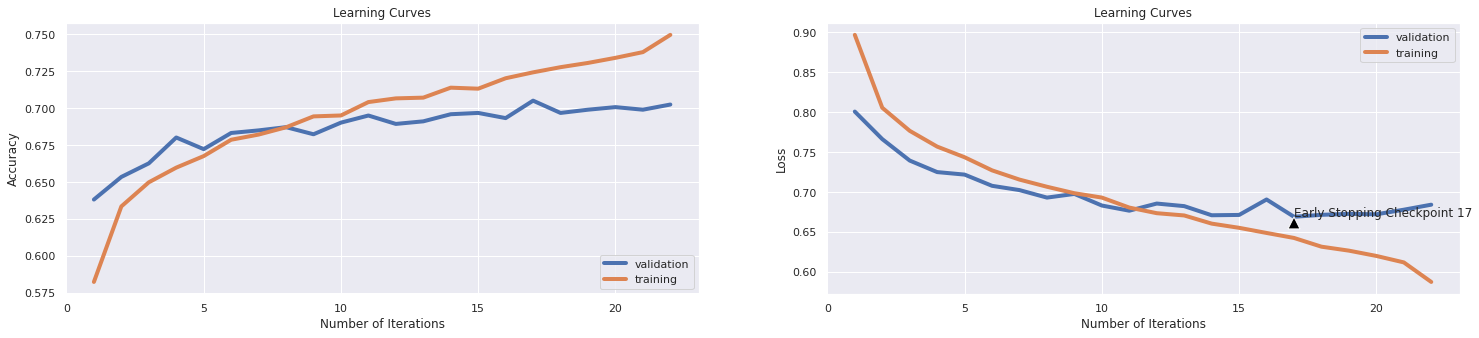

              precision    recall  f1-score
neutral        0.851039  0.692019  0.763335
antivax        0.525896  0.445946  0.482633
provax         0.630043  0.796960  0.703739
macro avg      0.668993  0.644975  0.649902
weighted avg   0.719672  0.702454  0.702872


**Accuracy: 0.70245** 



Total time: 61.01 seconds


**Grid Search: 4, Type: LSTM, Hidden size: 128, Stacks: 2, Skip layers: None, Dropout: 0.4, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: Performance**

Training accuracy scores: [0.572608913370055, 0.6186780170255383, 0.6295693540310465, 0.6484101151727591, 0.6444041061592388, 0.6544191286930395, 0.6554206309464197, 0.6644967451176765, 0.6671882824236355, 0.6756384576865297, 0.6742613920881322, 0.6788307461191788, 0.6865923885828743, 0.6822734101151727, 0.6852779168753129, 0.6878442663995994, 0.6961692538808212, 0.6911617426139208, 0.6991737606409615, 0.6972333500250375, 0.6991737606409615, 0.7006134201301953, 0.7036179268903355, 0.7028042063094642, 0.7079369053580371, 0.7085628442663996, 0.7123810716074112, 0.7059964947421131, 0.7099399098647972, 0.71457185778668, 0.7121932899349024, 0.7187656484727091, 0.7151977966950426, 0.7129444166249375, 0.7168878317476214]
Validation accuracy scores: [0.6288343558282209, 0.6380368098159509, 0.6454864154250657, 0.6660823838737949, 0.6687116564417178, 0.6765994741454864, 0.6792287467134093, 0.6792287467134093, 0.6840490797546013, 0.679666958808063, 0.6897458369851008, 0.6923751095530236, 0.687992

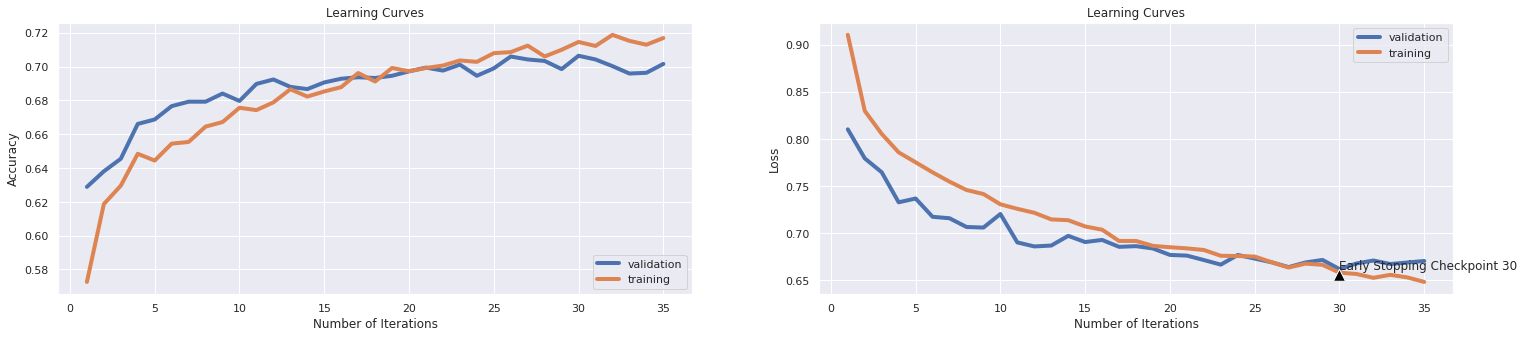

              precision    recall  f1-score
neutral        0.855814  0.691080  0.764675
antivax        0.528139  0.412162  0.462998
provax         0.623846  0.806732  0.703598
macro avg      0.669266  0.636658  0.643757
weighted avg   0.719690  0.701578  0.700894


**Accuracy: 0.70158** 



Total time: 97.11 seconds


**Grid Search: 5, Type: LSTM, Hidden size: 64, Stacks: 3, Skip layers: None, Dropout: 0.2, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: Performance**

Training accuracy scores: [0.5577741612418627, 0.6266274411617426, 0.6411492238357537, 0.6534176264396595, 0.6630570856284427, 0.6721331997996995, 0.671757636454682, 0.6770155232849274, 0.6815222834251377, 0.6879694541812719, 0.6924136204306459, 0.6924762143214822, 0.696106659989985, 0.6992363545317977, 0.7008637956935403, 0.7041186780170255, 0.707185778668002, 0.7106284426639959, 0.7125062593890836, 0.7194541812719079, 0.7203930896344517, 0.7173885828743115, 0.7235227841762644, 0.7222709063595393, 0.73178517776665, 0.7272158237356035, 0.7335378067100651, 0.7368552829243866, 0.7366675012518779, 0.7386705057586379, 0.7397971957936905, 0.743865798698047]
Validation accuracy scores: [0.6196319018404908, 0.6367221735319895, 0.6568799298860648, 0.6621384750219106, 0.6801051709027169, 0.6827344434706398, 0.6801051709027169, 0.6822962313759859, 0.6901840490797546, 0.6919368974583698, 0.6936897458369851, 0.6836108676599474, 0.6928133216476775, 0.6980718667835232, 0.7007011393514461, 0.69500438

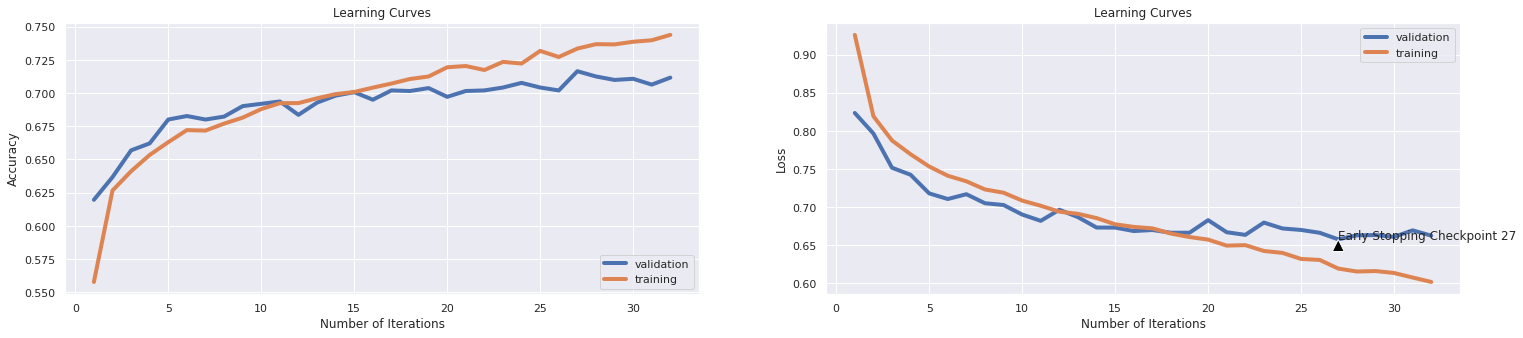

              precision    recall  f1-score
neutral        0.830128  0.729577  0.776612
antivax        0.527660  0.418919  0.467043
provax         0.650765  0.785016  0.711614
macro avg      0.669518  0.644504  0.651756
weighted avg   0.718505  0.711656  0.710225


**Accuracy: 0.71166** 



Total time: 118.80 seconds


**Grid Search: 6, Type: LSTM, Hidden size: 64, Stacks: 3, Skip layers: None, Dropout: 0.4, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: Performance**

Training accuracy scores: [0.5420005007511267, 0.6074737105658488, 0.6217451176765147, 0.6386454682023035, 0.6448422633950927, 0.6509764646970456, 0.6546695042563846, 0.6595518277416125, 0.6616174261392088, 0.6665623435152729, 0.6648097145718578, 0.6721957936905358, 0.671757636454682, 0.6756384576865297, 0.6792689033550325, 0.6794566850275413, 0.6798322483725588, 0.6874061091637457, 0.6867175763645468, 0.684526790185278, 0.6867175763645468, 0.6922258387581373, 0.6935403104656985, 0.6910991487230846, 0.6969203805708563, 0.6932273410115173, 0.6981722583875813, 0.7021782674011017, 0.7036179268903355, 0.7020530796194292, 0.7026790185277917, 0.7041186780170255, 0.7071231847771657, 0.7053705558337506, 0.7057461191787682]
Validation accuracy scores: [0.6161262050832603, 0.6389132340052586, 0.642418930762489, 0.6450482033304119, 0.6603856266432954, 0.6752848378615249, 0.677475898334794, 0.6801051709027169, 0.6792287467134093, 0.6836108676599474, 0.6787905346187555, 0.6919368974583698, 0.682296

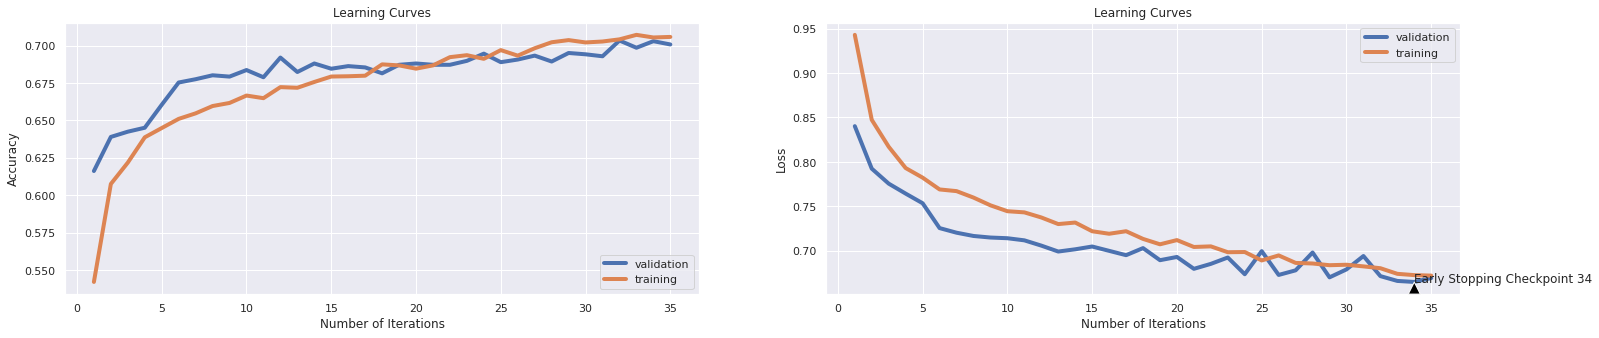

              precision    recall  f1-score
neutral        0.835920  0.707981  0.766650
antivax        0.536458  0.347973  0.422131
provax         0.624579  0.805646  0.703651
macro avg      0.665653  0.620533  0.630811
weighted avg   0.711781  0.700701  0.696536


**Accuracy: 0.70070** 



Total time: 129.37 seconds


**Grid Search: 7, Type: LSTM, Hidden size: 128, Stacks: 3, Skip layers: None, Dropout: 0.2, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: Performance**

Training accuracy scores: [0.5717951927891838, 0.6304456685027542, 0.6519153730595894, 0.6589884827240862, 0.668064596895343, 0.6773284927391087, 0.6834626940410616, 0.6836504757135704, 0.6895343014521783, 0.6910365548322484, 0.700050075112669, 0.7029919879819729, 0.7060590886329494, 0.709877315973961, 0.7151352028042063, 0.7126314471707561, 0.7195167751627441, 0.7259639459188784, 0.7291562343515273, 0.7299699549323986, 0.7316599899849775, 0.7419253880821232, 0.7443665498247372, 0.7475588382573861, 0.7574486730095142]
Validation accuracy scores: [0.6038562664329535, 0.6476774758983348, 0.6665205959684487, 0.6678352322524101, 0.6709027169149868, 0.679666958808063, 0.6831726555652936, 0.6862401402278703, 0.6888694127957932, 0.6875547765118317, 0.6919368974583698, 0.6906222611744084, 0.6980718667835232, 0.6967572304995618, 0.6954425942156004, 0.7007011393514461, 0.7055214723926381, 0.7011393514461, 0.6967572304995618, 0.7077125328659071, 0.7007011393514461, 0.7063978965819456, 0.711656441

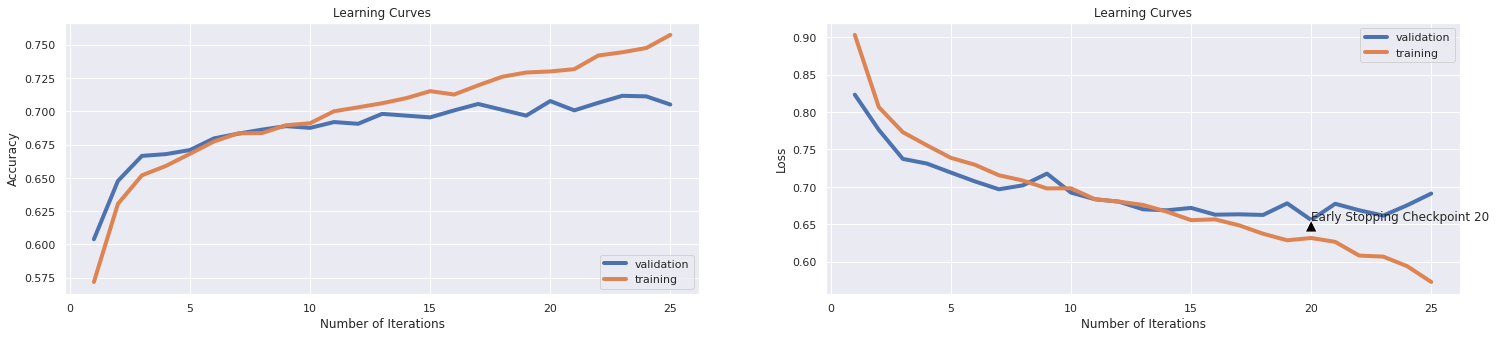

              precision    recall  f1-score
neutral        0.886816  0.669484  0.762975
antivax        0.577640  0.314189  0.407002
provax         0.609719  0.871878  0.717605
macro avg      0.691392  0.618517  0.629194
weighted avg   0.734878  0.705083  0.698490


**Accuracy: 0.70508** 



Total time: 98.09 seconds


**Grid Search: 8, Type: LSTM, Hidden size: 128, Stacks: 3, Skip layers: None, Dropout: 0.4, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: Performance**

Training accuracy scores: [0.5636579869804708, 0.6171131697546319, 0.6321982974461693, 0.64221331997997, 0.6528542814221332, 0.6631822734101152, 0.6634952428642964, 0.6698172258387581, 0.6716950425638458, 0.6764521782674011, 0.6737606409614422, 0.6852779168753129, 0.6843390085127692, 0.688970956434652, 0.6852153229844767, 0.6897846770155233, 0.6934777165748623, 0.6914747120681022, 0.700550826239359, 0.6989233850776164, 0.6992363545317977, 0.7051827741612419, 0.7044316474712068, 0.7090010015022534, 0.7086254381572359, 0.7121306960440661, 0.7131947921882824, 0.7169504256384577, 0.715322984476715, 0.7237731597396094, 0.7228968452679019, 0.7272784176264396, 0.7284677015523285, 0.7343515272909364, 0.7301577366049073]
Validation accuracy scores: [0.6130587204206837, 0.6371603856266433, 0.6577563540753725, 0.6695880806310254, 0.6682734443470639, 0.679666958808063, 0.6818580192813322, 0.684487291849255, 0.6884312007011394, 0.689307624890447, 0.6818580192813322, 0.679666958808063, 0.69018404907

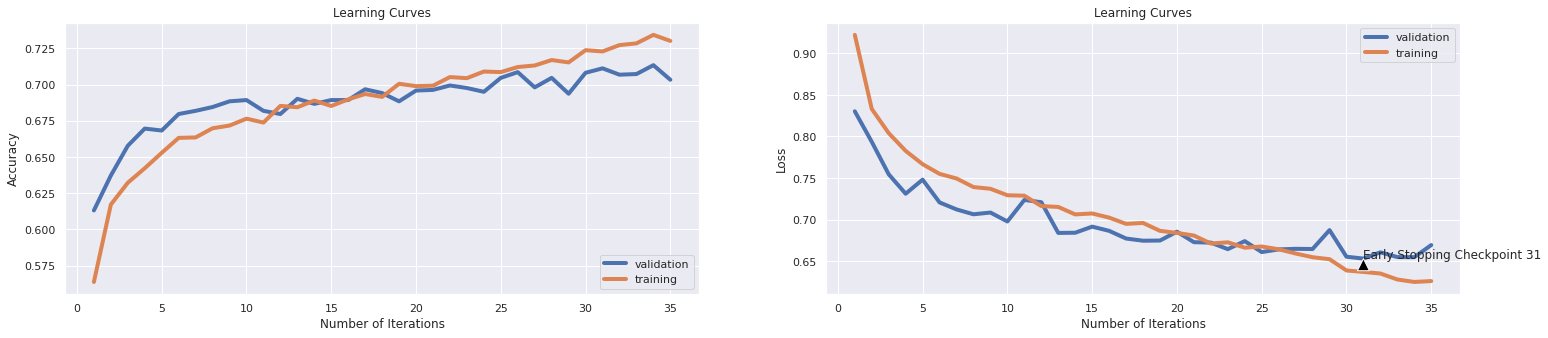

              precision    recall  f1-score
neutral        0.857143  0.687324  0.762897
antivax        0.525692  0.449324  0.484517
provax         0.629787  0.803474  0.706107
macro avg      0.670874  0.646708  0.651174
weighted avg   0.722391  0.703330  0.703868


**Accuracy: 0.70333** 



Total time: 137.13 seconds


**Grid Search: 9, Type: GRU, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: 0.2, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: Performance**

Training accuracy scores: [0.5689784677015524, 0.6251251877816725, 0.646657486229344, 0.6480345518277416, 0.657986980470706, 0.6652478718077116, 0.6748247371056585, 0.6740736104156234, 0.6803329994992489, 0.6799574361542313, 0.6853405107661492, 0.6853405107661492, 0.689221331997997, 0.6923510265398097, 0.697608913370055, 0.6949799699549324, 0.7017401101652478, 0.7038683024536805, 0.704243865798698, 0.7086254381572359, 0.7090010015022534, 0.7141337005508263, 0.7156985478217326, 0.7156985478217326, 0.7227716574862293, 0.7216449674511768, 0.721457185778668, 0.7262769153730596, 0.7279669504256384, 0.7282173259889835, 0.7309714571857787, 0.7309714571857787, 0.7305958938407612, 0.7297195793690536, 0.7356034051076615]
Validation accuracy scores: [0.6196319018404908, 0.6437335670464505, 0.6380368098159509, 0.6577563540753725, 0.6695880806310254, 0.6656441717791411, 0.6730937773882559, 0.6822962313759859, 0.6814198071866784, 0.6875547765118317, 0.6901840490797546, 0.6967572304995618, 0.69544259

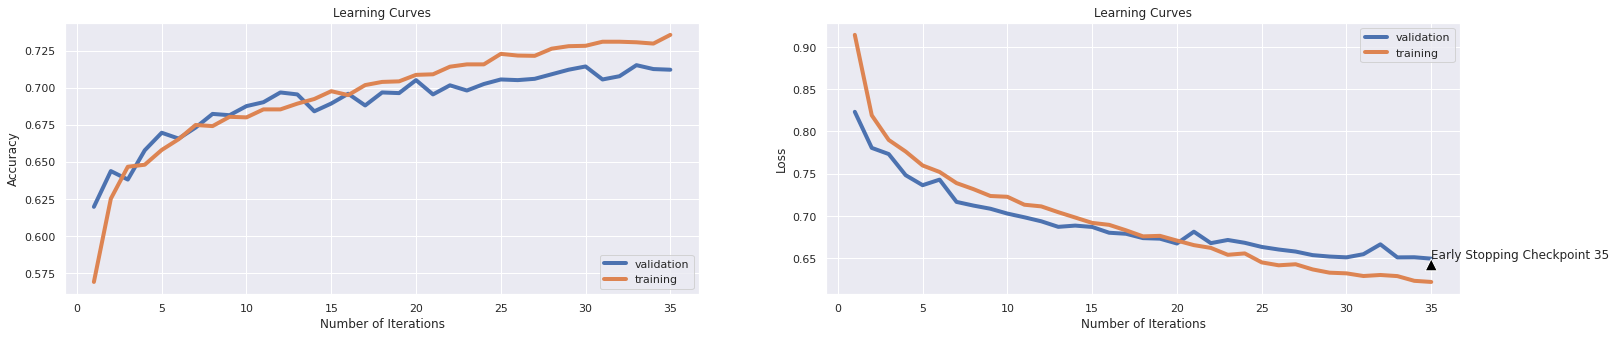

              precision    recall  f1-score
neutral        0.798058  0.771831  0.784726
antivax        0.533898  0.425676  0.473684
provax         0.666339  0.735071  0.699019
macro avg      0.666098  0.644192  0.652476
weighted avg   0.710633  0.712095  0.709790


**Accuracy: 0.71209** 



Total time: 88.48 seconds


**Grid Search: 10, Type: GRU, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: 0.4, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: Performance**

Training accuracy scores: [0.5453179769654481, 0.60728592889334, 0.6209939909864797, 0.6309464196294442, 0.6357661492238358, 0.6378943415122684, 0.6420255383074612, 0.6499749624436655, 0.6544191286930395, 0.6529794692038057, 0.659677015523285, 0.6634326489734602, 0.6676890335503255, 0.6681897846770155, 0.6671882824236355, 0.6706935403104657, 0.6706309464196294, 0.6764521782674011, 0.6765147721582374, 0.6825237856785178, 0.6774536805207811, 0.6815222834251377, 0.6835252879318978, 0.6837756634952429, 0.6881572358537806, 0.6832749123685529, 0.6834626940410616, 0.690473209814722, 0.6902854281422133, 0.6907861792689034, 0.6944792188282424, 0.6924136204306459, 0.6958562844266399, 0.6930395593390085, 0.7028042063094642]
Validation accuracy scores: [0.6056091148115688, 0.6279579316389132, 0.6507449605609115, 0.64943032427695, 0.6577563540753725, 0.6669588080631026, 0.670464504820333, 0.6713409290096407, 0.6765994741454864, 0.6735319894829097, 0.6827344434706398, 0.6853637160385626, 0.691060473

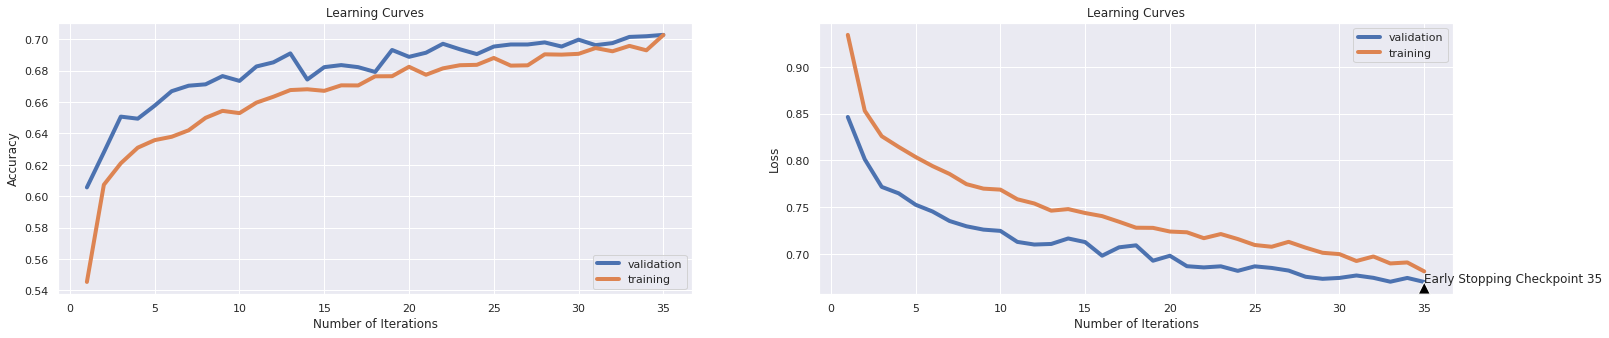

              precision    recall  f1-score
neutral        0.789883  0.762441  0.775920
antivax        0.610687  0.270270  0.374707
provax         0.634016  0.773073  0.696673
macro avg      0.678195  0.601928  0.615767
weighted avg   0.703733  0.702892  0.691895


**Accuracy: 0.70289** 



Total time: 88.74 seconds


**Grid Search: 11, Type: GRU, Hidden size: 128, Stacks: 2, Skip layers: None, Dropout: 0.2, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: Performance**

Training accuracy scores: [0.5820605908863294, 0.6342638958437656, 0.6475963945918878, 0.6565473209814722, 0.6638708062093139, 0.6736980470706059, 0.6802704056084126, 0.6810215322984476, 0.6837756634952429, 0.6905983975963946, 0.6927891837756635, 0.6912243365047571, 0.7002378567851778, 0.7052453680520782, 0.7101276915373059, 0.7116299449173761, 0.7136955433149724, 0.7170756134201302, 0.7215197796695042, 0.7307210816224337, 0.7274661992989484, 0.7314722083124687, 0.734727090635954, 0.7387330996494742, 0.7511266900350526]
Validation accuracy scores: [0.626205083260298, 0.6573181419807187, 0.6638913234005258, 0.670464504820333, 0.6739702015775635, 0.6757230499561788, 0.6805433829973707, 0.6858019281332165, 0.6875547765118317, 0.6744084136722174, 0.6914986853637161, 0.6950043821209465, 0.6884312007011394, 0.6879929886064855, 0.6958808063102542, 0.6906222611744084, 0.6989482909728308, 0.7024539877300614, 0.6998247151621385, 0.7068361086765995, 0.6897458369851008, 0.6998247151621385, 0.70683

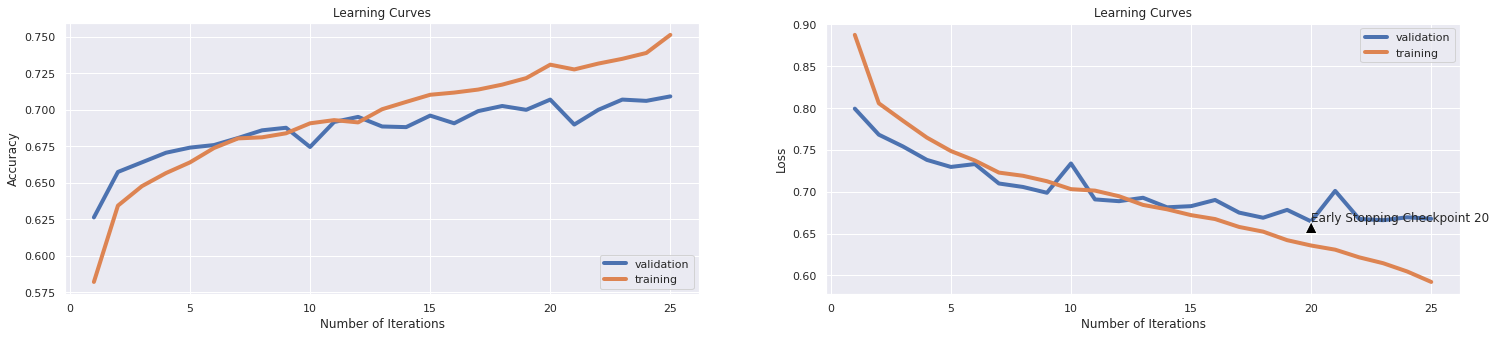

              precision    recall  f1-score
neutral        0.813008  0.751174  0.780869
antivax        0.511029  0.469595  0.489437
provax         0.661793  0.737242  0.697483
macro avg      0.661944  0.652670  0.655930
weighted avg   0.712809  0.709027  0.709413


**Accuracy: 0.70903** 



Total time: 69.18 seconds


**Grid Search: 12, Type: GRU, Hidden size: 128, Stacks: 2, Skip layers: None, Dropout: 0.4, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: Performance**

Training accuracy scores: [0.5718577866800201, 0.6122934401602403, 0.6259389083625438, 0.6342013019529293, 0.6434026039058588, 0.6538557836755132, 0.6546069103655483, 0.6623059589384076, 0.6656234351527291, 0.6708813219829745, 0.6731347020530796, 0.6698172258387581, 0.676201802704056, 0.675701051577366, 0.6822734101151727, 0.6832123184777166, 0.6876564847270906, 0.6902854281422133, 0.6861542313470206, 0.6931021532298448, 0.6954807210816224, 0.6957310966449675, 0.6945418127190787, 0.7001126690035052, 0.7001752628943415, 0.7061216825237857, 0.7016775162744117, 0.7086880320480721, 0.7089384076114171, 0.7061216825237857, 0.7114421632448673, 0.7125062593890836, 0.7175763645468203, 0.7154481722583875, 0.7174511767651477]
Validation accuracy scores: [0.6143733567046451, 0.6349693251533742, 0.6560035056967572, 0.6511831726555652, 0.656441717791411, 0.6682734443470639, 0.6669588080631026, 0.6744084136722174, 0.6827344434706398, 0.6739702015775635, 0.6888694127957932, 0.6871165644171779, 0.69675

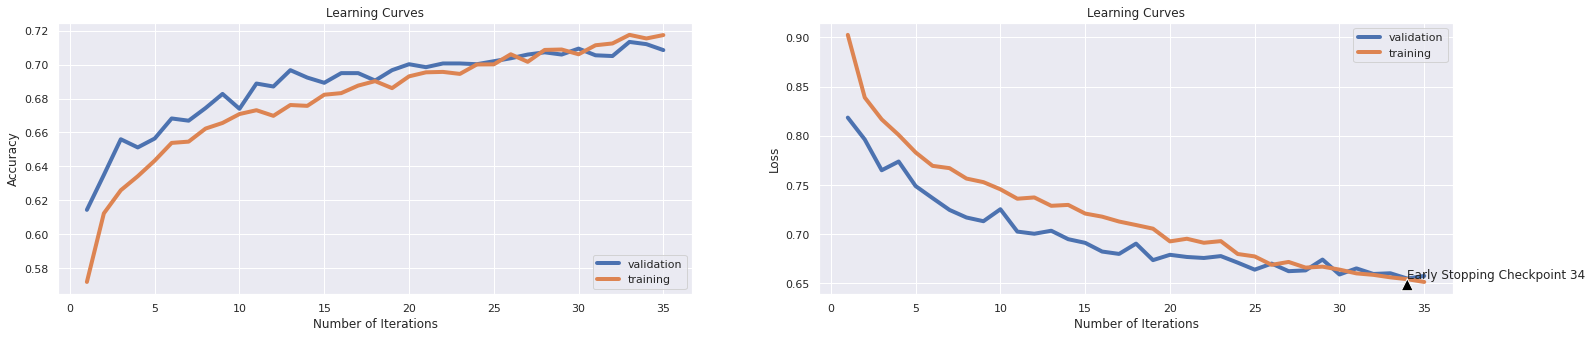

              precision    recall  f1-score
neutral        0.788168  0.775587  0.781827
antivax        0.543103  0.425676  0.477273
provax         0.663673  0.722041  0.691628
macro avg      0.664981  0.641101  0.650242
weighted avg   0.706135  0.708589  0.705919


**Accuracy: 0.70859** 



Total time: 96.53 seconds


**Grid Search: 13, Type: GRU, Hidden size: 64, Stacks: 3, Skip layers: None, Dropout: 0.2, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: Performance**

Training accuracy scores: [0.5880696044066099, 0.6310716074111167, 0.64271407110666, 0.6511642463695543, 0.657486229344016, 0.6634326489734602, 0.6689409113670506, 0.6781422133199799, 0.6797696544817226, 0.6834626940410616, 0.6879068602904357, 0.6904106159238859, 0.6899098647971958, 0.697608913370055, 0.6982348522784176, 0.7024286429644466, 0.7023034551827742, 0.7038057085628443, 0.7071231847771657, 0.7089384076114171, 0.7113169754631948, 0.7139459188783175, 0.7187030545818728, 0.7200175262894342, 0.721457185778668, 0.7222709063595393, 0.7287806710065098, 0.7265272909364046, 0.7300325488232349, 0.7299073610415624, 0.7324111166750125, 0.730095142714071, 0.7391086629944917, 0.7383575363044567, 0.7397346019028542]
Validation accuracy scores: [0.6270815074496056, 0.6573181419807187, 0.6630148992112183, 0.6669588080631026, 0.677475898334794, 0.6735319894829097, 0.6814198071866784, 0.6875547765118317, 0.6836108676599474, 0.6928133216476775, 0.694127957931639, 0.6967572304995618, 0.6958808063

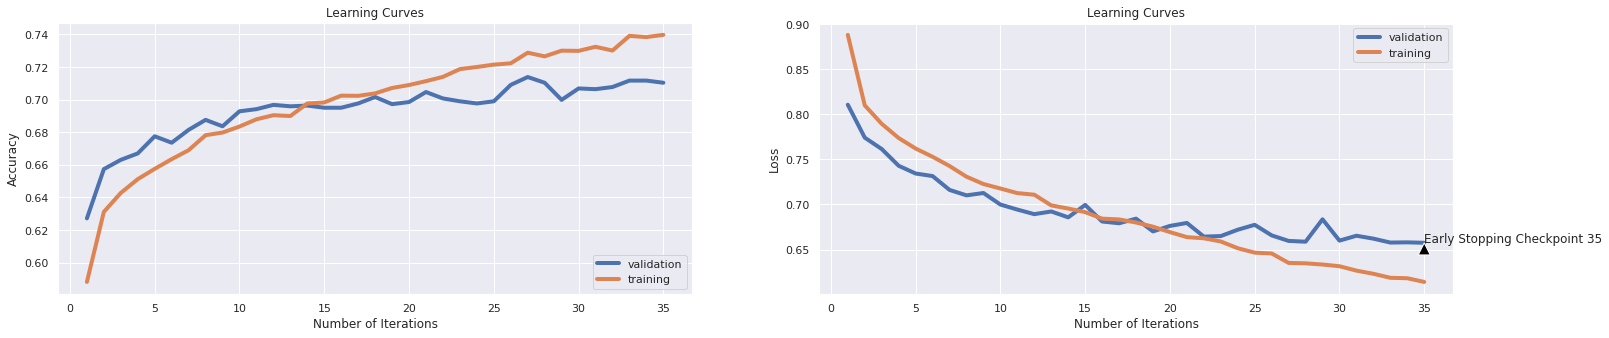

              precision    recall  f1-score
neutral        0.833873  0.725822  0.776104
antivax        0.551724  0.378378  0.448898
provax         0.638889  0.799131  0.710082
macro avg      0.674829  0.634444  0.645028
weighted avg   0.718581  0.710342  0.707016


**Accuracy: 0.71034** 



Total time: 124.53 seconds


**Grid Search: 14, Type: GRU, Hidden size: 64, Stacks: 3, Skip layers: None, Dropout: 0.4, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: Performance**

Training accuracy scores: [0.5752378567851778, 0.6062218327491237, 0.6173009514271407, 0.6261892839258888, 0.6321982974461693, 0.6400851276915374, 0.642463695543315, 0.6491612418627942, 0.6522909364046069, 0.6598022033049574, 0.6620555833750625, 0.6617426139208813, 0.6694416624937406, 0.6675012518778167, 0.6701927891837757, 0.6723835753630446, 0.6708187280921382, 0.6759514271407111, 0.6789559339008513, 0.6828993490235353, 0.6810841261892839, 0.6840886329494241, 0.6839008512769154, 0.6866549824737106, 0.6890961442163245, 0.690473209814722, 0.6892839258888332, 0.6929769654481722, 0.6945418127190787, 0.6932899349023536, 0.6951677516274412, 0.6946670005007511, 0.7001126690035052, 0.696607411116675, 0.703743114672008]
Validation accuracy scores: [0.6148115687992989, 0.6446099912357581, 0.6432953549517967, 0.6516213847502191, 0.6630148992112183, 0.661262050832603, 0.6713409290096407, 0.6730937773882559, 0.6779141104294478, 0.6827344434706398, 0.6849255039439088, 0.6818580192813322, 0.6836108

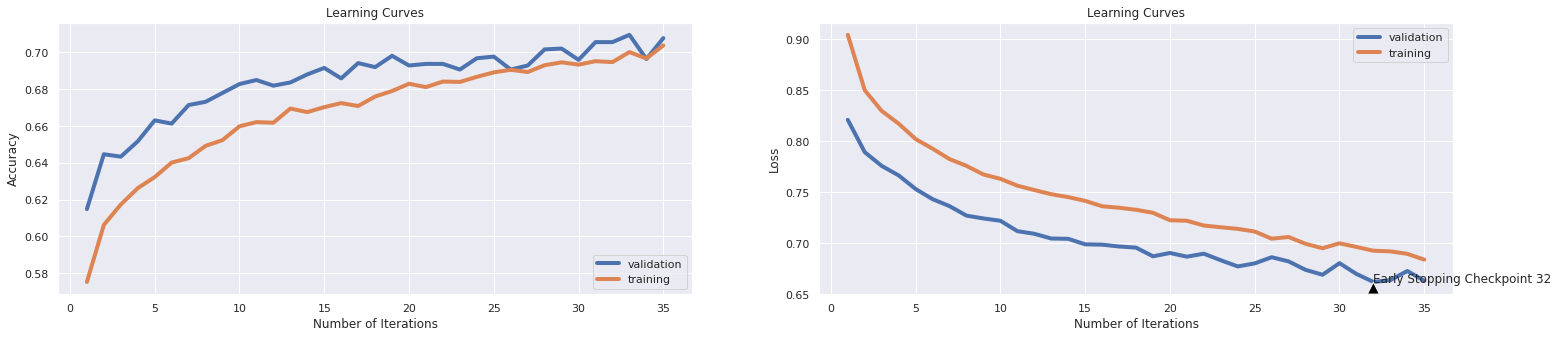

              precision    recall  f1-score
neutral        0.815005  0.744601  0.778214
antivax        0.531532  0.398649  0.455598
provax         0.647654  0.764387  0.701195
macro avg      0.664730  0.635879  0.645003
weighted avg   0.710694  0.707713  0.705283


**Accuracy: 0.70771** 



Total time: 124.85 seconds


**Grid Search: 15, Type: GRU, Hidden size: 128, Stacks: 3, Skip layers: None, Dropout: 0.2, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: Performance**

Training accuracy scores: [0.5983350025037556, 0.6304456685027542, 0.6473460190285428, 0.6582999499248874, 0.6668753129694541, 0.6752628943415123, 0.675450676014021, 0.6882198297446169, 0.6910365548322484, 0.6906609914872308, 0.6959188783174762, 0.7053705558337506, 0.7056835252879319, 0.7049949924887331, 0.7087506259389084, 0.7116299449173761, 0.7205182774161242, 0.7271532298447672, 0.7248372558838257, 0.7279043565348022, 0.7342889334001002, 0.7428017025538307, 0.7372934401602403, 0.7416750125187782, 0.75050075112669, 0.7592638958437656]
Validation accuracy scores: [0.6371603856266433, 0.6524978089395267, 0.6581945661700263, 0.6638913234005258, 0.6752848378615249, 0.6783523225241017, 0.6901840490797546, 0.6858019281332165, 0.6936897458369851, 0.6923751095530236, 0.6976336546888694, 0.6958808063102542, 0.6971954425942156, 0.6985100788781771, 0.7050832602979842, 0.7042068361086766, 0.7059596844872918, 0.7116564417177914, 0.7094653812445223, 0.7085889570552147, 0.7059596844872918, 0.71779

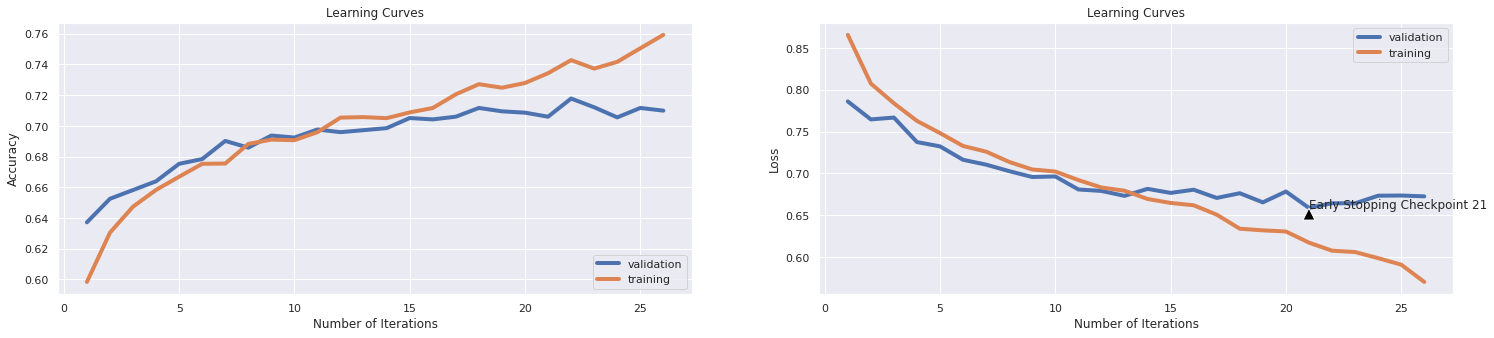

              precision    recall  f1-score
neutral        0.826180  0.723005  0.771157
antivax        0.659259  0.300676  0.412993
provax         0.626337  0.826276  0.712547
macro avg      0.703926  0.616652  0.632232
weighted avg   0.723874  0.709904  0.701044


**Accuracy: 0.70990** 



Total time: 101.47 seconds


**Grid Search: 16, Type: GRU, Hidden size: 128, Stacks: 3, Skip layers: None, Dropout: 0.4, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: Performance**

Training accuracy scores: [0.5726715072608913, 0.6101652478718077, 0.6263144717075614, 0.6380821231847772, 0.639772158237356, 0.649349023535303, 0.6553580370555834, 0.6624311467200801, 0.6608662994491737, 0.6667501251877817, 0.6692538808212318, 0.6721331997996995, 0.6718828242363545, 0.677391086629945, 0.6771407110665999, 0.6819604406609915, 0.6812093139709564, 0.6870305458187281, 0.6891587381071608, 0.6925388082123185, 0.6948547821732599, 0.6942288432648973, 0.6927265898848273, 0.6960440660991487, 0.700300450676014, 0.7001126690035052, 0.7017401101652478, 0.7085002503755633, 0.7122558838257386, 0.7079994992488733, 0.7138833249874812, 0.71457185778668, 0.7187030545818728, 0.7190160240360541, 0.7156985478217326]
Validation accuracy scores: [0.6406660823838738, 0.6507449605609115, 0.6507449605609115, 0.663453111305872, 0.6520595968448729, 0.677475898334794, 0.6805433829973707, 0.6761612620508326, 0.6827344434706398, 0.6871165644171779, 0.6888694127957932, 0.6884312007011394, 0.6879929886

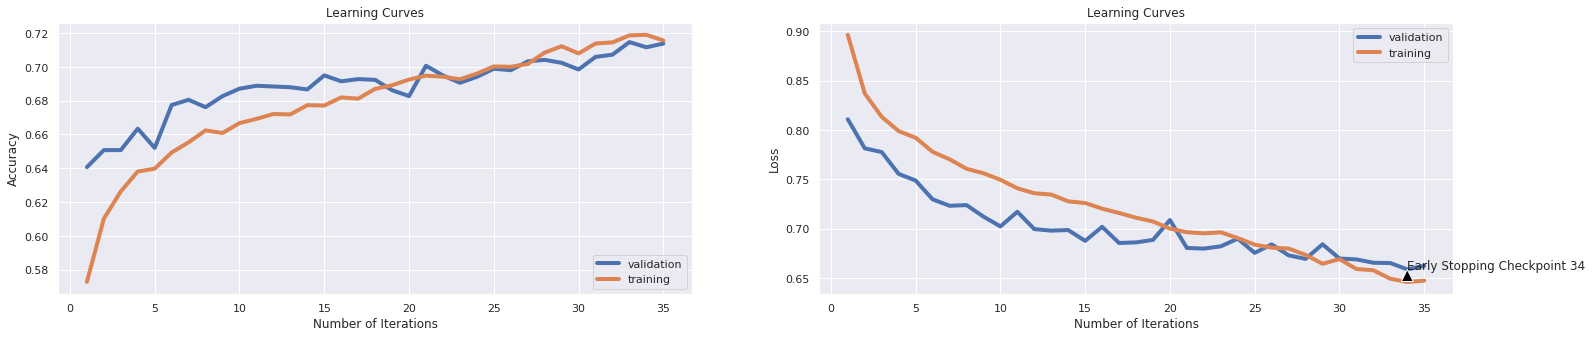

              precision    recall  f1-score
neutral        0.833686  0.738967  0.783474
antivax        0.560976  0.388514  0.459082
provax         0.641659  0.789359  0.707887
macro avg      0.678774  0.638947  0.650148
weighted avg   0.720812  0.713848  0.710891


**Accuracy: 0.71385** 



Total time: 136.67 seconds

Best grid is: Grid Search: 9, Type: GRU, Hidden size: 64, Stacks: 2, Skip layers: None, Dropout: 0.2, Max clipping: 5, Encoding strategy: LAST STATES, Learning rate: 0.0003, Schelduler: Performance



In [ ]:
param_grid = {
  'types': ['LSTM', 'GRU'],
  'hidden_dimensions': [64, 128],
  'layers_info': [{'stacks': 2, 'skip': None}, {'stacks': 3, 'skip': None}],
  'max_clip_norms': [5],
  'dropout_rates': [0.2, 0.4],
  'encoding_stategies': ['LAST_STATES'],
  'bidirectional': True,
  'sequence_length': 50,
  'learning_rates': [{'val': 3e-4, 'schelduler' : 'Performance'}],
  'classes': ['neutral', 'antivax', 'provax'],
  'batch_size': 128,
  'epochs': 35,
  'early_stopping_patience': 5,
  'L2_reg': 0,
  'accuracy_threshold': 0.68
}

customGridSearch(param_grid, glove_training_set, glove_validation_set, embedding_matrix)

## **Best Model**

Training accuracy scores: [0.5690410615923885, 0.6245618427641462, 0.6430896344516775, 0.6519779669504256, 0.6598647971957937, 0.6656860290435653, 0.6700050075112669, 0.6766399599399099, 0.6801452178267401, 0.6838382573860792, 0.6872809213820731, 0.6870305458187281, 0.6957310966449675, 0.6939784677015524, 0.6959814722083125, 0.6987356034051077, 0.7002378567851778, 0.7046820230345519, 0.7073109664496745, 0.7095643465197796, 0.7123184777165749, 0.7123184777165749, 0.7125062593890836, 0.7155107661492238, 0.7200175262894342, 0.7207060590886329, 0.7228968452679019, 0.7249624436654982, 0.7274661992989484, 0.7262769153730596, 0.7322233350025038, 0.7314096144216324, 0.7327240861291938, 0.7369804707060591, 0.7414872308462694]
Validation accuracy scores: [0.6248904469763366, 0.654250657318142, 0.6590709903593339, 0.6652059596844873, 0.6682734443470639, 0.6713409290096407, 0.6752848378615249, 0.6744084136722174, 0.6827344434706398, 0.6875547765118317, 0.6914986853637161, 0.6879929886064855, 0.695

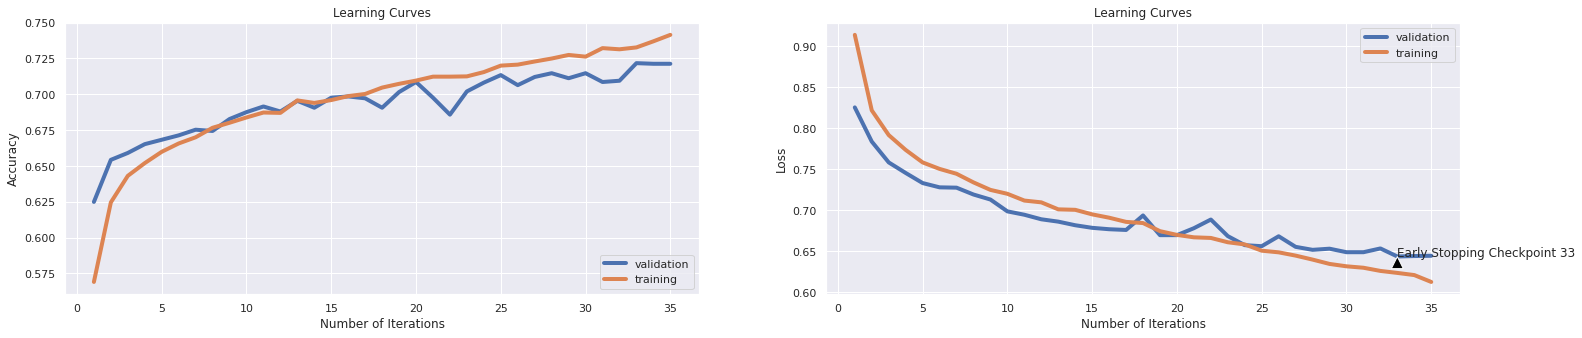

              precision    recall  f1-score
neutral        0.797348  0.790610  0.793965
antivax        0.567961  0.395270  0.466135
provax         0.673529  0.745928  0.707883
macro avg      0.679613  0.643936  0.655994
weighted avg   0.717622  0.721297  0.716700


**Accuracy: 0.72130** 


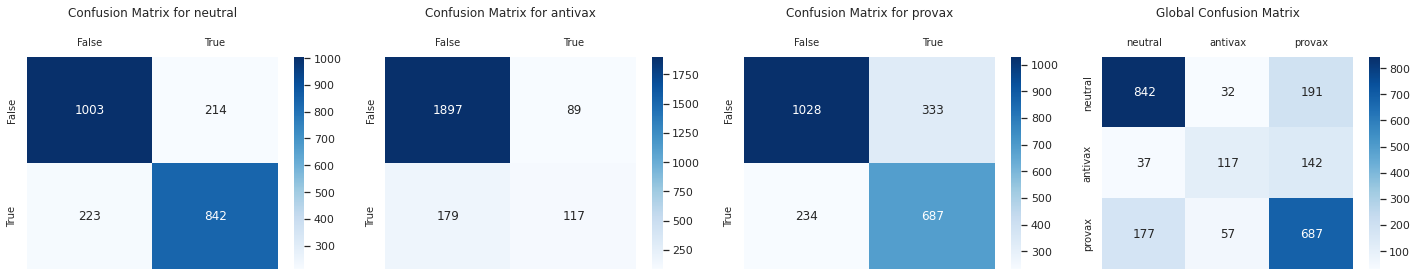

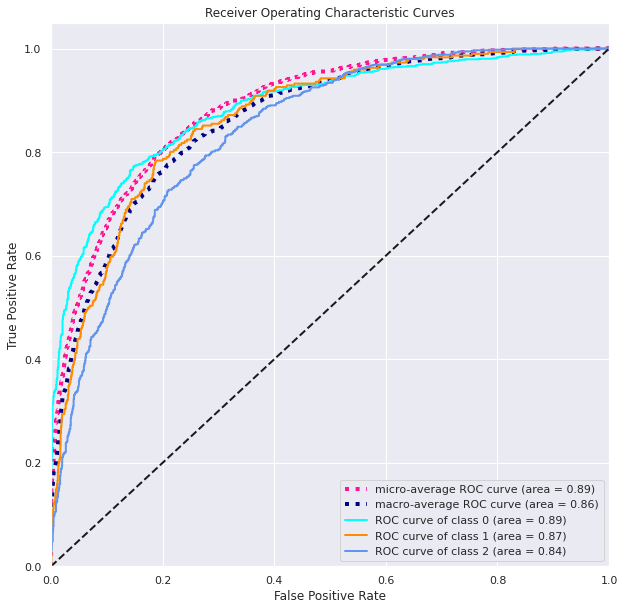

In [ ]:
# Hyperparameters
hidden_dim = 64
num_layers = 2
dropout_rate = 0.2
max_clip_norm = 5
skip_layers = None
batch_size = 128
epochs = 35
seq_length = 50
early_stopping_patience = 5
learning_rate = 3e-4

rnn_type = 'GRU'
encoding_strategy = 'LAST_STATES'
classes = ['neutral', 'antivax', 'provax']

model = RecurrentNeuralNet(rnn_type, embedding_matrix, hidden_dim, len(classes), num_layers, True, dropout_rate, skip_layers, None, encoding_strategy).to(device)

optimizer = torch.optim.Adam(model.parameters(), learning_rate)
loss_function = nn.CrossEntropyLoss()
schelduler = {'name':  'Performance', 'schelduler': scheldulers['Performance'](optimizer, 3, 0.5), 'epoch_step': True}

model.trainNNWithOptions(glove_training_set, optimizer, loss_function, glove_validation_set, schelduler, seq_length, max_clip_norm, epochs, batch_size, True, early_stopping_params = {'patience': early_stopping_patience})
scores = modelEvaluation(model, glove_validation_set, classes, seq_length, 512, True, True)

## **Is attention all we need?**

Adding attention to the best model using two different attention models. The first one is the simple **dot product attention** and the second one is the **multiplicative attention**. The attention mechanism is applied to a **seq2one** model instead of a **seq2seq** so it seems to be more like **self attention**.

Training accuracy scores: [0.5895092638958438, 0.6300701051577366, 0.6453430145217827, 0.6518527791687532, 0.6594892338507762, 0.6681271907861792, 0.6689409113670506, 0.6696294441662494, 0.6776414621932899, 0.6782674011016525, 0.6802704056084126, 0.6858412618928392, 0.6881572358537806, 0.6962318477716575, 0.7006134201301953, 0.6984852278417626, 0.7054957436154231, 0.7061216825237857, 0.7062468703054582, 0.7073735603405108, 0.7133199799699549, 0.7118177265898848, 0.7112543815723585, 0.7129444166249375, 0.7217701552328493, 0.7184526790185278, 0.7207060590886329, 0.7277791687531296, 0.7255883825738608, 0.7282799198798198, 0.735478217325989, 0.735227841762644, 0.7351652478718077, 0.7382949424136205, 0.7341637456184277]
Validation accuracy scores: [0.6314636283961438, 0.6367221735319895, 0.6573181419807187, 0.6678352322524101, 0.6748466257668712, 0.6809815950920245, 0.6805433829973707, 0.6827344434706398, 0.6814198071866784, 0.6871165644171779, 0.6906222611744084, 0.686678352322524, 0.69588

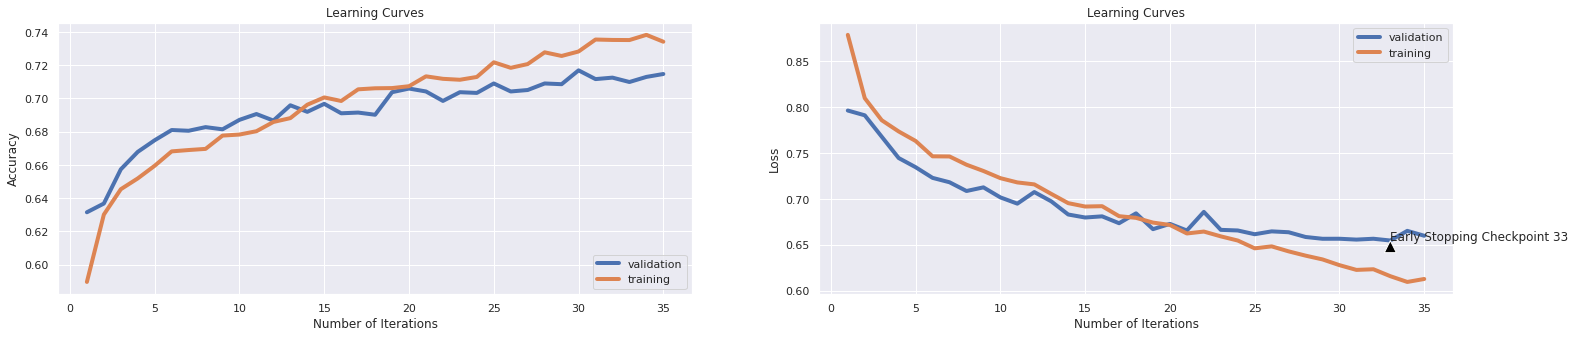

              precision    recall  f1-score
neutral        0.796724  0.776526  0.786495
antivax        0.558824  0.385135  0.456000
provax         0.663462  0.749186  0.703723
macro avg      0.673003  0.636949  0.648739
weighted avg   0.712082  0.714724  0.710220


**Accuracy: 0.71472** 


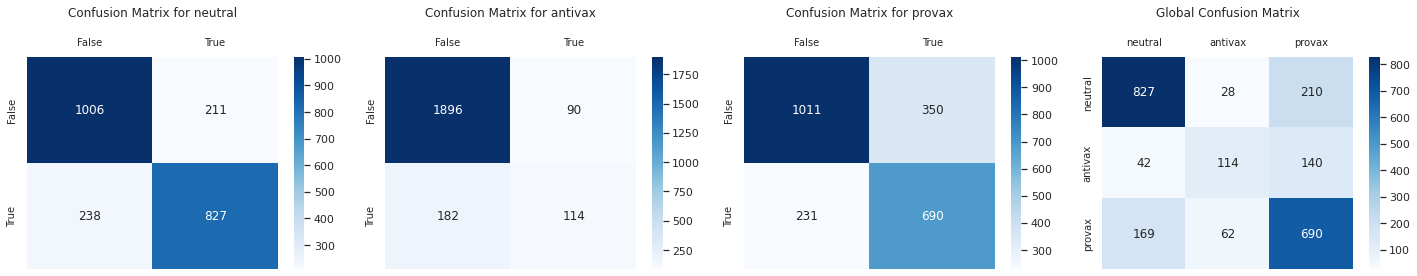

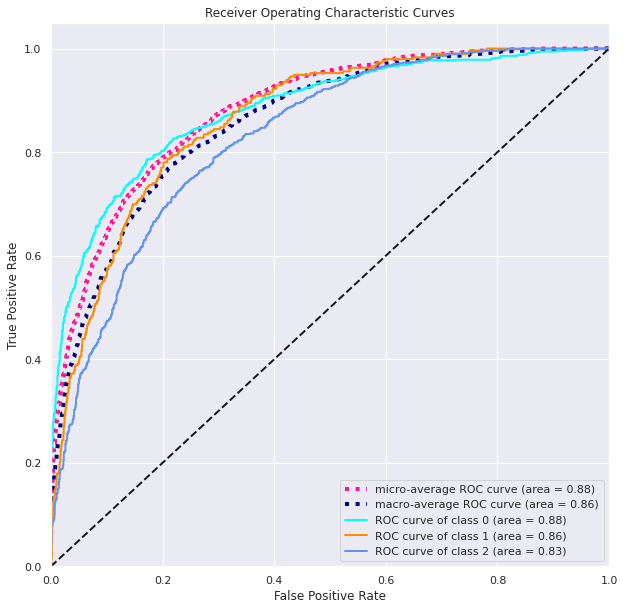

In [ ]:
# Hyperparameters
hidden_dim = 64
num_layers = 2
dropout_rate = 0.2
max_clip_norm = 5
skip_layers = None
batch_size = 128
epochs = 35
seq_length = 50
early_stopping_patience = 5
learning_rate = 3e-4

rnn_type = 'GRU'
encoding_strategy = 'LAST_STATES'
classes = ['neutral', 'antivax', 'provax']

model = RecurrentNeuralNet(rnn_type, embedding_matrix, hidden_dim, len(classes), num_layers, True, dropout_rate, skip_layers, 'ATTENTION_DOT', encoding_strategy).to(device)

optimizer = torch.optim.Adam(model.parameters(), learning_rate)
loss_function = nn.CrossEntropyLoss()
schelduler = {'name':  'Performance', 'schelduler': scheldulers['Performance'](optimizer, 3, 0.5), 'epoch_step': True}

model.trainNNWithOptions(glove_training_set, optimizer, loss_function, glove_validation_set, schelduler, seq_length, max_clip_norm, epochs, batch_size, True, early_stopping_params = {'patience': early_stopping_patience})
scores = modelEvaluation(model, glove_validation_set, classes, seq_length, 512, True, True)

Training accuracy scores: [0.5940160240360541, 0.6401477215823735, 0.6538557836755132, 0.6618052078117176, 0.6676264396594892, 0.6675012518778167, 0.6739484226339509, 0.6765147721582374, 0.683337506259389, 0.686029043565348, 0.688970956434652, 0.6931021532298448, 0.696607411116675, 0.7009889834752128, 0.7024286429644466, 0.7040560841261893, 0.7077491236855283, 0.7114421632448673, 0.7131321982974461, 0.7182023034551828, 0.721206810215323, 0.7216449674511768, 0.7213319979969955, 0.730095142714071, 0.7297195793690536, 0.7298447671507261, 0.7371682523785679, 0.7365423134702053, 0.7402353530295444, 0.7434902353530295, 0.7484977466199298, 0.7444291437155733, 0.7561967951927892]
Validation accuracy scores: [0.6432953549517967, 0.654250657318142, 0.6700262927256793, 0.6792287467134093, 0.6822962313759859, 0.6914986853637161, 0.6822962313759859, 0.6827344434706398, 0.6871165644171779, 0.6888694127957932, 0.6932515337423313, 0.6901840490797546, 0.6928133216476775, 0.7037686240140227, 0.702892199

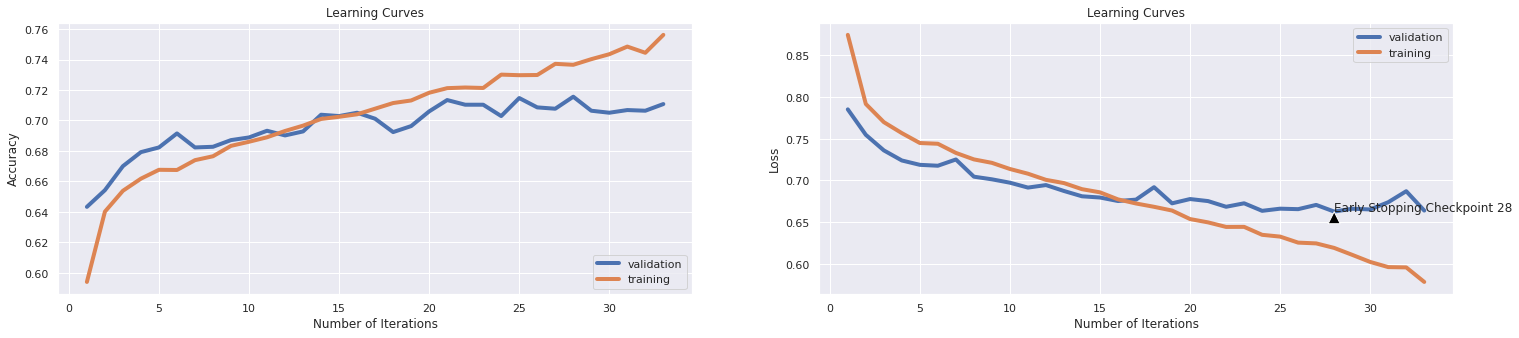

              precision    recall  f1-score
neutral        0.796693  0.769014  0.782609
antivax        0.535545  0.381757  0.445759
provax         0.661553  0.749186  0.702648
macro avg      0.664597  0.633319  0.643672
weighted avg   0.708278  0.710780  0.706644


**Accuracy: 0.71078** 


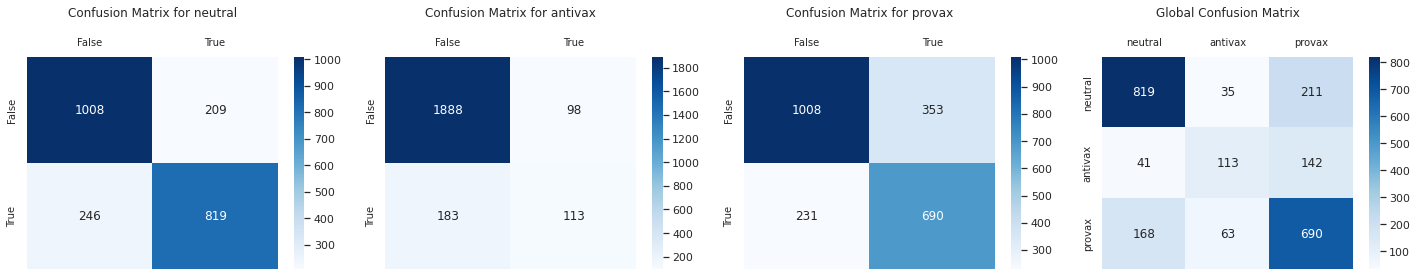

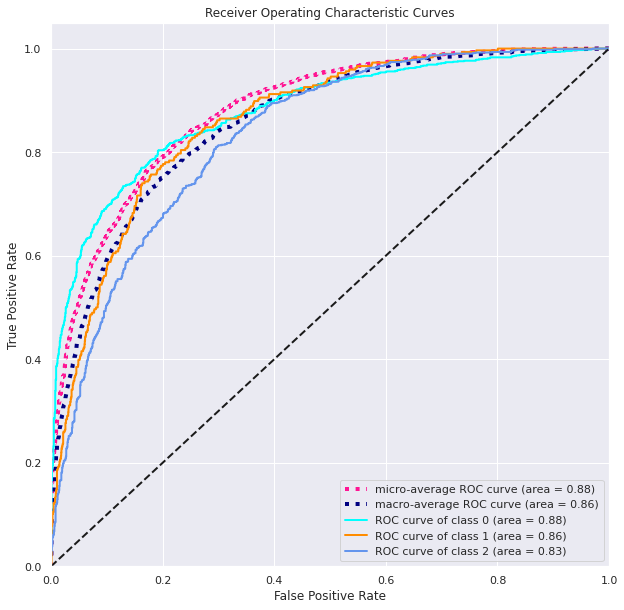

In [ ]:
# Hyperparameters
hidden_dim = 64
num_layers = 2
dropout_rate = 0.2
max_clip_norm = 5
skip_layers = None
batch_size = 128
epochs = 35
seq_length = 50
early_stopping_patience = 5
learning_rate = 3e-4

rnn_type = 'GRU'
encoding_strategy = 'LAST_STATES'
classes = ['neutral', 'antivax', 'provax']

model = RecurrentNeuralNet(rnn_type, embedding_matrix, hidden_dim, len(classes), num_layers, True, dropout_rate, skip_layers, 'ATTENTION_GENERAL', encoding_strategy).to(device)

optimizer = torch.optim.Adam(model.parameters(), learning_rate)
loss_function = nn.CrossEntropyLoss()
schelduler = {'name':  'Performance', 'schelduler': scheldulers['Performance'](optimizer, 3, 0.5), 'epoch_step': True}

model.trainNNWithOptions(glove_training_set, optimizer, loss_function, glove_validation_set, schelduler, seq_length, max_clip_norm, epochs, batch_size, True, early_stopping_params = {'patience': early_stopping_patience})
scores = modelEvaluation(model, glove_validation_set, classes, seq_length, 512, True, True)